In [1]:
import glob, copy
import argparse
import yaml, h5py
import numpy as NP
from astropy.io import ascii
from astropy import units as U
import astropy.cosmology as cosmology
import astropy.constants as FC
import matplotlib.pyplot as PLT
import matplotlib.patches as patches
import matplotlib.ticker as ticker
from matplotlib.lines import Line2D
from astroutils import cosmotile
from astroutils import mathops as OPS
from astroutils import DSP_modules as DSP
from astroutils import lookup_operations as LKP
from astroutils import constants as CNST
from prisim import delay_spectrum as DS
from IPython.core.debugger import set_trace
%matplotlib inline

In [2]:
cosmoPlanck15 = cosmology.Planck15 # Planck 2015 cosmology
cosmo100_Planck15 = cosmoPlanck15.clone(name='Modified Planck 2015 cosmology with h=1.0', H0=100.0) # Modified Planck 2015 cosmology with h=1.0, H= 100 km/s/Mpc

## Define some useful functions

In [3]:
def read_raw_lightcone_cube(parms):

#     cube_source = parms['cube_source']
#     if not isinstance(cube_source, str):
#         raise TypeError('Input cube_source must be a string')
#     if cube_source.lower() not in ['21cmfast']:
#         raise ValueError('{0} cubes currently not supported'.format(cube_source))

    indir = parms['indir']
    infile_prefix = parms['infile_prefix']
    if infile_prefix is None:
        infile_prefix = ''
    infile_suffix = parms['infile_suffix']
    if infile_suffix is None:
        infile_suffix = ''

    fname_delimiter = parms['parseinfo']['delimiter']
    zstart_pos = parms['parseinfo']['zstart_pos']
    zend_pos = parms['parseinfo']['zend_pos']
    zstart_identifier = parms['parseinfo']['zstart_identifier']
    zend_identifier = parms['parseinfo']['zend_identifier']
    zstart_identifier_pos = parms['parseinfo']['zstart_identifier_pos']
    zend_identifier_pos = parms['parseinfo']['zend_identifier_pos']
    if zstart_identifier is not None:
        if zstart_identifier_pos.lower() not in ['before', 'after']:
            raise ValueError('zstart_identifier_pos must be set to "before" or "after"')
        elif zstart_identifier_pos.lower() == 'before':
            zstart_value_place = 1
        else:
            zstart_value_place = 0

    if zend_identifier is not None:
        if zend_identifier_pos.lower() not in ['before', 'after']:
            raise ValueError('zend_identifier_pos must be set to "before" or "after"')
        elif zend_identifier_pos.lower() == 'before':
            zend_value_place = 1
        else:
            zend_value_place = 0
            
    fullfnames = glob.glob(indir + infile_prefix + '*' + infile_suffix)
    fullfnames = NP.asarray(fullfnames)
    fnames = [fname.split('/')[-1] for fname in fullfnames]
    fnames = NP.asarray(fnames)
    if fnames[0].split(fname_delimiter)[-1] == 'lighttravel':
        dim = int(fnames[0].split(fname_delimiter)[-3])
        boxsize = float(fnames[0].split(fname_delimiter)[-2][:-3])
    else:
        dim = int(fnames[0].split(fname_delimiter)[-2])
        boxsize = float(fnames[0].split(fname_delimiter)[-1][:-3])
    boxres = boxsize / dim
    if zstart_identifier is not None:
        zstart_str = [fname.replace(fname_delimiter,' ').split()[zstart_pos].split(zstart_identifier)[zstart_value_place] for fname in fnames]
    else:
        zstart_str = [fname.replace(fname_delimiter,' ').split()[zstart_pos] for fname in fnames]
    if zend_identifier is not None:
        zend_str = [fname.replace(fname_delimiter,' ').split()[zend_pos].split(zend_identifier)[zend_value_place] for fname in fnames]
    else:
        zend_str = [fname.replace(fname_delimiter,' ').split()[zend_pos] for fname in fnames]
    
    zstart = NP.asarray(map(float, zstart_str))
    zend = NP.asarray(map(float, zend_str))
    sortind = NP.argsort(zstart)
    zstart = zstart[sortind]
    zend = zend[sortind]
    fnames = fnames[sortind]
    fullfnames = fullfnames[sortind]
    lightcone_cube = None
    for fi,fullfname in enumerate(fullfnames):
        lc_cube = cosmotile.fastread_21cmfast_cube(fullfname)
        if lightcone_cube is None:
            lightcone_cube = NP.copy(lc_cube)
        else:
            lightcone_cube = NP.concatenate((lightcone_cube, lc_cube), axis=0) # Line of sight seems to be the first axis
    return (lightcone_cube, boxres, zstart.min())

In [4]:
def monopole(lightcone_cube):
    """
    Assumed to have shape (nlos,...) where the average will be estimated across all except the first axis
    """
    if lightcone_cube.ndim <= 1:
        raise ValueError('Insufficient axes to average')
    avgaxes = NP.arange(1,lightcone_cube.ndim)
    return NP.mean(lightcone_cube, axis=tuple(avgaxes))

In [5]:
def write_raw_lightcone_cube(lightcone_cube, boxres, zmin, outfile, units='',
                             cosmo_in=cosmo100_Planck15):

    """
    Write a lightcone cube in 21cmFAST format to a file in HDF5 format
    """

    cosmo100 = cosmo.clone(name='Modified cosmology with h=1.0', H0=100.0) # Modified cosmology with h=1.0, H= 100 km/s/Mpc

    monopole_values = monopole(lightcone_cube)

    with h5py.File(outfile, 'w') as fileobj:
        hdr_grp = fileobj.create_group('header')
        hdr_grp['boxres'] = cosmo_in.h * boxres
        hdr_grp['boxres'].attrs['units'] = 'Mpc'
        hdr_grp['zmin'] = zmin
        cosmo_grp = fileobj.create_group('cosmo')
        cosmo_grp['H0'] = cosmo100.H0.value
        cosmo_grp['H0'].attrs['units'] = '{0}'.format(cosmo100.H0.unit)
        cosmo_grp['Om0'] = cosmo100.Om0
        cosmo_grp['Ode0'] = cosmo100.Ode0
        cosmo_grp['Ob0'] = cosmo100.Ob0
        cosmo_grp['w0'] = cosmo100.w(0.0)
        cosmo_grp['Tcmb0'] = cosmo100.Tcmb0.value
        cosmo_grp['Tcmb0'].attrs['units'] = '{0}'.format(cosmo100.Tcmb0.unit)
        cube_dset = fileobj.create_dataset('cube', lightcone_cube.shape, data=lightcone_cube)
        cube_dset.attrs['units'] = units
        monopole_dset = fileobj.create_dataset('monopole', monopole_values.shape, data=monopole_values)
        monopole_dset.attrs['units'] = units

In [6]:
def read_HDF5_lightcone_cube(infile):

    with h5py.File(infile, 'r') as fileobj:
        hdrinfo = {key: fileobj['header'][key].value for key in fileobj['header']}
        cosmoinfo = {key: fileobj['cosmo'][key].value for key in fileobj['cosmo']}
        lightcone_cube_units = fileobj['cube'].attrs['units']
        lightcone_cube = fileobj['cube'].value * U.Unit(lightcone_cube_units)
        if 'monopole_temperature' in fileobj:
            monopole_values = fileobj['monopole_temperature'] * U.Unit(lightcone_cube_units)
        elif 'monopole' in fileobj:
            monopole_values = fileobj['monopole'] * U.Unit(lightcone_cube_units)
        else:
            monopole_values = None

    boxres = hdrinfo['boxres'] * U.Unit('Mpc')
    zmin = hdrinfo['zmin']
    cosmo = cosmology.wCDM(cosmoinfo['H0'], cosmoinfo['Om0'], cosmoinfo['Ode0'], w0=cosmoinfo['w0'], Ob0=cosmoinfo['Ob0'], Tcmb0=cosmoinfo['Tcmb0']*U.K)
    
    return (lightcone_cube, monopole_values, boxres, zmin, cosmo)

In [7]:
def optical_depth_21cm(spin_T, x_H, overdensity, redshift, cosmo_in=cosmo100_Planck15, reference='Santos+2005'):

    """
    Compute 21cm optical depth based on the expression provided in the specified reference, T_spin, neutral fraction, 
    overdensity, and cosmological parameters
    """
    
    if reference.lower() not in ['santos+2005', 'pritchard_loeb_2010', 'zaldarriaga+2004', 'tozzi+2000', 'bharadwaj_ali_2005', 'cooray_2004', 'cooray_2005']:
        raise ValueError('Expression from reference {0} not supported'.format(reference))

    if not isinstance(spin_T, (int,float,NP.ndarray)):
        raise TypeError('Input spin_T must be scalar or numpy array')
    if not isinstance(x_H, (int,float,NP.ndarray)):
        raise TypeError('Input x_H must be scalar or numpy array')
    if not isinstance(overdensity, (int,float,NP.ndarray)):
        raise TypeError('Input overdensity must be scalar or numpy array')
    if not isinstance(redshift, (int,float,NP.ndarray)):
        raise TypeError('Input redshift must be scalar or numpy array')
        
    spin_T = spin_T.to('K')
    spin_T = NP.asarray(spin_T.value) * U.K
    x_H = NP.asarray(x_H)
    overdensity = NP.asarray(overdensity)
    redshift = NP.asarray(redshift)
    
    if spin_T.ndim == 0: 
        spin_T = spin_T.reshape(-1)
    if x_H.ndim == 0: 
        x_H = x_H.reshape(-1)
    if overdensity.ndim == 0: 
        overdensity = overdensity.reshape(-1)
    if redshift.ndim == 0: 
        redshift = redshift.reshape(-1)

    shape_Tspin = spin_T.shape
    shape_xHI = x_H.shape
    shape_overdensity = overdensity.shape
    shape_redshift = redshift.shape
    outshape_redshift = [1]*spin_T.ndim
    outshape_redshift[-1] = -1
    outshape_redshift = tuple(outshape_redshift)
    
    if (shape_Tspin != shape_xHI) or (shape_Tspin != shape_overdensity) or (shape_Tspin[-1] != redshift.size):
        raise ValueError('Dimension mismatch!')
        
    if reference.lower() == 'santos+2005':
        optical_depth = 8.6e-3 * x_H * (1+overdensity) * cosmo_in.Tcmb0 * (1+redshift.reshape(outshape_redshift)) / spin_T * (cosmo_in.Ob0 * cosmo_in.h**2 / 0.02) * NP.sqrt(0.15 / (cosmo_in.Om0 * cosmo_in.h**2)) * NP.sqrt((1+redshift.reshape(outshape_redshift))/10.0) * (0.7/cosmo_in.h)
        
    return optical_depth.decompose().value

In [8]:
def temperature_to_fluxdensity(temperature, beamSA, frequency, ref_freq=None, spindex=None):

    """
    Input temperature should be of shape (..., nlos) if spindex is not set or set to zero. 
    Input temperature should be of shape (..., 1) if spindex is set to a non-zero scalar.
    Input frequency must be of shape (nlos,)
    Input beamSA must be of shape (nbeam,nlos) or (nbeam,1) or (nbeam,) (The latter two cases imply that same beam size applies to all frequencies)
    Output fluxdensity will be of shape (nbeam,...,nlos)
    """

    temperature = U.Quantity(temperature.si.value, U.K, ndmin=1)
    beamSA = U.Quantity(beamSA.si.value, U.sr, ndmin=1)
    frequency = U.Quantity(frequency.si.value, U.Hz, ndmin=1)

    if spindex is not None:
        if not isinstance(spindex, (int,float)):
            raise TypeError('Input spindex must be a scalar')
        if (temperature.size != 1) and (NP.abs(spindex) > 1e-10):
            raise ValueError('When spindex is provided, temperature must be a scalar')
    else:
        spindex = 0.0

    inshape = temperature.shape
    if temperature.ndim == 1:
        if (temperature.shape[-1] != frequency.size) and (temperature.shape[-1] != 1): # Should be (1,) or (nlos,)
            raise ValueError('Input temperature and frequency have incompatible dimensions')
        inshape = (1,) + inshape
    temperature = temperature.reshape(-1,inshape[-1])
    
    if beamSA.ndim == 1:
        beamSA = NP.asarray(beamSA.value).reshape(-1,1) * U.sr # (nbeam,1)
    if beamSA.ndim == 2:
        if (beamSA.shape[-1] != frequency.size) and (beamSA.shape[-1] != 1): # should be (nbeam, nlos) or (nbeam,1)
            raise ValueError('Input beamSA has incompatible dimensions.')
    if beamSA.ndim > 2:
        raise ValueError('Input beamSA has incompatible dimensions')
        
    frequency = NP.asarray(frequency.value).reshape(-1) * U.Hz # (nlos,)
    freq_center = NP.mean(frequency)
    if ref_freq is None:
        ref_freq = NP.mean(frequency)
    
    wl = FC.c / frequency # (nlos,)

    spec_T = temperature * (frequency.reshape(1,-1)/ref_freq)**spindex # (npix,nlos)
    
    outshape = (beamSA.shape[0],) + inshape[:-1] + (frequency.shape[-1],)
    
    fluxdensity_spectrum = 2 * FC.k_B * spec_T[NP.newaxis,...] * beamSA[:,NP.newaxis,:].to('', equivalencies=U.dimensionless_angles()) / (wl.reshape(1,1,-1)**2) # S.(wl**2 / Omega) = 2.k.T
    return fluxdensity_spectrum.to('mJy').reshape(outshape)

In [9]:
def fluxdensity_to_temperature(fluxdensity, beamSA, frequency, ref_freq=None, spindex=None):

    """
    Input temperature should be of shape (..., nlos) if spindex is not set or set to zero. 
    Input temperature should be of shape (..., 1) if spindex is set to a non-zero scalar.
    Input frequency must be of shape (nlos,)
    Input beamSA must be of shape (nbeam,nlos) or (nbeam,1) or (nbeam,) (The latter two cases imply that same beam size applies to all frequencies)
    Output fluxdensity will be of shape (nbeam,...,nlos)
    """

    fluxdensity_unit = fluxdensity.si.unit
    fluxdensity = U.Quantity(fluxdensity.si.value, fluxdensity_unit, ndmin=1)
    beamSA = U.Quantity(beamSA.si.value, U.sr, ndmin=1)
    frequency = U.Quantity(frequency.si.value, U.Hz, ndmin=1)

    if spindex is not None:
        if not isinstance(spindex, (int,float)):
            raise TypeError('Input spindex must be a scalar')
        if (fluxdensity.size != 1) and (NP.abs(spindex) > 1e-10):
            raise ValueError('When spindex is provided, fluxdensity must be a scalar')
    else:
        spindex = 0.0

    inshape = fluxdensity.shape
    if fluxdensity.ndim == 1:
        if (fluxdensity.shape[-1] != frequency.size) and (fluxdensity.shape[-1] != 1):
            raise ValueError('Input fluxdensity and frequency have incompatible dimensions')
        inshape = (1,) + inshape
    fluxdensity = fluxdensity.reshape(-1,inshape[-1])
    
    if beamSA.ndim <= 1:
        beamSA = NP.asarray(beamSA.value).reshape(-1,1) * U.sr # (nbeam,1)
    if beamSA.ndim == 2:
        if (beamSA.shape[-1] != frequency.size) and (beamSA.shape[-1] != 1): # should be (nbeam, nlos) or (nbeam,1)
            raise ValueError('Input beamSA has incompatible dimensions.')
    if beamSA.ndim > 2:
        raise ValueError('Input beamSA has incompatible dimensions')

    frequency = NP.asarray(frequency.value).reshape(-1) * U.Hz # (nlos,)
    if ref_freq is None:
        ref_freq = NP.mean(frequency)
    
    wl = FC.c / frequency # (nlos,)

    fluxdensity_spectrum = fluxdensity * (frequency.reshape(1,-1)/ref_freq)**spindex # (npix,nlos)

    outshape = (beamSA.shape[0],) + inshape[:-1] + (frequency.shape[-1],)
    
    spec_T = fluxdensity_spectrum[NP.newaxis,...] * wl.reshape(1,1,-1)**2 / (2 * FC.k_B * beamSA[:,NP.newaxis,:].to('', equivalencies=U.dimensionless_angles())) # S.(wl**2 / Omega) = 2.k.T
    return spec_T.to('K').reshape(outshape)   

In [10]:
def classical_source_confusion(theta_FWHM, frequency):

    """
    Reference: Condon et al. (2012)
    theta_FWHM: (ntheta,) with units of angle
    frequency: (nfreq,) with units of frequency
    
    Output: 1-sigma confusion assuming S/N=5 for source subtraction threshold
    """
    
    confusion_rms = 1.2 * U.uJy * (frequency/(3.02*U.GHz))**(-0.7) * (theta_FWHM/(8.0*U.arcsec))**(10/3.)
    return confusion_rms.to('uJy')

## Start the code for computing and plotting

### Read input parameters

In [11]:
parmsfile = '/lustre/aoc/users/nthyagar/codes/mine/python/projects/21cmforest/stats_analysis_theory_parms.yaml'
with open(parmsfile, 'r') as pfile:
    parms = yaml.safe_load(pfile)
    
projectdir = parms['dirstruct']['projectdir']
figdir = projectdir + parms['dirstruct']['figdir']
print(parms)

{'output': {'nzbins': 1, 'rest_frequency': 1420405751.77}, 'dirstruct': {'figdir': 'figures/', 'projectdir': '/lustre/aoc/users/nthyagar/projects/21cmforest/'}, 'sim': {'cosmo': {'Tcmb0': 2.7255, 'name': 'custom', 'h': 0.678, 'Ode0': None, 'Om0': 0.308, 'sigma8': 0.815, 'w0': -1, 'Y_He': 0.245, 'Ob0': 0.02226}, 'source': '21cmfast', 'units_in': {'boxdim': 'Mpc', 'boxval': 'mK'}}, 'actions': {'process_LC_HDF5': {'tabledir': 'tables/', 'cubefile': 'light_cone.hdf5', 'act': False, 'models': ['Faint_galaxies_fiducial_1024', 'Bright_galaxies_fiducial_1024', 'Faint_galaxies_coldIGM'], 'combined_dir': 'lightcone/combined/', 'modeldir': '/lustre/aoc/users/nthyagar/data/EoR_models/21cmFAST/Andrei_Mesinger/'}, 'process_raw_LC': {'input': {'qtyinfo': {'delta_T': {'infile_suffix': 'lighttravel', 'parseinfo': {'delimiter': '_', 'zstart_identifier_pos': 'before', 'zstart_identifier': 'zstart', 'zend_pos': 6, 'zstart_pos': 5, 'zend_identifier': 'zend', 'zend_identifier_pos': 'before'}, 'units': 'mK',

## Read cosmological parameters and units 

In [12]:
cosmoparms = parms['sim']['cosmo']
if cosmoparms['name'] is None:
    cosmo_in = None
elif cosmoparms['name'].lower() == 'custom':
    h = cosmoparms['h']
    H0 = 100.0 * h
    Om0 = cosmoparms['Om0']
    Ode0 = cosmoparms['Ode0']
    if Ode0 is None:
        Ode0 = 1.0 - Om0
    Ob0 = cosmoparms['Ob0'] / h**2
    w0 = cosmoparms['w0']
    Tcmb0 = cosmoparms['Tcmb0']
    cosmo_in = cosmology.wCDM(H0, Om0, Ode0, w0=w0, Ob0=Ob0, Tcmb0=Tcmb0*U.K)
elif cosmoparms['name'].lower() == 'wmap9':
    cosmo_in = cosmology.WMAP9
elif cosmoparms['name'].lower() == 'planck15':
    cosmo_in = cosmology.Planck15
else:
    raise ValueError('{0} preset not currently accepted for cosmology'.format(cosmoparms['name'].lower()))
# cosmo100 = cosmo.clone(name='Modified cosmology with h=1.0', H0=100.0) # Modified cosmology with h=1.0, H=100 km/s/Mpc

units_in = parms['sim']['units_in']
units_in['frequency'] = 'Hz'

In [13]:
print(cosmo_in)

wCDM(H0=67.8 km / (Mpc s), Om0=0.308, Ode0=0.692, w0=-1, Tcmb0=2.725 K, Neff=3.04, m_nu=[0. 0. 0.] eV, Ob0=0.0484)


## Read info on cube operations to be performed

In [14]:
actions = [key for key in parms['actions'] if parms['actions'][key]['act']]

## Convert raw lightcone to HDF5 format if required

In [11]:
if 'process_raw_LC' in actions:
    qtys = parms['actions']['process_raw_LC']['qtys']
    for qty in qtys:
        lightcone_cube, boxres, zmin = read_raw_lightcone_cube(parms['actions']['process_raw_LC']['input']['qtyinfo'][qty])
        outparms = parms['actions']['process_raw_LC']['output']
        outdir = outparms['outdir']
        outfile_prefix = outparms['outfile_prefix']
        if outfile_prefix is None:
            outfile = outdir + '{0}_light_cone'.format(qty)
        elif isinstance(outfile_prefix, str):
            outfile = outdir + outfile_prefix + '_light_cone'
        else:
            raise TypeError('Output filename prefix must be set to None or a string')
        write_raw_lightcone_cube(lightcone_cube, boxres, zmin, outfile+'.hdf5', units=parms['actions']['process_raw_LC']['input']['qtyinfo'][qty]['units'], cosmo_in=cosmo_in)

## Work with the HDF5 lightcone

In [12]:
if 'process_LC_HDF5' in actions:
    models = parms['actions']['process_LC_HDF5']['models']
    modeldir = parms['actions']['process_LC_HDF5']['modeldir']
    combined_dir = parms['actions']['process_LC_HDF5']['combined_dir']
    cubedirs = [modeldir + model + '/' + combined_dir for model in models]
    cubefile = parms['actions']['process_LC_HDF5']['cubefile']
    tabledirs = [modeldir + model + '/' + parms['actions']['process_LC_HDF5']['tabledir'] for model in models]
    print(tabledirs)
    cube_delta_T = {}
    cube_xH = {}
    cube_density = {}
    cube_Tspins = {}
    lccubes = {}
    cube_monopole_values = {}
    boxresolutions = {}
    cube_zmins = {}
    cosmo_parms = {}
    cube_d_los_comov = {}
    cube_redshifts = {}
    cube_mean_Tspins = {}
    tab_redshifts = {}
    tab_Tspins = {}
    cube_solang = {}
    for modelind, model in enumerate(models):
        cubefilepath = cubedirs[modelind] + cubefile
        lightcone_cube, monopole_values, boxres, zmin, cosmo = read_HDF5_lightcone_cube(cubefilepath)
        d_los_comov_min = cosmo.comoving_distance(zmin)
        cube_d_los_comov[model] = d_los_comov_min + boxres * NP.arange(lightcone_cube.shape[0])
        redshifts = NP.asarray([cosmology.z_at_value(cosmo.comoving_distance, d_los) for d_los in cube_d_los_comov[model]])

        tabfile = glob.glob(tabledirs[modelind] + '*.txt')[0]
        tabinfo = ascii.read(tabfile)
        print(model+'\n-------------------------')
        print(tabinfo)
        print('\n')
        tab_redshifts[model] = tabinfo['col1'].data
        tab_Tspins[model] = tabinfo['col5'].data * U.K

        zind = NP.where(NP.logical_and(redshifts >= tab_redshifts[model].min(), redshifts <= tab_redshifts[model].max()))[0]
        cube_redshifts[model] = redshifts[zind]
        cube_d_los_comov[model] = cube_d_los_comov[model][zind]
        lccubes[model] = lightcone_cube[zind,:,:]
        cube_monopole_values[model] = monopole_values[zind]
        boxresolutions[model] = boxres
        pixang = boxres / cosmo.comoving_distance(cube_redshifts[model]) * U.rad
        cube_solang[model] = pixang**2
        # cube_solang[model] = (boxres * cosmo.arcsec_per_kpc_comoving(cube_redshifts[model]))**2
        cube_solang[model] = cube_solang[model].to('sr')
        cosmo_parms[model] = copy.deepcopy(cosmo)
        cube_zmins[model] = redshifts[zind].min()

        cube_mean_Tspins[model] = OPS.interpolate_array(tab_Tspins[model].value, tab_redshifts[model], cube_redshifts[model], kind='linear', axis=-1) * tab_Tspins[model].unit

## Prepare plot information

In [16]:
plot_info = parms['plot']
plots = [key for key in plot_info if plot_info[key]['action']]

In [17]:
print(plots)
print(plot_info['3'])

['3']
{'n_qso_ref': 100, 'A_over_T_lofar': 90.0, 'A_over_T_SKA2': 4000.0, 'A_over_T_SKA1': 800.0, 'Tsys_reffreq': 150000000, 'seed': 100, 'z_qso': [10.0, 12.0, 18.0], 'data_loss': 0.0, 'Tsys0': 384.0, 'A_over_T_ref': 800.0, 'snr_min': 5.0, 'rest_freq': 1420405751.77, 'A_over_T_EGMRT': 210.0, 'subband': {'fftpow': 1.0, 'shape': 'bhw', 'pad': 1.0}, 'flux_obs': [1.0, 10.0, 100.0], 'indir_pfx': '/lustre/aoc/users/nthyagar/data/EoR_models/21cmFAST/Andrei_Mesinger/', 'freq_obs': 150000000.0, 'indir_sfx': '/lightcone/combined/', 'models': ['Bright_galaxies_fiducial_1024', 'Faint_galaxies_fiducial_1024'], 'frac_bw': 0.0667, 'efficiency': 1.0, 'qtys': ['delta_T', 'x_H', 'density', 'T_s'], 't_int': 36000.0, 'spindex': -1.05, 'fov_fwhm': 5.0, 'beam_majax': [10.0, 10.0, 10.0], 'Tsys_spindex': -2.55, 'n_antennas': 30, 'action': True, 'z_pspec': [8.0, 9.5, 11.0], 'nrand': 10000, 'A_over_T_uGMRT': 70.0}


# ******** Go down to Plot 3, skip plots 1 and 2 *******

## Plot 1: Read the information for processing the lightcone cubes for different tasks

In [324]:
if ('1' in plots) or ('1a' in plots) or ('1b' in plots) or ('1c' in plots):

    modelnames = plot_info['1']['models']
    beam_majax = NP.asarray(plot_info['1']['beam_majax']) * U.arcsec
    beam_sa_0 = (beam_majax**2).to('sr') # Beam solid angle at z=0
    flux_density_obs = NP.asarray(plot_info['1']['flux_obs']) * U.mJy
    beam_majax = beam_majax * NP.ones(flux_density_obs.size)
    beam_sa_0 = beam_sa_0 * NP.ones(flux_density_obs.size)
    flux_obs = (flux_density_obs / beam_sa_0).reshape(-1,1)
    freq_obs = plot_info['1']['freq_obs'] * U.Hz
    spindex = plot_info['1']['spindex']
    z_qso = NP.asarray(plot_info['1']['z_qso'])
    z_pspec = NP.asarray(plot_info['1']['z_pspec'])
    frac_bw = plot_info['1']['frac_bw']
    rest_freq = plot_info['1']['rest_freq'] * U.Hz
    if rest_freq is None:
        rest_freq = CNST.rest_freq_HI * U.Hz
    nrand = plot_info['1']['nrand']
    randseed = plot_info['1']['seed']
    subbandinfo = plot_info['1']['subband']
    winshape = subbandinfo['shape']
    fftpow = subbandinfo['fftpow']
    pad = subbandinfo['pad']
    Tsys = plot_info['1']['Tsys'] * U.K
    n_ant = plot_info['1']['n_antennas']
    t_int = plot_info['1']['t_int'] * U.s
    t_half = 0.5 * t_int
    detection_threshold = plot_info['1']['snr_min']
    data_loss_factor = plot_info['1']['data_loss']

In [325]:
    print('Beam major axis: {0}'.format(beam_majax))
    print('Beam solid angle: {0}'.format(beam_sa_0))
    print('Flux Density observed at {0}: {1}'.format(freq_obs.to('MHz'), flux_density_obs))
    print('Flux observed at {0}: {1}'.format(freq_obs.to('MHz'), flux_obs.to('mJy arcmin-2')))
    print('Spectral Index: {0}'.format(spindex))
    print('System Temperature: {0}'.format(Tsys))
    print('Number of antennas: {0}'.format(n_ant))
    print('Integration time: {0}'.format(t_int))
    print('Detection threshold: {0}'.format(detection_threshold))
    print('Data loss factor: {0}'.format(data_loss_factor))

Beam major axis: [5. 5. 5. 5.] arcsec
Beam solid angle: [4.61508414e-10 4.61508414e-10 4.61508414e-10 4.61508414e-10] sr
Flux Density observed at 150.0 MHz: [  0.1   1.   10.  100. ] mJy
Flux observed at 150.0 MHz: [[   18.33464944]
 [  183.34649444]
 [ 1833.46494442]
 [18334.64944419]] mJy / arcmin2
Spectral Index: -1.05
System Temperature: 500.0 K
Number of antennas: 30
Integration time: 3600.0 s
Detection threshold: 10.0
Data loss factor: 0.0


### Initialize variables

In [714]:
    d_los_comov_center = cosmo.comoving_distance(z_pspec)
    zlo = z_pspec * (1 - 0.5 * frac_bw)
    zhi = z_pspec * (1 + 0.5 * frac_bw)
    d_los_comov_lo = cosmo.comoving_distance(zlo)
    d_los_comov_hi = cosmo.comoving_distance(zhi)
    d_los_comov_width = d_los_comov_hi - d_los_comov_lo
    
    print('Redshifts of background quasars = {0}'.format(z_qso))
    print('Redshifts where HI PS is estimated = {0}'.format(z_pspec))
    print('Center of LOS comoving distance to PS redshift: {0}/h'.format(d_los_comov_center))
    print('Width of LOS comoving distance at PS redshift: {0}/h'.format(d_los_comov_width))

Redshifts of background quasars = [10. 13. 21.]
Redshifts where HI PS is estimated = [ 8.28 11.3  18.  ]
Center of LOS comoving distance to PS redshift: [6256.07728224 6721.29807069 7322.42661988] Mpc/h
Width of LOS comoving distance at PS redshift: [105.37539567  94.30284466  78.24485193] Mpc/h


In [715]:
    net_bg_temp_los = {}
    bg_temp_los = {}
    Tb_los_fluctuations = {}
    Tb_los_fluctuations_modified = {}
    modification_factor = {}
    pspec_kprll_onesided = {}
    noise_power_std_kprll_onesided = {}
    nmodes_onesided = {}
    nmodes_total_onesided = {}
    wlinv_kernel = {}
    kprll_onesided = {}
    nsamples_onesided = {}
    nsamples_required = {}
    nsamples_total_onesided = {}
    basic_sampstd_kprll_onesided = {}
    basic_uncertainty_kprll_onesided = {}

In [716]:
    for model in modelnames:
        # flux_los = flux_obs * (rest_freq/freq_obs)**spindex / (1+cube_redshifts[model])**(1+spindex)
        # dtheta = (boxresolutions[model] * cosmo.arcsec_per_kpc_comoving(cube_redshifts[model]))
        # dOmega = dtheta**2
        # sa_filling_factor = (beam_majax / (boxresolutions[model]/))**2
        sa_filling_factor_pix_beam = cube_solang[model].reshape(1,-1) / beam_sa_0.reshape(-1,1)
        sa_filling_factor_pix_beam[sa_filling_factor_pix_beam.decompose() <= 1.0] = 1.0
        flux_los = flux_obs * (rest_freq/freq_obs)**spindex * (1+cube_redshifts[model].reshape(1,-1))**(3.0-spindex) / sa_filling_factor_pix_beam # Correction for filling factor between pixel and beam    
        bg_temp_los[model] = flux_los * (FC.c / rest_freq)**2 / (2 * FC.k_B)
        bg_temp_los[model] = bg_temp_los[model].si.value * U.K
#         sa_filling_factor = beam_sa_0.reshape(-1,1) / cube_solang[model].reshape(1,-1)
#         sa_filling_factor[sa_filling_factor.decompose() >= 1.0] = 1.0
#         flux_los = flux_obs * (rest_freq/freq_obs)**spindex * (1+cube_redshifts[model].reshape(1,-1))**(3.0-spindex) * sa_filling_factor 
#         bg_temp_los[model] = flux_los * (FC.c / rest_freq)**2 / (2 * FC.k_B)

        los_ind_to_modify = cube_redshifts[model].reshape(1,-1) <= z_qso.reshape(-1,1) # nz_qso x nlos
        net_bg_temp_los[model] = bg_temp_los[model][:,NP.newaxis,:] * los_ind_to_modify[NP.newaxis,:,:].astype(NP.float) + cosmo_parms[model].Tcmb0 * (1 + cube_redshifts[model].reshape(1,1,-1)) # nsa x nz_qso x nlos

        rstate = NP.random.RandomState(seed=randseed)
        randpix = rstate.randint(lccubes[model].shape[1]*lccubes[model].shape[2], size=nrand)
        Tb_los_fluctuations[model] = lccubes[model].reshape(cube_redshifts[model].size, -1)[:,randpix] - cube_monopole_values[model].reshape(-1,1) # nlos x nxy
        Tb_los_fluctuations[model] = Tb_los_fluctuations[model].to('K').T # nxy x nlos
        modification_factor[model] = (cube_mean_Tspins[model].reshape(1,1,-1) - net_bg_temp_los[model][:,:,:]) / (cube_mean_Tspins[model].reshape(1,1,-1) - cosmo_parms[model].Tcmb0 * (1+cube_redshifts[model].reshape(1,1,-1))) # nsa x nz_qso x nlos
        Tb_los_fluctuations_modified[model] = Tb_los_fluctuations[model][NP.newaxis,NP.newaxis,:,:] * modification_factor[model][:,:,NP.newaxis,:] # nsa x nz_qso x nxy x nlos
        Tb_los_fluctuations_modified[model] = Tb_los_fluctuations_modified[model].to('K')
        
        print(model+'\n-----------------------')
        print('Pix/Beam filling fraction: {0}\n'.format(sa_filling_factor_pix_beam.squeeze()))
        print('Specific Intensity in a cube pixel along LOS: {0}\n'.format(flux_los.to('mJy arcmin-2').squeeze()))
        print('Brightness temperature from background quasar as seen by each pixel at LOS:\n{0}\n'.format(bg_temp_los[model].to('K').squeeze()))
        print('Modification factor in background radiation temperature: {0}\n'.format(modification_factor[model].decompose()))
        print('Maximum modification factor in background radiation temperature: {0}\n'.format(NP.amax(modification_factor[model].decompose(), axis=-1).squeeze()))

Faint_galaxies_fiducial_1024
-----------------------
Pix/Beam filling fraction: [[2.62376559 2.62273566 2.62170633 ... 1.19718551 1.19686804 1.1965507 ]
 [2.62376559 2.62273566 2.62170633 ... 1.19718551 1.19686804 1.1965507 ]]

Specific Intensity in a cube pixel along LOS: [[3.45150551e+00 3.45903996e+00 3.46659201e+00 ... 5.46859578e+03
  5.49383491e+03 5.51920445e+03]
 [3.45150551e+01 3.45903996e+01 3.46659201e+01 ... 5.46859578e+04
  5.49383491e+04 5.51920445e+04]] mJy / arcmin2

Brightness temperature from background quasar as seen by each pixel at LOS:
[[6.58051329e-01 6.59487820e-01 6.60927666e-01 ... 1.04262233e+03
  1.04743433e+03 1.05227119e+03]
 [6.58051329e+00 6.59487820e+00 6.60927666e+00 ... 1.04262233e+04
  1.04743433e+04 1.05227119e+04]] K

Modification factor in background radiation temperature: [[[0.99953985 0.9995392  0.99953855 ... 1.         1.         1.        ]
  [0.99953985 0.9995392  0.99953855 ... 1.         1.         1.        ]
  [0.99953985 0.9995392  0.99

## Plot 1a: Mean $T_\mathrm{spin}$ and background radiation temperatures, $T_\mathrm{\gamma}$ from the QSO and the CMB as seen by the observer at some measured flux density when extrapolated back in redshift 

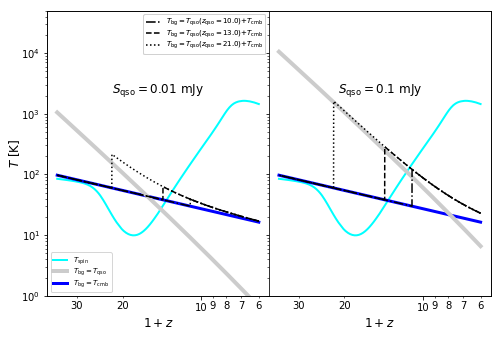

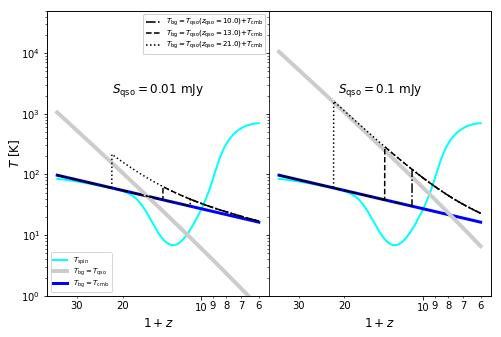

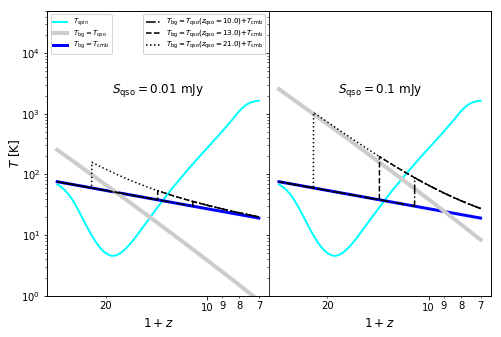

In [735]:
    if '1a' in plots:
        bgrad_colrs = ['blue', '0.8', 'black']
        zqso_ls = ['-.', '--', ':']
        ncols = beam_majax.size
        for mdlind, mdl in enumerate(modelnames):
            fig, axs = PLT.subplots(ncols=ncols, sharey=True, figsize=(ncols*3.5, 4.5), squeeze=False)
            if axs.size == 1:
                axs = axs.reshape(-1)
            for beamind, beamsize in enumerate(beam_majax):
                line_spin, = axs[0,beamind].plot(1+cube_redshifts[mdl], cube_mean_Tspins[mdl], ls='-', lw=2, color='cyan', label=r'$T_\mathrm{spin}$')
                line_cmb, = axs[0,beamind].plot(1+cube_redshifts[mdl], cosmo_parms[mdl].Tcmb0 * (1+cube_redshifts[mdl]), ls='-', lw=3, color=bgrad_colrs[0], label=r'$T_\mathrm{bg}=T_\mathrm{cmb}$')
                line_qso, = axs[0,beamind].plot(1+cube_redshifts[mdl], bg_temp_los[mdl][beamind,:], ls='-', lw=4, color=bgrad_colrs[1], label=r'$T_\mathrm{bg}=T_\mathrm{qso}$')
                line_cmb_qso = []
                for zqi, zq in enumerate(z_qso):
                    line_cmb_qso += axs[0,beamind].plot(1+cube_redshifts[mdl], net_bg_temp_los[mdl][beamind,zqi,:], ls=zqso_ls[zqi], lw=1.5, color=bgrad_colrs[2], label=r'$T_\mathrm{bg}=T_\mathrm{qso}(z_\mathrm{qso}=$'+'{0:.1f})'.format(zq) + r'$+T_\mathrm{cmb}$')
                line_cmb_qso = tuple(line_cmb_qso)
                if beamind == 0:
                    if mdl == 'Faint_galaxies_coldIGM':
                        first_legend = axs[0,beamind].legend(handles=(line_spin, line_qso, line_cmb), loc='upper left', shadow=False, fontsize=7, labelspacing=0)
                    else:
                        first_legend = axs[0,beamind].legend(handles=(line_spin, line_qso, line_cmb), loc='lower left', shadow=False, fontsize=7, labelspacing=0)
                    second_legend = axs[0,beamind].legend(handles=line_cmb_qso, loc='upper right', shadow=False, fontsize=7, labelspacing=0)
                    axs[0,beamind].add_artist(first_legend)
                    axs[0,beamind].add_artist(second_legend)

                axs[0,beamind].text(0.5, 0.75, r'$S_\mathrm{qso}=$'+'{0:.2g} mJy'.format((flux_obs[beamind]*beam_sa_0[beamind]).to('mJy').value[0]), transform=axs[0,beamind].transAxes, ha='center', va='top', fontsize=12)
                axs[0,beamind].set_ylim(ymin=1, ymax=5e4)
                axs[0,beamind].set_xscale('log')
                axs[0,beamind].set_xlabel(r'$1+z$', fontsize=12, weight='medium')
                axs[0,beamind].set_yscale('log')
#                 axs[0,beamind].set_xlim(32.5, 6.5)
                tickformatter = ticker.FuncFormatter(lambda y, _: '{:.16g}'.format(y))
                axs[0,beamind].xaxis.set_major_formatter(tickformatter)
                axs[0,beamind].xaxis.set_minor_formatter(tickformatter)
                axs[0,beamind].tick_params(axis='both', which='both', labelsize=10)
                axs[0,beamind].invert_xaxis()
 
            fig.subplots_adjust(hspace=0, wspace=0)
            fig.subplots_adjust(top=0.98, bottom=0.1, left=0.1, right=0.98)

            big_ax = fig.add_subplot(111)
            big_ax.set_facecolor('none') # matplotlib.__version__ >= 2.0.0
            # big_ax.set_axis_bgcolor('none') # matplotlib.__version__ < 2.0.0
            big_ax.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
            big_ax.set_xticks([])
            big_ax.set_yticks([])
#             big_ax.set_xlabel(r'$1+z$', fontsize=12, weight='medium', labelpad=20)
            big_ax.set_ylabel(r'$T$ [K]', fontsize=12, weight='medium', labelpad=25)

            PLT.savefig(figdir+'{0}_background_brightness_temperature.pdf'.format(mdl), bbox_inches=0)

## Plot 1b: Modification factors to brightness temperature fluctuations

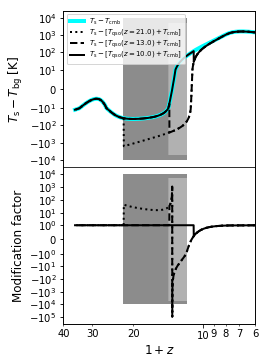

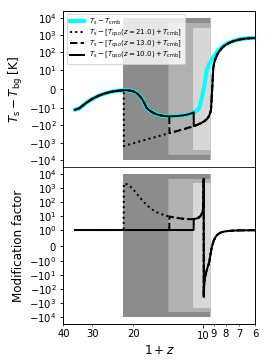

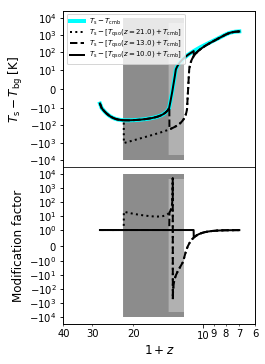

In [271]:
    if '1b' in plots:        
        zqso_ls = ['-', '--', ':']
        zqso_modification_colrs = ['0.85', '0.7', '0.55']
        shade_maxyval_zqso = [2.5e3, 5e3, 1e4]
        ncols = beam_majax.size
        mdl_simplified_names = ['Bright Gal.', 'Faint Gal.', 'Cold IGM']
        for mdlind, mdl in enumerate(modelnames):
            fig, axs = PLT.subplots(nrows=2, ncols=ncols, sharex=True, figsize=(ncols*3.5, 2*2.5), squeeze=False)
#             if axs.size == 1:
#                 axs = axs.reshape(-1)
            for beamind, beamsize in enumerate(beam_majax):
                increase_modification_ind_list = []
                for zqi, zq in enumerate(z_qso):
                    ind_increase_modification = NP.where(NP.abs(modification_factor[mdl][beamind,zqi,:]) > 1.0)[0]
                    increase_modification_ind_list += [ind_increase_modification]

                axs[0,beamind].plot(1+cube_redshifts[mdl], cube_mean_Tspins[mdl] - cosmo_parms[mdl].Tcmb0 * (1+cube_redshifts[mdl]), ls='-', lw=4, color='cyan', label=r'$T_\mathrm{s} - T_\mathrm{cmb}$')
                for zqi, zq in reversed(list(enumerate(z_qso))):
                    axs[0,beamind].vlines(1+cube_redshifts[mdl][increase_modification_ind_list[zqi]], -shade_maxyval_zqso[zqi], shade_maxyval_zqso[zqi], color=zqso_modification_colrs[zqi], alpha=0.5)
                    axs[0,beamind].plot(1+cube_redshifts[mdl], cube_mean_Tspins[mdl] - net_bg_temp_los[mdl][beamind,zqi,:], ls=zqso_ls[zqi], lw=2, color='black', label=r'$T_\mathrm{s} - [T_\mathrm{qso}(z=$'+'{0:.1f}'.format(zq)+r'$)+T_\mathrm{cmb}]$')
                    
                if beamind == 0:
                    axs[0,beamind].legend(loc='upper left', shadow=False, fontsize=7, labelspacing=0)
                                    
                axs[0,beamind].set_yscale('symlog', linthreshy=10)
                axs[0,beamind].set_xscale('log')
                axs[0,beamind].set_ylabel(r'$T_\mathrm{s} - T_\mathrm{bg}$ [K]', fontsize=12, weight='medium')
                
                for zqi, zq in reversed(list(enumerate(z_qso))):    
                    axs[1,beamind].vlines(1+cube_redshifts[mdl][increase_modification_ind_list[zqi]], -shade_maxyval_zqso[zqi], shade_maxyval_zqso[zqi], color=zqso_modification_colrs[zqi], alpha=0.5)
                    axs[1,beamind].plot(1+cube_redshifts[mdl], modification_factor[mdl][beamind,zqi,:], ls=zqso_ls[zqi], lw=2, color='black', label=r'CMB + $z_\mathrm{qso}=$'+'{0:.1f}'.format(zq))
                axs[1,beamind].set_yscale('symlog', linthreshy=1)
                axs[1,beamind].set_xscale('log')
                axs[1,beamind].set_ylabel('Modification factor', fontsize=12, weight='medium')
                
                tickformatter = ticker.FuncFormatter(lambda y, _: '{:.16g}'.format(y))
                axs[1,beamind].xaxis.set_major_formatter(tickformatter)
                axs[1,beamind].xaxis.set_minor_formatter(tickformatter)
                
                axs[0,beamind].set_xlim(40,6)
                axs[1,beamind].set_xlim(40,6)

                fig.subplots_adjust(hspace=0, wspace=0)
                
                fig.subplots_adjust(top=0.98)
                fig.subplots_adjust(bottom=0.11)
                fig.subplots_adjust(left=0.22)
                fig.subplots_adjust(right=0.98)

                big_ax = fig.add_subplot(111)
                big_ax.set_facecolor('none') # matplotlib.__version__ >= 2.0.0
                # big_ax.set_axis_bgcolor('none') # matplotlib.__version__ < 2.0.0
                big_ax.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
                big_ax.set_xticks([])
                big_ax.set_yticks([])
                big_ax.set_xlabel(r'$1+z$', fontsize=12, weight='medium', labelpad=20)

            PLT.savefig(figdir+'{0}_background_brightness_temperature_modification.pdf'.format(mdl), bbox_inches=0)

In [18]:
    for model in modelnames:
        d_los_comov_wts = NP.empty((z_pspec.size, cube_d_los_comov[model].size), dtype=NP.float_) # nz x nlos
        frac_width = DSP.window_N2width(n_window=None, shape=winshape, fftpow=fftpow, area_normalize=False, power_normalize=True)
        window_loss_factor = 1 / frac_width
        n_window = NP.round(window_loss_factor * (d_los_comov_width/boxresolutions[model]).decompose().value).astype(NP.int)
        d_los_comov_center_ind, ind_los_pixels, d_los_comov_offset = LKP.find_1NN(cube_d_los_comov[model].to('Mpc').value.reshape(-1,1), d_los_comov_center.to('Mpc').value.reshape(-1,1), distance_ULIM=0.51*boxresolutions[model].to('Mpc').value, remove_oob=True)
        sortind = NP.argsort(ind_los_pixels)
        d_los_comov_center_ind = d_los_comov_center_ind[sortind]
        ind_los_pixels = ind_los_pixels[sortind]
        d_los_comov_offset = d_los_comov_offset[sortind]
        n_window = n_window[sortind]

        for i,ind_los_pix in enumerate(ind_los_pixels):
            window = NP.sqrt(frac_width * n_window[i]) * DSP.window_fftpow(n_window[i], shape=winshape, fftpow=fftpow, centering=True, peak=None, area_normalize=False, power_normalize=True)
            window_lospix = cube_d_los_comov[model].to('Mpc').value[ind_los_pix] + boxresolutions[model].to('Mpc').value * (NP.arange(n_window[i]) - int(n_window[i]/2))
            ind_window_lospix, inds_lospix, dlos = LKP.find_1NN(cube_d_los_comov[model].to('Mpc').value.reshape(-1,1), window_lospix.reshape(-1,1), distance_ULIM=0.51*boxresolutions[model].to('Mpc').value, remove_oob=True)
            sind = NP.argsort(ind_window_lospix)
            ind_window_lospix = ind_window_lospix[sind]
            inds_lospix = inds_lospix[sind]
            dlos = dlos[sind]
            window = window[ind_window_lospix]
            window = NP.pad(window, ((inds_lospix.min(), cube_d_los_comov[model].to('Mpc').value.size-1-inds_lospix.max())), mode='constant', constant_values=((0.0,0.0)))
            d_los_comov_wts[i,:] = window # nz x nlos
        npad = int(cube_d_los_comov[model].size * pad)
        kprll_twosided = 2 * NP.pi * DSP.spectral_axis(cube_d_los_comov[model].size + npad, delx=boxresolutions[model].to('Mpc').value, use_real=False, shift=True) / U.Mpc 
        ndim_padtuple = [(0,0), (0,0), (0,0), (0,npad)] 
        wlinv_krnl = DSP.FT1D(NP.pad(d_los_comov_wts, [(0,0), (0,npad)], mode='constant'), ax=-1, inverse=False, use_real=False, shift=True) * boxresolutions[model]
        power_kprll_twosided = DSP.FT1D(NP.pad(d_los_comov_wts[NP.newaxis,:,NP.newaxis,:] * Tb_los_fluctuations_modified[model].value, ndim_padtuple, mode='constant'), ax=-1, inverse=False, use_real=False, shift=True) * boxresolutions[model] * Tb_los_fluctuations_modified[model].unit # nsa x nz x nxy x nlos
        power_kprll_twosided = NP.abs(power_kprll_twosided) ** 2 / d_los_comov_width.reshape(1,-1,1,1)
        downsample_factor = NP.min((cube_d_los_comov[model].size + npad) * boxresolutions[model] / d_los_comov_width).decompose().value

        # kprll_twosided = DSP.downsampler(kprll_twosided.value, downsample_factor, axis=-1, method='FFT') * kprll_twosided.unit
        # wlinv_kernel[model] = DSP.downsampler(wlinv_krnl.value, downsample_factor, axis=-1, method='FFT') * wlinv_krnl.unit
        # power_kprll_twosided = DSP.downsampler(power_kprll_twosided.value, downsample_factor, axis=-1, method='FFT') * power_kprll_twosided.unit

        negind = NP.arange(kprll_twosided.size//2 + 1)
        posind = kprll_twosided.size//2 + NP.arange((kprll_twosided.size+1)//2)
        nsamples_onesided[model] = NP.ones(kprll_twosided.size//2 + 1, dtype=NP.float)
        nsamples_onesided[model][1:(kprll_twosided.size + 1)//2] = 2

        kprll_onesided[model] = NP.abs(kprll_twosided[:kprll_twosided.size//2 + 1][::-1])
        power_folded = OPS.reverse(power_kprll_twosided[:,:,:,negind].value, axis=3) * power_kprll_twosided.unit
        power_folded[:,:,:,:(kprll_twosided.size+1)//2] = power_folded[:,:,:,:(kprll_twosided.size+1)//2] + power_kprll_twosided[:,:,:,posind]
        pspec_kprll_onesided[model] = 0.5 * NP.mean(power_folded, axis=2)
        pspec_kprll_onesided[model] = DSP.downsampler(pspec_kprll_onesided[model].value, downsample_factor, axis=-1, method='interp', kind='cubic') * pspec_kprll_onesided[model].unit
        kprll_onesided[model] = DSP.downsampler(kprll_onesided[model].value, downsample_factor, axis=-1, method='interp', kind='linear') * kprll_onesided[model].unit
        nsamples_onesided[model] = DSP.downsampler(nsamples_onesided[model], downsample_factor, axis=-1, method='interp', kind='linear')

        nmodes_onesided[model] = d_los_comov_width.reshape(-1,1) * kprll_onesided[model].reshape(1,-1) / (2 * NP.pi)
        nsamples_total_onesided[model] = nsamples_onesided[model].reshape(1,-1) * nmodes_onesided[model]
        freq_resolution = boxresolutions[model] * (cosmo_parms[model].H0 * rest_freq * cosmo_parms[model].efunc(z_pspec) ) / (FC.c * (1+z_pspec)**2)
        bw = d_los_comov_width * (cosmo_parms[model].H0 * rest_freq * cosmo_parms[model].efunc(z_pspec) ) / (FC.c * (1+z_pspec)**2)
        noise_power_std_kprll_onesided[model] = ((Tsys / NP.sqrt(2 * n_ant * (n_ant-1) * freq_resolution.reshape(1,-1,1) * t_half * (1.0-data_loss_factor))) * NP.sqrt((bw/freq_resolution).decompose().value.reshape(1,-1,1)) * freq_resolution.reshape(1,-1,1))**2 * d_los_comov_width.reshape(1,-1,1) / bw.reshape(1,-1,1)**2 / NP.sqrt(nsamples_onesided[model].reshape(1,1,-1)) # Factor 2 is for dual-pol, See SIRA II Eq.(9-23), d_los_comov_width/boxresolutions[model] or bw/freq_resolution is for number of cells going into the Fourier transform, Factor of d_los_comov_width comes due to the integral of the window function along LOS, NP.sqrt(nsamples_onesided[model]) is the reduction in noise in power spectrum units
        # The expression below is equivalent to the above but done in comoving space whereas the one above is in frequency space
        # noise_power_std_kprll_onesided[model] = ((Tsys / NP.sqrt(2 * n_ant * (n_ant-1) * freq_resolution.reshape(1,-1,1) * t_half)) * NP.sqrt((bw/freq_resolution).decompose().value.reshape(1,-1,1)) * boxresolutions[model])**2 / d_los_comov_width.reshape(1,-1,1) / NP.sqrt(nsamples_onesided[model].reshape(1,1,-1)) # Factor 2 is for dual-pol, See SIRA II Eq.(9-23), d_los_comov_width/boxresolutions[model] or bw/freq_resolution is for number of cells going into the Fourier transform, Factor of d_los_comov_width comes due to the integral of the window function along LOS, NP.sqrt(nsamples_onesided[model]) is the reduction in noise in power spectrum units
        basic_sampstd_kprll_onesided[model] = pspec_kprll_onesided[model] / NP.sqrt(nsamples_onesided[model].reshape(1,1,-1))
        basic_uncertainty_kprll_onesided[model] = NP.sqrt(basic_sampstd_kprll_onesided[model]**2 + noise_power_std_kprll_onesided[model]**2)
        nsamples_required[model] = (detection_threshold / (pspec_kprll_onesided[model] / basic_uncertainty_kprll_onesided[model]))**2

	Renormalized the shaping window to unit power.
	Renormalized the shaping window to unit power.
	Renormalized the shaping window to unit power.
Determining the interpolating function for downsampling.
Returning the downsampled data.
Determining the interpolating function for downsampling.
Returning the downsampled data.
Determining the interpolating function for downsampling.
Returning the downsampled data.
	Renormalized the shaping window to unit power.
	Renormalized the shaping window to unit power.
	Renormalized the shaping window to unit power.
Determining the interpolating function for downsampling.
Returning the downsampled data.
Determining the interpolating function for downsampling.
Returning the downsampled data.
Determining the interpolating function for downsampling.
Returning the downsampled data.
	Renormalized the shaping window to unit power.
	Renormalized the shaping window to unit power.
	Renormalized the shaping window to unit power.
Determining the interpolating func

In [920]:
    print(pspec_kprll_onesided[model].unit)
    print(noise_power_std_kprll_onesided[model].to('K2 Mpc').unit)

K2 Mpc
K2 Mpc


## Plot 2: Based on re-estimating the $\delta T_\mathrm{b}$ fluctuations from $T_\mathrm{spin}$ cubes instead of $\langle T_\mathrm{spin}\rangle$

In [18]:
if ('2' in plots) or ('2a' in plots) or ('2b' in plots) or ('2c' in plots):

    modelnames = plot_info['2']['models']
    beam_majax = NP.asarray(plot_info['2']['beam_majax']) * U.arcsec
    beam_sa_0 = (beam_majax**2).to('sr') # Beam solid angle at z=0
    fov_fwhm_rad = NP.radians(plot_info['2']['fov_fwhm']) # Field of view FWHM (in rad)
    fov_hwhm_dircos = NP.sin(0.5*fov_fwhm_rad) # Field of HWHM in direction-cosine units
    flux_density_obs = NP.asarray(plot_info['2']['flux_obs']) * U.mJy
    beam_majax = beam_majax * NP.ones(flux_density_obs.size)
    beam_sa_0 = beam_sa_0 * NP.ones(flux_density_obs.size)
    flux_obs = (flux_density_obs / beam_sa_0).reshape(-1,1)
    freq_obs = plot_info['2']['freq_obs'] * U.Hz
    bl_max = 1.22 * (FC.c / freq_obs) / (beam_majax.to('rad').value) # Max baseline corresponding to beam major axis
    spindex = plot_info['2']['spindex']
    z_qso = NP.asarray(plot_info['2']['z_qso'])
    z_pspec = NP.asarray(plot_info['2']['z_pspec'])
    frac_bw = plot_info['2']['frac_bw']
    rest_freq = plot_info['2']['rest_freq'] * U.Hz
    if rest_freq is None:
        rest_freq = CNST.rest_freq_HI * U.Hz
    nrand = plot_info['2']['nrand']
    randseed = plot_info['2']['seed']
    subbandinfo = plot_info['2']['subband']
    winshape = subbandinfo['shape']
    fftpow = subbandinfo['fftpow']
    pad = subbandinfo['pad']
    Tsys = plot_info['2']['Tsys'] * U.K
    n_ant = plot_info['2']['n_antennas']
    t_int = plot_info['2']['t_int'] * U.s
    t_half = 0.5 * t_int
    detection_threshold = plot_info['2']['snr_min']
    data_loss_factor = plot_info['2']['data_loss']    
    
    indir_pfx = plot_info['2']['indir_pfx']
    indir_sfx = plot_info['2']['indir_sfx']
    
    nrand = plot_info['2']['nrand']
    randseed = plot_info['2']['seed']
    rstate = NP.random.RandomState(randseed)
    
    qtys = plot_info['2']['qtys']

In [19]:
    print(beam_majax.to('arcsec'))
    print(fov_fwhm_rad)
    print(fov_hwhm_dircos)
    print(bl_max.to('m'))
    print(flux_obs)

[25. 25.] arcsec
3.141592653589793
1.0
[20117.51802179 20117.51802179] m
[[ 680722.72473844]
 [6807227.24738435]] mJy / sr


In [20]:
if ('2' in plots) or ('2a' in plots) or ('2b' in plots) or ('2c' in plots):

    sampled_los_qtys = {}    
    for modelind,model in enumerate(modelnames):
        sampled_los_qtys[model] = {}
        indir = indir_pfx + model + indir_sfx
        for qty in qtys:
            sampled_los_qtys[model][qty] = {}
            cubefile = indir + '{0}_light_cone.hdf5'.format(qty)
            cube, los_monopole, boxres, zmin, cosmo = read_HDF5_lightcone_cube(cubefile)
            rstate = NP.random.RandomState(randseed)
            pixind = rstate.randint(0, high=cube.shape[1]*cube.shape[2], size=nrand)
            sampled_los_qtys[model][qty]['cube'] = cube.reshape(cube.shape[0],-1)[:,pixind].T # (npix, nlos)
            sampled_los_qtys[model][qty]['monopole'] = los_monopole
        d_los_comov_min = cosmo.comoving_distance(zmin)
        sampled_los_qtys[model]['d_los_comov'] = d_los_comov_min + boxres * NP.arange(cube.shape[0]) # (nlos,)
        zgrid = NP.logspace(NP.log10(zmin-0.5), NP.log10(100.0), num=50000)
        d_los_comov_grid = cosmo.comoving_distance(zgrid)
        sampled_los_qtys[model]['redshifts'] = NP.interp(sampled_los_qtys[model]['d_los_comov'].to('Mpc').value, d_los_comov_grid.to('Mpc').value, zgrid)
#         sampled_los_qtys[model]['redshifts'] = NP.asarray([cosmology.z_at_value(cosmo.comoving_distance, d_los) for d_los in sampled_los_qtys[model]['d_los_comov']]) # (nlos,)
        sampled_los_qtys[model]['d_los_comov_center'] = cosmo.comoving_distance(z_pspec)
        zlo = z_pspec * (1 - 0.5 * frac_bw)
        zhi = z_pspec * (1 + 0.5 * frac_bw)
        d_los_comov_lo = cosmo.comoving_distance(zlo)
        d_los_comov_hi = cosmo.comoving_distance(zhi)
        sampled_los_qtys[model]['d_los_comov_width'] = d_los_comov_hi - d_los_comov_lo

        sampled_los_qtys[model]['boxres'] = boxres
        sampled_los_qtys[model]['pixang'] = boxres / cosmo.comoving_distance(sampled_los_qtys[model]['redshifts']) * U.rad # (nlos,)
        sampled_los_qtys[model]['pixsa'] = sampled_los_qtys[model]['pixang']**2
        sampled_los_qtys[model]['pixsa'] = sampled_los_qtys[model]['pixsa'].to('sr')
        sampled_los_qtys[model]['cosmo'] = copy.deepcopy(cosmo)
        sampled_los_qtys[model]['zmin'] = zmin
        
        sa_filling_factor_pix_beam = sampled_los_qtys[model]['pixsa'].reshape(1,-1) / beam_sa_0.reshape(-1,1) # (nbeam, nlos)
        sa_filling_factor_pix_beam[sa_filling_factor_pix_beam.decompose() <= 1.0] = 1.0 
        flux_los = flux_obs * (rest_freq/freq_obs)**spindex * (1+sampled_los_qtys[model]['redshifts'].reshape(1,-1))**(3.0-spindex) / sa_filling_factor_pix_beam # Correction for filling factor between pixel and beam, (nbeam, nlos)  
        sampled_los_qtys[model]['T_bg'] = {'cube': flux_los * (FC.c / rest_freq)**2 / (2 * FC.k_B)}  # (nbeam, nlos)
        sampled_los_qtys[model]['T_bg']['cube'] = sampled_los_qtys[model]['T_bg']['cube'].si.value * U.K  # (nbeam, nlos)
        
        los_ind_to_modify = sampled_los_qtys[model]['redshifts'].reshape(1,-1) <= z_qso.reshape(-1,1) # (nz_qso, nlos)
        sampled_los_qtys[model]['T_bg_net'] = {'cube': sampled_los_qtys[model]['T_bg']['cube'][:,NP.newaxis,:] * los_ind_to_modify[NP.newaxis,:,:].astype(NP.float) + sampled_los_qtys[model]['cosmo'].Tcmb0 * (1 + sampled_los_qtys[model]['redshifts'].reshape(1,1,-1))} # (nbeam, nz_qso, nlos)

        sampled_los_qtys[model]['delta_T_nomonopole'] = {}
        sampled_los_qtys[model]['delta_T_nomonopole']['cube'] = sampled_los_qtys[model]['delta_T']['cube'] - sampled_los_qtys[model]['delta_T']['monopole'].reshape(1,-1) # (npix, nlos)
        sampled_los_qtys[model]['delta_T_nomonopole']['cube'] = sampled_los_qtys[model]['delta_T_nomonopole']['cube'].to('K') # (npix, nlos)
 
        sampled_los_qtys[model]['modification'] = {}
        sampled_los_qtys[model]['modification']['cube'] = (sampled_los_qtys[model]['T_s']['cube'][NP.newaxis,NP.newaxis,:,:] - sampled_los_qtys[model]['T_bg_net']['cube'][:,:,NP.newaxis,:]) / (sampled_los_qtys[model]['T_s']['cube'][NP.newaxis,NP.newaxis,:,:] - sampled_los_qtys[model]['cosmo'].Tcmb0 * (1+sampled_los_qtys[model]['redshifts'].reshape(1,1,1,-1))) # (nbeam, nz_qso, npix, nlos)

        sampled_los_qtys[model]['delta_T_modified'] = {}
        sampled_los_qtys[model]['delta_T_modified_nomonopole'] = {}
        sampled_los_qtys[model]['delta_T_modified']['cube'] = sampled_los_qtys[model]['delta_T']['cube'][NP.newaxis,NP.newaxis,:,:] * sampled_los_qtys[model]['modification']['cube'] # (nbeam, nz_qs0, npix, nlos)
        sampled_los_qtys[model]['delta_T_modified']['cube'] = sampled_los_qtys[model]['delta_T_modified']['cube'].to('K') # (nbeam, nz_qso, npix, nlos)
        sampled_los_qtys[model]['delta_T_modified_nomonopole']['cube'] = sampled_los_qtys[model]['delta_T_modified']['cube'] - sampled_los_qtys[model]['delta_T']['monopole'].reshape(1,1,1,-1)
    

In [21]:
            print(subbandinfo)
            print('Redshifts of background quasars = {0}'.format(z_qso))
            print('Redshifts where HI PS is estimated = {0}'.format(z_pspec))
            print('Center of LOS comoving distance to PS redshift: {0}/h'.format(sampled_los_qtys[model]['d_los_comov_center']))
            print('Width of LOS comoving distance at PS redshift: {0}/h'.format(sampled_los_qtys[model]['d_los_comov_width']))

{'fftpow': 1.0, 'shape': 'bhw', 'pad': 1.0}
Redshifts of background quasars = [10. 13. 21.]
Redshifts where HI PS is estimated = [ 8.25 11.5  18.  ]
Center of LOS comoving distance to PS redshift: [6250.34249052 6746.00634124 7322.42661988] Mpc/h
Width of LOS comoving distance at PS redshift: [105.50351902  93.67938598  78.24485193] Mpc/h


In [23]:
        randpixind = NP.arange(10000)
#         losind = NP.arange(1783,1856)
        losind = NP.arange(764,862)
        mltdimind_0 = NP.ix_(randpixind,losind)
        mltdimind_1 = NP.ix_([0],[0],randpixind,losind)
        print(mltdimind_0)
        print(randpixind)
        print(sampled_los_qtys[model]['redshifts'][losind])
        print(sampled_los_qtys[model]['modification']['cube'].shape)
        print(NP.abs(sampled_los_qtys[model]['modification']['cube'][mltdimind_1]).min())
        print(NP.abs(sampled_los_qtys[model]['modification']['cube'][mltdimind_1]).max())
#         print(sampled_los_qtys[model]['modification']['cube'][mltdimind_1])
        print(sampled_los_qtys[model]['delta_T']['cube'][mltdimind_0].min())
        print(sampled_los_qtys[model]['delta_T']['cube'][mltdimind_0].max())
        print(sampled_los_qtys[model]['delta_T_nomonopole']['cube'][mltdimind_0].to('mK').min())
        print(sampled_los_qtys[model]['delta_T_nomonopole']['cube'][mltdimind_0].to('mK').max())
        print(sampled_los_qtys[model]['delta_T_modified']['cube'][mltdimind_1].to('mK').min())
        print(sampled_los_qtys[model]['delta_T_modified']['cube'][mltdimind_1].to('mK').max())
        print(sampled_los_qtys[model]['delta_T_modified_nomonopole']['cube'][mltdimind_1].to('mK').min())
        print(sampled_los_qtys[model]['delta_T_modified_nomonopole']['cube'][mltdimind_1].to('mK').max())
#         print(sampled_los_qtys[model]['modification']['cube'].squeeze())
#         print(sampled_los_qtys[model]['T_s']['cube'])
#         print(sampled_los_qtys[model]['delta_T_modified']['cube'].shape)
#         print(sampled_los_qtys[model]['delta_T_modified_nomonopole']['cube'].shape)

(array([[   0],
       [   1],
       [   2],
       ...,
       [9997],
       [9998],
       [9999]]), array([[764, 765, 766, 767, 768, 769, 770, 771, 772, 773, 774, 775, 776,
        777, 778, 779, 780, 781, 782, 783, 784, 785, 786, 787, 788, 789,
        790, 791, 792, 793, 794, 795, 796, 797, 798, 799, 800, 801, 802,
        803, 804, 805, 806, 807, 808, 809, 810, 811, 812, 813, 814, 815,
        816, 817, 818, 819, 820, 821, 822, 823, 824, 825, 826, 827, 828,
        829, 830, 831, 832, 833, 834, 835, 836, 837, 838, 839, 840, 841,
        842, 843, 844, 845, 846, 847, 848, 849, 850, 851, 852, 853, 854,
        855, 856, 857, 858, 859, 860, 861]]))
[   0    1    2 ... 9997 9998 9999]
[8.01435414 8.01967552 8.0250016  8.0303324  8.0356679  8.04100811
 8.04635306 8.05170273 8.05705714 8.06241628 8.06778018 8.07314882
 8.07852222 8.08390038 8.08928331 8.09467102 8.1000635  8.10546077
 8.11086283 8.11626969 8.12168134 8.12709781 8.1325191  8.1379452
 8.14337612 8.14881188 8.15425247 8


Bright_galaxies_fiducial_1024

Faint_galaxies_fiducial_1024


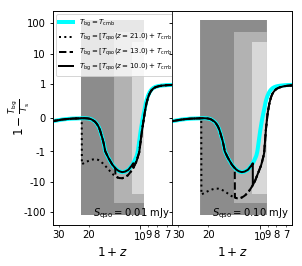

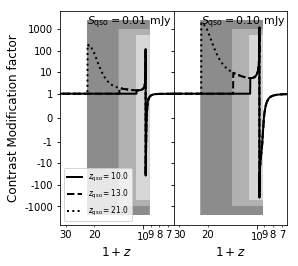

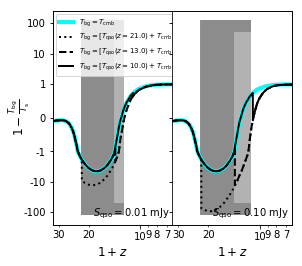

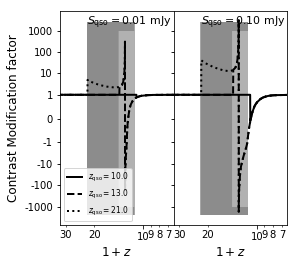

In [26]:
    if '2a' in plots:        
        zqso_ls = ['-', '--', ':']
        zqso_modification_colrs = ['lightblue', 'lightgreen', 'lightsalmon']
        zqso_mean_modification_colrs = ['blue', 'green', 'red']
        shade_maxyval_zqso = [0.5e3, 1e3, 2.5e3]
        zqso_modification_shade_colrs = ['0.85', '0.7', '0.55']
        ncols = beam_majax.size
        mdl_simplified_names = ['Bright Gal.', 'Faint Gal.', 'Cold IGM']
        for mdlind, mdl in enumerate(modelnames):
            print('\n{0}\n============================='.format(mdl))
            temperature_contrast_factor_orig = 1.0 - sampled_los_qtys[model]['cosmo'].Tcmb0 * (1 + sampled_los_qtys[model]['redshifts'].reshape(1,-1)) / sampled_los_qtys[mdl]['T_s']['cube'] # (npix, nlos)
            temperature_contrast_factor_orig = temperature_contrast_factor_orig.decompose().value # (npix, nlos)
            temperature_contrast_factor_modified = 1.0 - sampled_los_qtys[model]['T_bg_net']['cube'][:,:,NP.newaxis,:] / sampled_los_qtys[mdl]['T_s']['cube'][NP.newaxis,NP.newaxis,:,:] # (nbeam, nz_qso, npix, nlos)
            temperature_contrast_factor_modified = temperature_contrast_factor_modified.decompose().value # (nbeam, nz_qso, npix, nlos)

#             mean_modification_factor = 10**NP.mean(NP.log10(sampled_los_qtys[model]['modification']['cube']), axis=2) # (nbeam, nz_qso, nlos)
            mean_modification_factor = NP.std(sampled_los_qtys[mdl]['modification']['cube'], axis=2) # (nbeam, nz_qso, nlos)
            std_modification_factor = NP.std(sampled_los_qtys[mdl]['modification']['cube'], axis=2) # (nbeam, nz_qso, nlos)

            mean_modification_factor_v2 = NP.mean(temperature_contrast_factor_modified, axis=-2) / NP.mean(temperature_contrast_factor_orig, axis=-2) # (nbeam, nz_qso, nlos)

            fig, axs = PLT.subplots(ncols=ncols, sharey=True, figsize=(ncols*2, 3.5), squeeze=False)
            if axs.size == 1:
                axs = axs.reshape(-1)

            for beamind, beamsize in enumerate(beam_majax):
                increase_modification_ind_list = []
                for zqi, zq in enumerate(z_qso):
                    ind_increase_modification = NP.where(NP.abs(mean_modification_factor_v2[beamind,zqi,:]) > 1.0)[0]
                    increase_modification_ind_list += [ind_increase_modification]
                for zqi, zq in reversed(list(enumerate(z_qso))):
                    axs[0,beamind].vlines(1+sampled_los_qtys[mdl]['redshifts'][increase_modification_ind_list[zqi]], -shade_maxyval_zqso[zqi]/20, shade_maxyval_zqso[zqi]/20, color=zqso_modification_shade_colrs[zqi])
                axs[0,beamind].plot(1+sampled_los_qtys[mdl]['redshifts'], NP.mean(temperature_contrast_factor_orig, axis=-2), ls='-', lw=4, color='cyan', label=r'$T_\mathrm{bg}=T_\mathrm{cmb}$')
                for zqi, zq in reversed(list(enumerate(z_qso))):    
#                     axs[0,beamind].fill_between(1+sampled_los_qtys[mdl]['redshifts'], mean_modification_factor[beamind,zqi,:]-std_modification_factor[beamind,zqi,:], mean_modification_factor[beamind,zqi,:]+std_modification_factor[beamind,zqi,:], color=zqso_modification_colrs[zqi])
#                     axs[0,beamind].plot(1+sampled_los_qtys[mdl]['redshifts'], mean_modification_factor[beamind,zqi,:], lw=2, color=zqso_mean_modification_colrs[zqi], label=r'$z_\mathrm{qso}=$'+'{0:.1f}'.format(zq))
                    axs[0,beamind].plot(1+sampled_los_qtys[mdl]['redshifts'], NP.mean(temperature_contrast_factor_modified[beamind,zqi,:,:], axis=-2), ls=zqso_ls[zqi], lw=2, color='black', label=r'$T_\mathrm{bg} = [T_\mathrm{qso}(z=$'+'{0:.1f}'.format(zq)+r'$)+T_\mathrm{cmb}]$')
                        
                axs[0,beamind].set_yscale('symlog', linthreshy=1.0)
                axs[0,beamind].set_xscale('log')
                axs[0,beamind].set_xlim(32.5,6.5)
                axs[0,beamind].set_xlabel(r'$1+z$', fontsize=12, weight='medium')
                
                if beamind == 0:
                    axs[0,beamind].set_ylabel(r'$1-\frac{T_\mathrm{bg}}{T_\mathrm{s}}$', fontsize=12, weight='medium', labelpad=-10)
                    legend = axs[0,beamind].legend(loc='upper left', shadow=False, fontsize=7)

                axs[0,beamind].text(0.98, 0.02, r'$S_\mathrm{qso}=$'+'{0:.2f} mJy'.format((flux_obs[beamind]*beam_sa_0[beamind]).to('mJy').value[0]), transform=axs[0,beamind].transAxes, ha='right', va='bottom', fontsize=10)
                
                tickformatter = ticker.FuncFormatter(lambda x, _: '{:.6g}'.format(x))
                axs[0,beamind].xaxis.set_major_formatter(tickformatter)
                axs[0,beamind].xaxis.set_minor_formatter(tickformatter)
                axs[0,beamind].yaxis.set_major_formatter(tickformatter)
#                 axs[0,beamind].yaxis.set_minor_formatter(tickformatter)   
                
                fig.subplots_adjust(hspace=0, wspace=0.0)
                
                fig.subplots_adjust(top=0.98)
                fig.subplots_adjust(bottom=0.13)
                fig.subplots_adjust(left=0.15)
                fig.subplots_adjust(right=0.98)

                big_ax = fig.add_subplot(111)
                big_ax.set_facecolor('none') # matplotlib.__version__ >= 2.0.0
                # big_ax.set_axis_bgcolor('none') # matplotlib.__version__ < 2.0.0
                big_ax.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
                big_ax.set_xticks([])
                big_ax.set_yticks([])
#                 big_ax.set_xlabel(r'$1+z$', fontsize=12, weight='medium', labelpad=20)
            PLT.savefig(figdir+'{0}_mean_temperature_contrast_factor.pdf'.format(mdl), bbox_inches=0)

            ###############################

            fig, axs = PLT.subplots(ncols=ncols, sharey=True, figsize=(ncols*2, 3.5), squeeze=False)
            if axs.size == 1:
                axs = axs.reshape(-1)

            for beamind, beamsize in enumerate(beam_majax):                
                for zqi, zq in reversed(list(enumerate(z_qso))):
                    axs[0,beamind].vlines(1+sampled_los_qtys[mdl]['redshifts'][increase_modification_ind_list[zqi]], -shade_maxyval_zqso[zqi], shade_maxyval_zqso[zqi], color=zqso_modification_shade_colrs[zqi], alpha=0.5)
                for zqi, zq in enumerate(z_qso):
#                     axs[0,beamind].plot(1+sampled_los_qtys[mdl]['redshifts'], mean_modification_factor_v2[beamind,zqi,:], ls=zqso_ls[zqi], lw=2, color='black', label=r'CMB + $z_\mathrm{qso}=$'+'{0:.1f}'.format(zq))
                    axs[0,beamind].plot(1+sampled_los_qtys[mdl]['redshifts'], mean_modification_factor_v2[beamind,zqi,:], ls=zqso_ls[zqi], lw=2, color='black', label=r'$z_\mathrm{qso}=$'+'{0:.1f}'.format(zq))

                axs[0,beamind].set_yscale('symlog', linthreshy=1)
#                 axs[0,beamind].set_yscale('log')
                axs[0,beamind].set_xscale('log')
                axs[0,beamind].set_xlim(32.5,6.5)
                axs[0,beamind].set_xlabel(r'$1+z$', fontsize=12, weight='medium')
                if beamind == 0:
                    axs[0,beamind].set_ylabel('Contrast Modification factor', fontsize=12, weight='medium')
                    legend = axs[0,beamind].legend(loc='lower left', shadow=False, fontsize=7.5)

                axs[0,beamind].text(0.98, 0.98, r'$S_\mathrm{qso}=$'+'{0:.2f} mJy'.format((flux_obs[beamind]*beam_sa_0[beamind]).to('mJy').value[0]), transform=axs[0,beamind].transAxes, ha='right', va='top', fontsize=11)
                
#                 tickformatter = ticker.FuncFormatter(lambda y, _: '{:.16g}'.format(y))
                axs[0,beamind].xaxis.set_major_formatter(tickformatter)
                axs[0,beamind].xaxis.set_minor_formatter(tickformatter)
                axs[0,beamind].yaxis.set_major_formatter(tickformatter)
#                 axs[0,beamind].yaxis.set_minor_formatter(tickformatter)   
                
                fig.subplots_adjust(hspace=0, wspace=0)
                
                fig.subplots_adjust(top=0.98)
                fig.subplots_adjust(bottom=0.13)
                fig.subplots_adjust(left=0.19)
                fig.subplots_adjust(right=0.98)

#                 big_ax = fig.add_subplot(111)
#                 big_ax.set_facecolor('none') # matplotlib.__version__ >= 2.0.0
#                 # big_ax.set_axis_bgcolor('none') # matplotlib.__version__ < 2.0.0
#                 big_ax.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
#                 big_ax.set_xticks([])
#                 big_ax.set_yticks([])
#                 big_ax.set_xlabel(r'$1+z$', fontsize=12, weight='medium', labelpad=20)
            PLT.savefig(figdir+'{0}_mean_temperature_contrast_modification_factor.pdf'.format(mdl), bbox_inches=0)
            

/lustre/aoc/users/nthyagar/projects/21cmforest/figures/Bright_galaxies_fiducial_1024_Tb_pixel_scatter_distribution.pdf
/lustre/aoc/users/nthyagar/projects/21cmforest/figures/Faint_galaxies_fiducial_1024_Tb_pixel_scatter_distribution.pdf


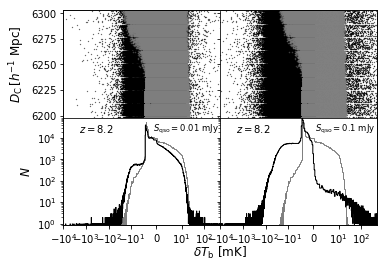

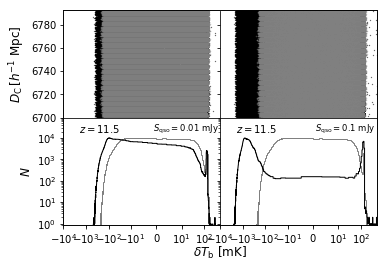

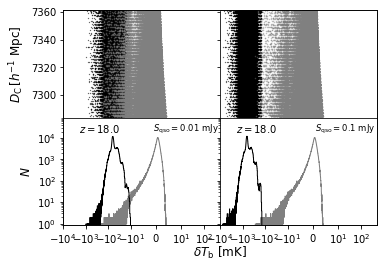

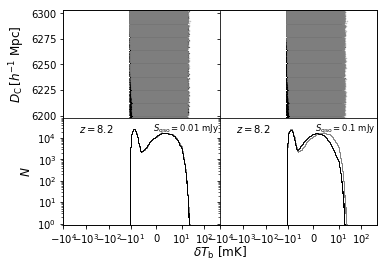

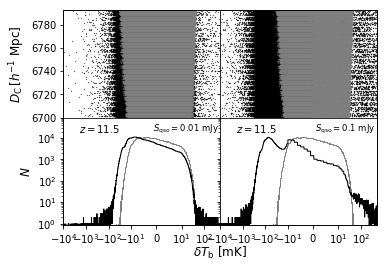

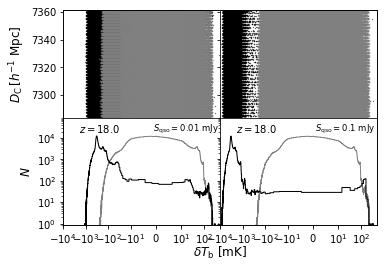

In [28]:
    if '2b' in plots:
        ncols = z_qso.size
#         nrows = beam_majax.size
        nrows = 2
        for mdlind, mdl in enumerate(modelnames):
            for zqi, zq in enumerate(z_qso):
                los_ind = NP.where(NP.abs(sampled_los_qtys[mdl]['d_los_comov'] - sampled_los_qtys[mdl]['cosmo'].comoving_distance(z_pspec[zqi])) <= 0.5 * sampled_los_qtys[mdl]['d_los_comov_width'][zqi])[0]

                fig, axs = PLT.subplots(nrows=nrows, ncols=beam_majax.size, sharex=True, figsize=(ncols*1.75, 3.5), squeeze=False)
                if axs.size == 1:
                    axs = axs.reshape(-1)
                for beamind, beamsize in enumerate(beam_majax):
                    
                    axs[0,beamind].plot(sampled_los_qtys[mdl]['delta_T_modified_nomonopole']['cube'][beamind,zqi,:,los_ind].to('mK').value.reshape(-1), (NP.zeros(nrand).reshape(-1,1)+sampled_los_qtys[mdl]['d_los_comov'][los_ind].reshape(1,-1)).ravel(), ls='none', marker='.', ms=0.5, color='black')
                    axs[0,beamind].plot(sampled_los_qtys[mdl]['delta_T_nomonopole']['cube'][:,los_ind].to('mK').value.reshape(-1), (NP.zeros(nrand).reshape(-1,1)+sampled_los_qtys[mdl]['d_los_comov'][los_ind].reshape(1,-1)).ravel(), ls='none', marker='.', ms=1, color='gray', alpha=0.5)
                    dnsty_orig, be_orig, patches = axs[1,beamind].hist(sampled_los_qtys[mdl]['delta_T_nomonopole']['cube'][:,los_ind].to('mK').value.reshape(-1), bins='auto', density=False, log=True, histtype='step', color='gray')
                    dnsty, be, patches = axs[1,beamind].hist(sampled_los_qtys[mdl]['delta_T_modified_nomonopole']['cube'][beamind,zqi,:,los_ind].to('mK').value.reshape(-1), bins='auto', density=False, log=True, histtype='step', color='black')
#                     print(be)
#                     print(dnsty)
#                     print(los_ind)
#                     print(sampled_los_qtys[mdl]['d_los_comov'][los_ind])

                    axs[0,beamind].set_xlim(-1e4,5e2)  
                    axs[0,beamind].set_ylim(sampled_los_qtys[mdl]['d_los_comov'][los_ind].to('Mpc').value.min(), sampled_los_qtys[mdl]['d_los_comov'][los_ind].to('Mpc').value.max()) 
                    axs[0,beamind].set_xscale('symlog', linthreshx=10.0)
                    axs[1,beamind].set_ylim(0.9,9e4)
                    if beamind == 0:
                        axs[0,beamind].set_ylabel(r'$D_\mathrm{C}\,[h^{-1}$ Mpc]', fontsize=12, weight='medium')
                        axs[1,beamind].set_ylabel(r'$N$', fontsize=12, weight='medium')
                    else:
#                         empty_tick_labels = ['']*len(axs[0,0].get_yticklabels())
#                         axs[0,beamind].set_yticklabels(empty_tick_labels)

                        axs[0,beamind].yaxis.set_major_formatter(ticker.NullFormatter())
                        axs[1,beamind].yaxis.set_major_formatter(ticker.NullFormatter())
                    axs[1,beamind].text(0.1, 0.95, r'$z=$'+'{0:.1f}'.format(z_pspec[zqi]), transform=axs[1,beamind].transAxes, ha='left', va='top')
                    axs[1,beamind].text(0.99, 0.95, r'$S_\mathrm{qso}=$'+'{0:.2g} mJy'.format((flux_obs[beamind]*beam_sa_0[beamind]).to('mJy').value[0]), transform=axs[1,beamind].transAxes, ha='right', va='top', fontsize=8.5)

                fig.subplots_adjust(hspace=0, wspace=0)
                fig.subplots_adjust(top=0.98)
                fig.subplots_adjust(bottom=0.13)
                fig.subplots_adjust(left=0.15)
                fig.subplots_adjust(right=0.98)

                big_ax = fig.add_subplot(111)
                big_ax.set_facecolor('none') # matplotlib.__version__ >= 2.0.0
                # big_ax.set_axis_bgcolor('none') # matplotlib.__version__ < 2.0.0
                big_ax.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
                big_ax.set_xticks([])
                big_ax.set_yticks([])
                big_ax.set_xlabel(r'$\delta T_\mathrm{b}$ [mK]', fontsize=12, weight='medium', labelpad=20)
#             PLT.savefig(figdir+'{0}_Tb_pixel_scatter_distribution.pdf'.format(mdl), bbox_inches=0)
            print(figdir+'{0}_Tb_pixel_scatter_distribution.pdf'.format(mdl))
                

/lustre/aoc/users/nthyagar/projects/21cmforest/figures/delta_T_temp_pre_post_modification_z_18.0_Bright_galaxies_fiducial_1024.pdf
/lustre/aoc/users/nthyagar/projects/21cmforest/figures/delta_T_temp_pre_post_modification_z_18.0_Faint_galaxies_fiducial_1024.pdf


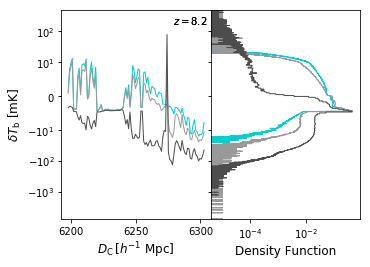

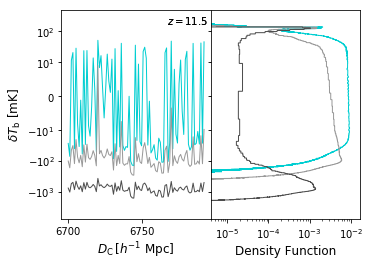

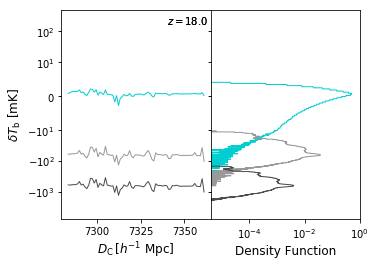

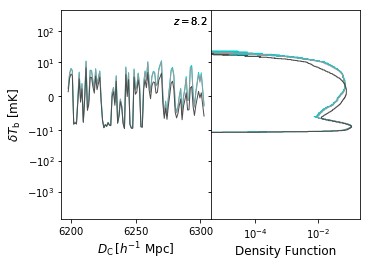

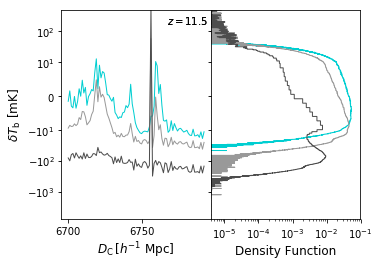

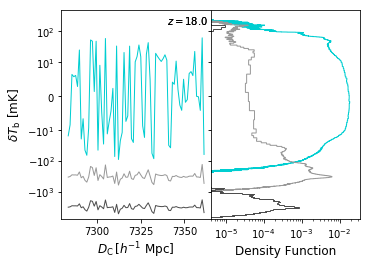

In [29]:
    if '2b' in plots:
        delta_T_range = [-8e3, 5e2]
        ncols = 2
#         nrows = beam_majax.size
        nrows = 1
        bgrad_colrs = ['darkturquoise']
        bgrad_colrs += map(str, NP.linspace(0.6, 0.3, beam_majax.size).tolist())
        for mdlind, mdl in enumerate(modelnames):
            for zqi, zq in enumerate(z_qso):
                los_ind = NP.where(NP.abs(sampled_los_qtys[mdl]['d_los_comov'] - sampled_los_qtys[mdl]['cosmo'].comoving_distance(z_pspec[zqi])) <= 0.5 * sampled_los_qtys[mdl]['d_los_comov_width'][zqi])[0]
                fig, axs = PLT.subplots(nrows=nrows, ncols=ncols, sharey=True, figsize=(ncols*2.5, 3.5), squeeze=False)
                if axs.size == 1:
                    axs = axs.reshape(-1)
                axs[0,0].plot(sampled_los_qtys[mdl]['d_los_comov'][los_ind], sampled_los_qtys[mdl]['delta_T_nomonopole']['cube'][nrand//500,los_ind].to('mK').value, ls='-', lw=1, color=bgrad_colrs[0], )
                dnsty_orig, be_orig, patches = axs[0,1].hist(sampled_los_qtys[mdl]['delta_T_nomonopole']['cube'][:,los_ind].to('mK').value.reshape(-1), bins='sqrt', range=delta_T_range, density=True, log=True, orientation='horizontal', histtype='step', color=bgrad_colrs[0])
                for beamind, beamsize in enumerate(beam_majax):
                    axs[0,0].plot(sampled_los_qtys[mdl]['d_los_comov'][los_ind], sampled_los_qtys[mdl]['delta_T_modified_nomonopole']['cube'][beamind,zqi,nrand//500,los_ind].to('mK').value, ls='-', lw=1, color=bgrad_colrs[beamind+1])
                    dnsty, be, patches = axs[0,1].hist(sampled_los_qtys[mdl]['delta_T_modified_nomonopole']['cube'][beamind,zqi,:,los_ind].to('mK').value.reshape(-1), bins='auto', range=delta_T_range, density=True, log=True, orientation='horizontal', histtype='step', color=bgrad_colrs[beamind+1])
                    axs[0,0].set_ylim(delta_T_range)
                    axs[0,0].set_yscale('symlog', linthreshy=10.0)
                    axs[0,0].text(0.98, 0.98, r'$z=$'+'{0:.1f}'.format(z_pspec[zqi]), transform=axs[0,0].transAxes, ha='right', va='top')
                    axs[0,0].set_ylabel(r'$\delta T_\mathrm{b}$ [mK]', fontsize=12, weight='medium')
                    axs[0,0].set_xlabel(r'$D_\mathrm{C}\,[h^{-1}$ Mpc]', fontsize=12, weight='medium')
                    axs[0,1].set_xlim(4e-6,None)
                    axs[0,1].set_xlabel('Density Function', fontsize=12, weight='medium')
                fig.subplots_adjust(hspace=0, wspace=0)
                fig.subplots_adjust(top=0.98)
                fig.subplots_adjust(bottom=0.15)
                fig.subplots_adjust(left=0.15)
                fig.subplots_adjust(right=0.98)

#                 big_ax = fig.add_subplot(111)
#                 big_ax.set_facecolor('none') # matplotlib.__version__ >= 2.0.0
#                 # big_ax.set_axis_bgcolor('none') # matplotlib.__version__ < 2.0.0
#                 big_ax.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
#                 big_ax.set_xticks([])
#                 big_ax.set_yticks([])
#                 big_ax.set_xlabel(r'$\delta T_\mathrm{b}$ [mK]', fontsize=12, weight='medium', labelpad=20)

            PLT.savefig(figdir+'delta_T_temp_pre_post_modification_z_{0:.1f}_{1}_.pdf'.format(z_pspec[zqi],mdl), bbox_inches=0)
            print(figdir+'delta_T_temp_pre_post_modification_z_{0:.1f}_{1}.pdf'.format(z_pspec[zqi],mdl)) 

In [30]:
    if '2c' in plots:
        
        pspec_kprll_onesided = {}
        pspec_kprll_onesided_orig = {}
        noise_power_std_kprll_onesided = {}
        nmodes_onesided = {}
        nmodes_total_onesided = {}
        wlinv_kernel = {}
        kprll_onesided = {}
        nsamples_onesided = {}
        nsamples_required = {}
        nsamples_required_orig = {}
        nsamples_total_onesided = {}
        basic_sampstd_kprll_onesided = {}
        basic_uncertainty_kprll_onesided = {}        
        basic_sampstd_kprll_onesided_orig = {}
        basic_uncertainty_kprll_onesided_orig = {} 
        fg_wedge_boundary = {}
        for model in modelnames:
            tau_wedge_boundary = bl_max * fov_hwhm_dircos / FC.c # FD wedge boundary in delay units
            d_los_comov_wts = NP.empty((z_pspec.size, sampled_los_qtys[model]['d_los_comov'].size), dtype=NP.float_) # nz x nlos
            frac_width = DSP.window_N2width(n_window=None, shape=winshape, fftpow=fftpow, area_normalize=False, power_normalize=True)
            window_loss_factor = 1 / frac_width
            n_window = NP.round(window_loss_factor * (sampled_los_qtys[model]['d_los_comov_width']/sampled_los_qtys[model]['boxres']).decompose().value).astype(NP.int)
            d_los_comov_center_ind, ind_los_pixels, d_los_comov_offset = LKP.find_1NN(sampled_los_qtys[model]['d_los_comov'].to('Mpc').value.reshape(-1,1), sampled_los_qtys[model]['d_los_comov_center'].to('Mpc').value.reshape(-1,1), distance_ULIM=0.51*sampled_los_qtys[model]['boxres'].to('Mpc').value, remove_oob=True)
            sortind = NP.argsort(ind_los_pixels)
            d_los_comov_center_ind = d_los_comov_center_ind[sortind]
            ind_los_pixels = ind_los_pixels[sortind]
            d_los_comov_offset = d_los_comov_offset[sortind]
            n_window = n_window[sortind]

            for i,ind_los_pix in enumerate(ind_los_pixels):
                window = NP.sqrt(frac_width * n_window[i]) * DSP.window_fftpow(n_window[i], shape=winshape, fftpow=fftpow, centering=True, peak=None, area_normalize=False, power_normalize=True)
                window_lospix = sampled_los_qtys[model]['d_los_comov'].to('Mpc').value[ind_los_pix] + sampled_los_qtys[model]['boxres'].to('Mpc').value * (NP.arange(n_window[i]) - int(n_window[i]/2))
                ind_window_lospix, inds_lospix, dlos = LKP.find_1NN(sampled_los_qtys[model]['d_los_comov'].to('Mpc').value.reshape(-1,1), window_lospix.reshape(-1,1), distance_ULIM=0.51*sampled_los_qtys[model]['boxres'].to('Mpc').value, remove_oob=True)
                sind = NP.argsort(ind_window_lospix)
                ind_window_lospix = ind_window_lospix[sind]
                inds_lospix = inds_lospix[sind]
                dlos = dlos[sind]
                window = window[ind_window_lospix]
                window = NP.pad(window, ((inds_lospix.min(), sampled_los_qtys[model]['d_los_comov'].to('Mpc').value.size-1-inds_lospix.max())), mode='constant', constant_values=((0.0,0.0)))
                d_los_comov_wts[i,:] = window # nz x nlos
            npad = int(sampled_los_qtys[model]['d_los_comov'].size * pad)
            kprll_twosided = 2 * NP.pi * DSP.spectral_axis(sampled_los_qtys[model]['d_los_comov'].size + npad, delx=sampled_los_qtys[model]['boxres'].to('Mpc').value, use_real=False, shift=True) / U.Mpc 
            ndim_padtuple = [(0,0), (0,0), (0,0), (0,npad)] 
            wlinv_krnl = DSP.FT1D(NP.pad(d_los_comov_wts, [(0,0), (0,npad)], mode='constant'), ax=-1, inverse=False, use_real=False, shift=True) * sampled_los_qtys[model]['boxres']
            
            fg_wedge_boundary[model] = []
            for zpsi, zps in enumerate(z_pspec):
                dkprll_dev_dtau_jacobian = DS.dkprll_deta(zps, cosmo=sampled_los_qtys[mdl]['cosmo']) * (1 / U.Mpc) / U.s # in Mpc^-1 s^-1
                fg_wedge_boundary[model] += [tau_wedge_boundary * dkprll_dev_dtau_jacobian]
            fg_wedge_boundary[model] = NP.asarray(fg_wedge_boundary[model])
            
            power_kprll_twosided = DSP.FT1D(NP.pad(d_los_comov_wts[NP.newaxis,:,NP.newaxis,:] * sampled_los_qtys[model]['delta_T_modified_nomonopole']['cube'].to('mK').value, ndim_padtuple, mode='constant'), ax=-1, inverse=False, use_real=False, shift=True) * sampled_los_qtys[model]['boxres'] * U.mK # nbeam x nz_qso x npix x nlos
            power_kprll_twosided = NP.abs(power_kprll_twosided) ** 2 / sampled_los_qtys[model]['d_los_comov_width'].reshape(1,-1,1,1)

            power_kprll_twosided_orig = DSP.FT1D(NP.pad(d_los_comov_wts[NP.newaxis,:,NP.newaxis,:] * sampled_los_qtys[model]['delta_T_nomonopole']['cube'].to('mK').value, ndim_padtuple, mode='constant'), ax=-1, inverse=False, use_real=False, shift=True) * sampled_los_qtys[model]['boxres'] * U.mK # nbeam x nz_qso x npix x nlos
            power_kprll_twosided_orig = NP.abs(power_kprll_twosided_orig) ** 2 / sampled_los_qtys[model]['d_los_comov_width'].reshape(1,-1,1,1)
            
            downsample_factor = NP.min((sampled_los_qtys[model]['d_los_comov'].size + npad) * sampled_los_qtys[model]['boxres'] / sampled_los_qtys[model]['d_los_comov_width']).decompose().value

            # kprll_twosided = DSP.downsampler(kprll_twosided.value, downsample_factor, axis=-1, method='FFT') * kprll_twosided.unit
            # wlinv_kernel[model] = DSP.downsampler(wlinv_krnl.value, downsample_factor, axis=-1, method='FFT') * wlinv_krnl.unit
            # power_kprll_twosided = DSP.downsampler(power_kprll_twosided.value, downsample_factor, axis=-1, method='FFT') * power_kprll_twosided.unit

            negind = NP.arange(kprll_twosided.size//2 + 1)
            posind = kprll_twosided.size//2 + NP.arange((kprll_twosided.size+1)//2)
            nsamples_onesided[model] = NP.ones(kprll_twosided.size//2 + 1, dtype=NP.float)
            nsamples_onesided[model][1:(kprll_twosided.size + 1)//2] = 2.0

            kprll_onesided[model] = NP.abs(kprll_twosided[:kprll_twosided.size//2 + 1][::-1])
            kprll_onesided[model] = DSP.downsampler(kprll_onesided[model].value, downsample_factor, axis=-1, method='interp', kind='linear') * kprll_onesided[model].unit
            nsamples_onesided[model] = DSP.downsampler(nsamples_onesided[model], downsample_factor, axis=-1, method='interp', kind='linear')

            power_folded = OPS.reverse(power_kprll_twosided[:,:,:,negind].value, axis=3) * power_kprll_twosided.unit
            power_folded[:,:,:,:(kprll_twosided.size+1)//2] = power_folded[:,:,:,:(kprll_twosided.size+1)//2] + power_kprll_twosided[:,:,:,posind]
            pspec_kprll_onesided[model] = 0.5 * NP.median(power_folded, axis=-2)
            pspec_kprll_onesided[model] = DSP.downsampler(pspec_kprll_onesided[model].value, downsample_factor, axis=-1, method='interp', kind='cubic') * pspec_kprll_onesided[model].unit

            power_folded_orig = OPS.reverse(power_kprll_twosided_orig[:,:,:,negind].value, axis=3) * power_kprll_twosided_orig.unit
            power_folded_orig[:,:,:,:(kprll_twosided.size+1)//2] = power_folded_orig[:,:,:,:(kprll_twosided.size+1)//2] + power_kprll_twosided_orig[:,:,:,posind]
            pspec_kprll_onesided_orig[model] = 0.5 * NP.median(power_folded_orig, axis=-2)
            pspec_kprll_onesided_orig[model] = DSP.downsampler(pspec_kprll_onesided_orig[model].value, downsample_factor, axis=-1, method='interp', kind='cubic') * pspec_kprll_onesided_orig[model].unit
            
            nmodes_onesided[model] = sampled_los_qtys[model]['d_los_comov_width'].reshape(-1,1) * kprll_onesided[model].reshape(1,-1) / (2 * NP.pi)
            nsamples_total_onesided[model] = nsamples_onesided[model].reshape(1,-1) * nmodes_onesided[model]
            freq_resolution = sampled_los_qtys[model]['boxres'] * (sampled_los_qtys[model]['cosmo'].H0 * rest_freq * sampled_los_qtys[model]['cosmo'].efunc(z_pspec) ) / (FC.c * (1+z_pspec)**2)
            bw = sampled_los_qtys[model]['d_los_comov_width'] * (sampled_los_qtys[model]['cosmo'].H0 * rest_freq * sampled_los_qtys[model]['cosmo'].efunc(z_pspec) ) / (FC.c * (1+z_pspec)**2)
            noise_power_std_kprll_onesided[model] = ((Tsys / NP.sqrt(2 * n_ant * (n_ant-1) * freq_resolution.reshape(1,-1,1) * t_half * (1.0-data_loss_factor))) * NP.sqrt((bw/freq_resolution).decompose().value.reshape(1,-1,1)) * freq_resolution.reshape(1,-1,1))**2 * sampled_los_qtys[model]['d_los_comov_width'].reshape(1,-1,1) / bw.reshape(1,-1,1)**2 / NP.sqrt(nsamples_onesided[model].reshape(1,1,-1)) # Factor 2 is for dual-pol, See SIRA II Eq.(9-23), sampled_los_qtys[model]['d_los_comov_width']/sampled_los_qtys[model]['boxres'] or bw/freq_resolution is for number of cells going into the Fourier transform, Factor of sampled_los_qtys[model]['d_los_comov_width'] comes due to the integral of the window function along LOS, NP.sqrt(nsamples_onesided[model]) is the reduction in noise in power spectrum units

            # The expression below is equivalent to the above but done in comoving space whereas the one above is in frequency space
            # noise_power_std_kprll_onesided[model] = ((Tsys / NP.sqrt(2 * n_ant * (n_ant-1) * freq_resolution.reshape(1,-1,1) * t_half)) * NP.sqrt((bw/freq_resolution).decompose().value.reshape(1,-1,1)) * sampled_los_qtys[model]['boxres'])**2 / sampled_los_qtys[model]['d_los_comov_width'].reshape(1,-1,1) / NP.sqrt(nsamples_onesided[model].reshape(1,1,-1)) # Factor 2 is for dual-pol, See SIRA II Eq.(9-23), sampled_los_qtys[model]['d_los_comov_width']/sampled_los_qtys[model]['boxres'] or bw/freq_resolution is for number of cells going into the Fourier transform, Factor of sampled_los_qtys[model]['d_los_comov_width'] comes due to the integral of the window function along LOS, NP.sqrt(nsamples_onesided[model]) is the reduction in noise in power spectrum units

            basic_sampstd_kprll_onesided[model] = pspec_kprll_onesided[model] / NP.sqrt(nsamples_onesided[model].reshape(1,1,-1))
            basic_uncertainty_kprll_onesided[model] = NP.sqrt(basic_sampstd_kprll_onesided[model]**2 + noise_power_std_kprll_onesided[model]**2)
            nsamples_required[model] = (detection_threshold / (pspec_kprll_onesided[model] / basic_uncertainty_kprll_onesided[model]))**2        
            
            basic_sampstd_kprll_onesided_orig[model] = pspec_kprll_onesided_orig[model] / NP.sqrt(nsamples_onesided[model].reshape(1,1,-1))
            basic_uncertainty_kprll_onesided_orig[model] = NP.sqrt(basic_sampstd_kprll_onesided_orig[model]**2 + noise_power_std_kprll_onesided[model]**2)
            nsamples_required_orig[model] = (detection_threshold / (pspec_kprll_onesided_orig[model] / basic_uncertainty_kprll_onesided_orig[model]))**2                    

	Renormalized the shaping window to unit power.
	Renormalized the shaping window to unit power.
	Renormalized the shaping window to unit power.
Determining the interpolating function for downsampling.
Returning the downsampled data.
Determining the interpolating function for downsampling.
Returning the downsampled data.
Determining the interpolating function for downsampling.
Returning the downsampled data.
Determining the interpolating function for downsampling.
Returning the downsampled data.
	Renormalized the shaping window to unit power.
	Renormalized the shaping window to unit power.
	Renormalized the shaping window to unit power.
Determining the interpolating function for downsampling.
Returning the downsampled data.
Determining the interpolating function for downsampling.
Returning the downsampled data.
Determining the interpolating function for downsampling.
Returning the downsampled data.
Determining the interpolating function for downsampling.
Returning the downsampled data.


In [31]:
print(sampled_los_qtys[model]['delta_T_modified_nomonopole']['cube'].to('mK'))
print(pspec_kprll_onesided[model].unit)

[[[[-0.25683959 -0.21820453  0.63154109 ... -0.52662113 -0.91047218
    -0.80230623]
   [ 0.0748395  -0.22135525  0.29401465 ... -0.18338612 -0.20447472
    -1.02970034]
   [-0.49610947 -0.30258074 -0.31152769 ...  0.78248379 -0.65250328
    -1.17199236]
   ...
   [-0.05153469 -0.3952994  -0.44643501 ...  0.72815487  0.51679298
    -0.43294817]
   [ 1.45206046  0.58711907  0.04850893 ... -0.12574986 -0.23979118
    -1.24292666]
   [-0.11902614 -0.1187658   0.39035615 ...  0.97473308  0.50476906
    -1.6690169 ]]

  [[-0.25683959 -0.21820453  0.63154109 ... -0.52662113 -0.91047218
    -0.80230623]
   [ 0.0748395  -0.22135525  0.29401465 ... -0.18338612 -0.20447472
    -1.02970034]
   [-0.49610947 -0.30258074 -0.31152769 ...  0.78248379 -0.65250328
    -1.17199236]
   ...
   [-0.05153469 -0.3952994  -0.44643501 ...  0.72815487  0.51679298
    -0.43294817]
   [ 1.45206046  0.58711907  0.04850893 ... -0.12574986 -0.23979118
    -1.24292666]
   [-0.11902614 -0.1187658   0.39035615 ...  0.97

In [32]:
        print(NP.abs(kprll_twosided[:kprll_twosided.size//2 + 1][::-1]).shape)
        print(power_folded.shape)
        print(NP.mean(power_kprll_twosided.squeeze()[0,:], axis=-2))
        print(sampled_los_qtys[model]['d_los_comov_width'])
        print(sampled_los_qtys[model]['d_los_comov'].shape)
        print(sampled_los_qtys[model]['d_los_comov_width'].shape)
        print(pspec_kprll_onesided_orig[model].shape)
        print(((sampled_los_qtys[model]['d_los_comov'].size + npad) * sampled_los_qtys[model]['boxres'] / sampled_los_qtys[model]['d_los_comov_width']).decompose().value)
        print(downsample_factor)
        print(nsamples_total_onesided[model])

(3073,)
(2, 3, 10000, 3073)
[[1.43403955e+01 1.43404509e+01 1.43406166e+01 ... 1.43408910e+01
  1.43406166e+01 1.43404509e+01]
 [7.90579302e+05 7.90579294e+05 7.90579271e+05 ... 7.90579231e+05
  7.90579271e+05 7.90579294e+05]
 [9.94017963e+03 9.94028145e+03 9.94058669e+03 ... 9.94109460e+03
  9.94058669e+03 9.94028145e+03]] mK2 Mpc
[105.50351902  93.67938598  78.24485193] Mpc
(3072,)
(3,)
(1, 3, 50)
[61.69272893 69.47953311 83.18502546]
61.6927289289
[[ 0.          2.          4.          6.          8.         10.
  12.         14.         16.         18.         20.         22.
  24.         26.         28.         30.         32.         34.
  36.         38.         40.         42.         44.         46.
  48.         50.         52.         54.         56.         58.
  60.         62.         64.         66.         68.         70.
  72.         74.         76.         78.         80.         82.
  84.         86.         88.         90.         92.         94.
  96.         98.

/lustre/aoc/users/nthyagar/projects/21cmforest/figures/delta_T_temp_Pspec_pre_post_modification_z_8.2.pdf
/lustre/aoc/users/nthyagar/projects/21cmforest/figures/delta_T_temp_Pspec_pre_post_modification_z_8.2.pdf
/lustre/aoc/users/nthyagar/projects/21cmforest/figures/delta_T_temp_Pspec_pre_post_modification_z_11.5.pdf
/lustre/aoc/users/nthyagar/projects/21cmforest/figures/delta_T_temp_Pspec_pre_post_modification_z_11.5.pdf
/lustre/aoc/users/nthyagar/projects/21cmforest/figures/delta_T_temp_Pspec_pre_post_modification_z_18.0.pdf
/lustre/aoc/users/nthyagar/projects/21cmforest/figures/delta_T_temp_Pspec_pre_post_modification_z_18.0.pdf
/lustre/aoc/users/nthyagar/projects/21cmforest/figures/delta_T_temp_Pspec_pre_post_modification_z_8.2.pdf
/lustre/aoc/users/nthyagar/projects/21cmforest/figures/delta_T_temp_Pspec_pre_post_modification_z_8.2.pdf
/lustre/aoc/users/nthyagar/projects/21cmforest/figures/delta_T_temp_Pspec_pre_post_modification_z_11.5.pdf
/lustre/aoc/users/nthyagar/projects/21cmf

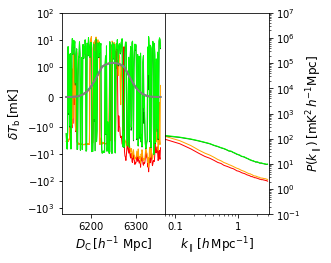

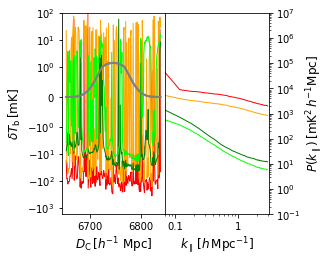

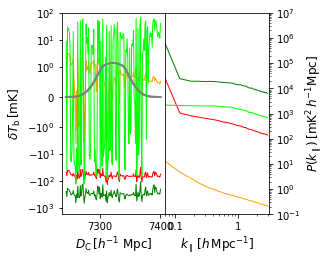

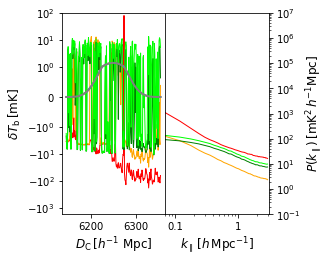

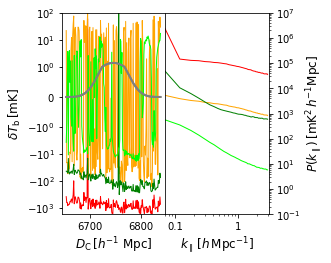

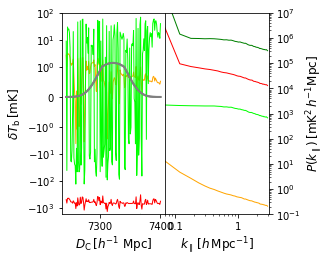

In [33]:
    if '2c' in plots:
        mdl_orig_colrs = {'Bright_galaxies_fiducial_1024':'orange', 'Faint_galaxies_fiducial_1024':'lime', 'Faint_galaxies_coldIGM':'lightblue'}
        mdl_colrs = {'Bright_galaxies_fiducial_1024':'red', 'Faint_galaxies_fiducial_1024':'green', 'Faint_galaxies_coldIGM':'blue'}
        delta_T_range = [-1.7e3, 1e2]
        for beamind, beamsize in enumerate(beam_majax):
            for zqi, zq in enumerate(z_qso):
                los_ind = NP.where(NP.abs(sampled_los_qtys[mdl]['d_los_comov'] - sampled_los_qtys[mdl]['cosmo'].comoving_distance(z_pspec[zqi])) <= 1.0 * sampled_los_qtys[mdl]['d_los_comov_width'][zqi])[0]
                fig, axs = PLT.subplots(ncols=2, figsize=(4.5, 3.5), squeeze=False)
                if axs.size == 1:
                    axs = axs.reshape(-1)
                for mdlind, mdl in enumerate(modelnames):
                    kprll_min = 2*NP.pi / sampled_los_qtys[mdl]['d_los_comov_width'][zqi]
                    axs[0,0].plot(sampled_los_qtys[mdl]['d_los_comov'][los_ind].to('Mpc').value, sampled_los_qtys[mdl]['delta_T_modified_nomonopole']['cube'][beamind,zqi,nrand//500,los_ind].to('mK').value, ls='-', lw=1, color=mdl_colrs[mdl])
                    axs[0,0].plot(sampled_los_qtys[mdl]['d_los_comov'][los_ind].to('Mpc').value, sampled_los_qtys[mdl]['delta_T_nomonopole']['cube'][nrand//500,los_ind].to('mK').value, ls='-', lw=1, color=mdl_orig_colrs[mdl])
                    axs[0,0].plot(sampled_los_qtys[mdl]['d_los_comov'][los_ind].to('Mpc').value, d_los_comov_wts[zqi,los_ind], ls='-', lw=2, color='gray')
                    axs[0,1].plot(kprll_onesided[mdl], pspec_kprll_onesided[mdl][beamind,zqi,:].to('mK2 Mpc').value, ls='-', lw=1, color=mdl_colrs[mdl])
#                     axs[0,1].plot(NP.abs(kprll_twosided[:kprll_twosided.size//2 + 1][::-1]), power_folded[beamind,zqi,nrand//50,:].to('mK2 Mpc').value, ls=':', lw=1, color='red')
#                     if fg_wedge_boundary[model][zqi] > kprll_min:
#                         axs[0,1].patches.Rectangle((0.9*kprll_min.to('Mpc-1').value, 0.0), fg_wedge_boundary[model][zqi].to('Mpc-1').value - 0.9*kprll_min.to('Mpc-1').value, NP.inf, fill=True, color='cyan')
                    axs[0,1].plot(kprll_onesided[mdl], pspec_kprll_onesided_orig[mdl][0,zqi,:].to('mK2 Mpc').value, ls='-', lw=1, color=mdl_orig_colrs[mdl])
#                     axs[0].plot(kprll_onesided[mdl], pspec_kprll_onesided[mdl][beamind,zqi,:])

                    axs[0,0].set_ylim(delta_T_range)
#                     axs[0,0].set_xscale('log')
                    axs[0,0].set_yscale('symlog', linthreshy=1.0)
                    axs[0,0].set_xlabel(r'$D_\mathrm{C}\,[h^{-1}$ Mpc]', fontsize=12, weight='medium')
#                     print(los_ind.shape)
#                     print(sampled_los_qtys[mdl]['d_los_comov'][los_ind].to('Mpc').value.min(), sampled_los_qtys[mdl]['d_los_comov'][los_ind].to('Mpc').value.max())
#                     axs[0,0].set_xlim(xmin=sampled_los_qtys[mdl]['d_los_comov'][los_ind].to('Mpc').value.min(), xmax=sampled_los_qtys[mdl]['d_los_comov'][los_ind].to('Mpc').value.max())
                    axs[0,0].set_ylabel(r'$\delta T_\mathrm{b}\,[\mathrm{mK}]$', fontsize=12, weight='medium')

#                     axs[0,1].set_xlim(kprll_min.to('Mpc-1').value, None)
                    axs[0,1].set_xlim(0.07, None)
                    axs[0,1].set_ylim(0.1, 1e7)
                    axs[0,1].set_xscale('log')
                    axs[0,1].set_yscale('log')
                    axs[0,1].yaxis.tick_right()
                    tickformatter = ticker.FuncFormatter(lambda y, _: '{:.16g}'.format(y))
                    axs[0,1].xaxis.set_major_formatter(tickformatter)
#                     axs[0,1].xaxis.set_minor_formatter(tickformatter)
                    axs[0,1].set_xlabel(r'$k_\parallel\,[h\,\mathrm{Mpc}^{-1}]$', fontsize=12, weight='medium')
                    axs[0,1].set_ylabel(r'$P(k_\parallel)\,[\mathrm{mK}^2\,h^{-1}\mathrm{Mpc}]$', fontsize=12, weight='medium')
                    axs[0,1].yaxis.set_label_position('right')
                    
                    fig.subplots_adjust(hspace=0, wspace=0)
                    fig.subplots_adjust(bottom=0.15, top=0.95, left=0.18, right=0.82)
#                     PLT.savefig(figdir+'delta_T_temp_Pspec_pre_post_modification_z_{0:.1f}.pdf'.format(z_pspec[zqi]), bbox_inches=0)
                    print(figdir+'delta_T_temp_Pspec_pre_post_modification_z_{0:.1f}.pdf'.format(z_pspec[zqi]))                     

In [34]:
    print(axs[0,1])
    print(pspec_kprll_onesided_orig[mdl].shape)

AxesSubplot(0.5,0.15;0.32x0.8)
(1, 3, 50)


/lustre/aoc/users/nthyagar/projects/21cmforest/figures/delta_T_pre_post_modification_Bright_galaxies_fiducial_1024.pdf


/lustre/aoc/users/nthyagar/src/miniconda2/envs/PRISim-dev/lib/python2.7/site-packages/astropy/units/quantity.py:641: RuntimeWarning: divide by zero encountered in true_divide
  *arrays, **kwargs)


/lustre/aoc/users/nthyagar/projects/21cmforest/figures/Pspec_pre_post_modification_Bright_galaxies_fiducial_1024.pdf
/lustre/aoc/users/nthyagar/projects/21cmforest/figures/delta_T_pre_post_modification_Faint_galaxies_fiducial_1024.pdf
/lustre/aoc/users/nthyagar/projects/21cmforest/figures/Pspec_pre_post_modification_Faint_galaxies_fiducial_1024.pdf


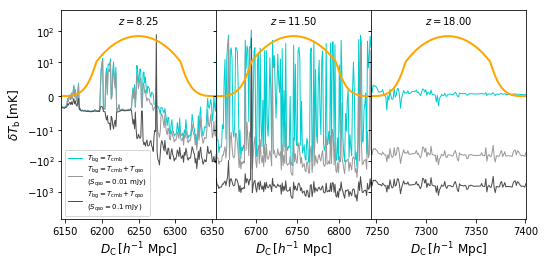

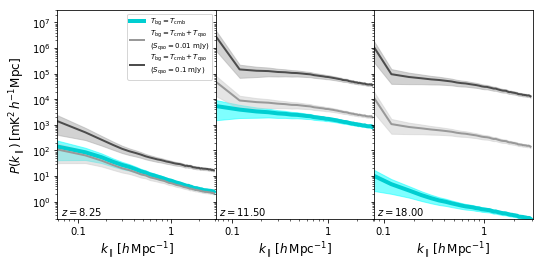

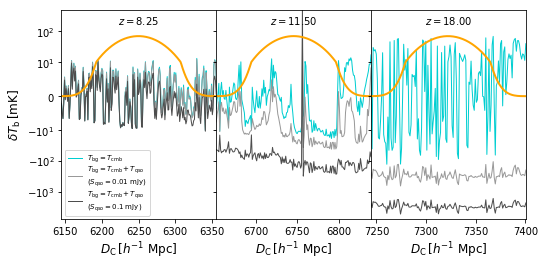

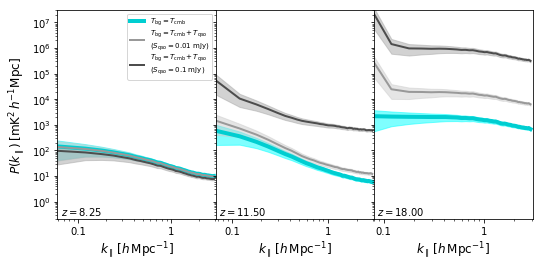

In [35]:
    if '2c' in plots:
        delta_T_range = [-8e3, 5e2]
        bgrad_colrs = ['darkturquoise']
        bgrad_colrs += map(str, NP.linspace(0.6, 0.3, beam_majax.size).tolist())
        bgrad_samvar_colrs = ['cyan']
        bgrad_samvar_colrs += map(str, NP.linspace(0.8, 0.65, beam_majax.size).tolist())
        for mdlind, mdl in enumerate(modelnames):
            fig, axs = PLT.subplots(ncols=z_pspec.size, sharey=True, figsize=(z_pspec.size*2.5, 3.5), squeeze=False)
            if axs.size == 1:
                axs = axs.reshape(-1)
            for zqi, zq in enumerate(z_qso):
                los_ind = NP.where(NP.abs(sampled_los_qtys[mdl]['d_los_comov'] - sampled_los_qtys[mdl]['cosmo'].comoving_distance(z_pspec[zqi])) <= 1.0 * sampled_los_qtys[mdl]['d_los_comov_width'][zqi])[0]
                axs[0,zqi].plot(sampled_los_qtys[mdl]['d_los_comov'][los_ind].to('Mpc').value, sampled_los_qtys[mdl]['delta_T_nomonopole']['cube'][nrand//500,los_ind].to('mK').value, ls='-', lw=1, color=bgrad_colrs[0], label=r'$T_\mathrm{bg}=T_\mathrm{cmb}$')
                for beamind, beamsize in enumerate(beam_majax):
                    axs[0,zqi].plot(sampled_los_qtys[mdl]['d_los_comov'][los_ind].to('Mpc').value, sampled_los_qtys[mdl]['delta_T_modified_nomonopole']['cube'][beamind,zqi,nrand//500,los_ind].to('mK').value, ls='-', lw=1, color=bgrad_colrs[beamind+1], label=r'$T_\mathrm{bg}=T_\mathrm{cmb}+T_\mathrm{qso}$'+'\n'+r'$(S_\mathrm{qso}=$'+'{0:.2g} mJy)'.format((flux_obs[beamind]*beam_sa_0[beamind]).to('mJy').value[0]))

                axs[0,zqi].plot(sampled_los_qtys[mdl]['d_los_comov'][los_ind].to('Mpc').value, 50*d_los_comov_wts[zqi,los_ind], ls='-', lw=2, color='orange')                
                axs[0,zqi].set_xlim(sampled_los_qtys[mdl]['d_los_comov'][los_ind].to('Mpc').value.min(), sampled_los_qtys[mdl]['d_los_comov'][los_ind].to('Mpc').value.max())
                axs[0,zqi].set_ylim(delta_T_range)
                axs[0,zqi].text(0.5, 0.98, r'$z=$'+'{0:.2f}'.format(z_pspec[zqi]), transform=axs[0,zqi].transAxes, ha='center', va='top')
                axs[0,zqi].set_yscale('symlog', linthreshy=10.0)
                axs[0,zqi].set_xlabel(r'$D_\mathrm{C}\,[h^{-1}$ Mpc]', fontsize=12, weight='medium')
                axs[0,0].set_ylabel(r'$\delta T_\mathrm{b}\,[\mathrm{mK}]$', fontsize=12, weight='medium')
                axs[0,0].legend(loc='lower left', shadow=False, fontsize=7, labelspacing=0)

            fig.subplots_adjust(hspace=0, wspace=0)
            fig.subplots_adjust(bottom=0.15, top=0.98, left=0.1, right=0.96)

            PLT.savefig(figdir+'delta_T_pre_post_modification_{0}.pdf'.format(mdl), bbox_inches=0)
            print(figdir+'delta_T_pre_post_modification_{0}.pdf'.format(mdl))

            fig, axs = PLT.subplots(ncols=z_pspec.size, sharey=True, figsize=(z_pspec.size*2.5, 3.5), squeeze=False)
            if axs.size == 1:
                axs = axs.reshape(-1)
            for zqi, zq in enumerate(z_qso):
                kprll_min = 2*NP.pi / sampled_los_qtys[mdl]['d_los_comov_width'][zqi]
                axs[0,zqi].fill_between(kprll_onesided[mdl], pspec_kprll_onesided_orig[mdl][0,zqi,:].to('mK2 Mpc').value*(1-1./NP.sqrt(nsamples_total_onesided[model][zqi])), pspec_kprll_onesided_orig[mdl][0,zqi,:].to('mK2 Mpc').value*(1+1./NP.sqrt(nsamples_total_onesided[model][zqi])), color=bgrad_samvar_colrs[0], alpha=0.5)
                axs[0,zqi].plot(kprll_onesided[mdl], pspec_kprll_onesided_orig[mdl][0,zqi,:].to('mK2 Mpc').value, ls='-', lw=4, color=bgrad_colrs[0], label=r'$T_\mathrm{bg}=T_\mathrm{cmb}$')
                for beamind, beamsize in enumerate(beam_majax):
                    axs[0,zqi].fill_between(kprll_onesided[mdl], pspec_kprll_onesided[mdl][beamind,zqi,:].to('mK2 Mpc').value*(1-1./NP.sqrt(nsamples_total_onesided[model][zqi])), pspec_kprll_onesided[mdl][beamind,zqi,:].to('mK2 Mpc').value*(1+1./NP.sqrt(nsamples_total_onesided[model][zqi])), color=bgrad_samvar_colrs[beamind+1], alpha=0.5)
                for beamind, beamsize in enumerate(beam_majax):
                    axs[0,zqi].plot(kprll_onesided[mdl], pspec_kprll_onesided[mdl][beamind,zqi,:].to('mK2 Mpc').value, ls='-', lw=2, color=bgrad_colrs[beamind+1], label=r'$T_\mathrm{bg}=T_\mathrm{cmb}+T_\mathrm{qso}$'+'\n'+r'$(S_\mathrm{qso}=$'+'{0:.2g} mJy)'.format((flux_obs[beamind]*beam_sa_0[beamind]).to('mJy').value[0]))
                axs[0,zqi].set_xlim(xmin=kprll_min.to('Mpc-1').value)
                axs[0,zqi].set_ylim(0.2, 3e7)
                axs[0,zqi].set_xscale('log')
                axs[0,zqi].set_yscale('log')
                tickformatter = ticker.FuncFormatter(lambda y, _: '{:.16g}'.format(y))
                axs[0,zqi].xaxis.set_major_formatter(tickformatter)
                axs[0,zqi].text(0.02, 0.01, r'$z=$'+'{0:.2f}'.format(z_pspec[zqi]), transform=axs[0,zqi].transAxes, ha='left', va='bottom')
                axs[0,zqi].set_xlabel(r'$k_\parallel\,[h\,\mathrm{Mpc}^{-1}]$', fontsize=12, weight='medium')
                axs[0,0].set_ylabel(r'$P(k_\parallel)\,[\mathrm{mK}^2\,h^{-1}\mathrm{Mpc}]$', fontsize=12, weight='medium')
                axs[0,0].legend(loc='upper right', shadow=False, fontsize=7, labelspacing=0)
                
            fig.subplots_adjust(hspace=0, wspace=0)
            fig.subplots_adjust(bottom=0.15, top=0.98, left=0.1, right=0.98)

            PLT.savefig(figdir+'Pspec_pre_post_modification_{0}.pdf'.format(mdl), bbox_inches=0)
            print(figdir+'Pspec_pre_post_modification_{0}.pdf'.format(mdl))

In [41]:
nlev = (200.0 * U.K) / NP.sqrt(2 * 40*U.kHz * 1*U.hr)
print(nlev.to('mK'))
nn = (200.0 * U.K)**2 * (100 * U.Mpc) / (10 * U.MHz) / (0.3 * U.hr)
print(nn.to('mK2 Mpc'))

11.7851130198 mK
370.37037037 mK2 Mpc


In [939]:
NP.pi * 45**2 / 4

1590.4312808798327

## Useful equations

$z_\textrm{s}$: Redshift of background source, QSO in this case

$\nu_\textrm{r}$: Rest-frame frequency of H{\sc i} or another spectral line

The intervening cloud of spectral line gas is assumed to be at redshift $z=z_\textrm{c}$

$\nu_\textrm{obs}$: Any arbitrary frequency observed by observer at $z=0$ 

$\nu_\textrm{s}$: Emission frequency at rest-frame of observer at $z=z_\textrm{s}$ which when redshifted to $z=z_\textrm{c}$ is observed at the redshifted frequency of $\nu_\textrm{r}$

$z_\textrm{cs}$: Redshift of the background source ($z=z_\textrm{s}$) as seen by an observer at $z=z_\textrm{c}$

$$ z_\textrm{cs}+1 = \frac{\nu_\textrm{s}}{\nu_\textrm{r}} = \frac{\nu_\textrm{r}(\frac{1+z_\textrm{s}}{1+z_\textrm{c}})}{\nu_\textrm{r}} = \frac{1+z_\textrm{s}}{1+z_\textrm{c}}$$
$$ \implies \boxed{z_\textrm{cs} = \frac{z_\textrm{s}-z_\textrm{c}}{1+z_\textrm{c}}}$$

$\alpha$: Spectral index of background continuum source

Given the solid-angle integrated flux density, $S_\nu(\nu_\textrm{obs}|z=0)$, what is $S_\nu(v_\textrm{c}|z=z_\textrm{c})$, where $\nu_\textrm{c}$ is an arbitrary frequency, while accounting for the spectral index, $\alpha$?

$$ S_\nu(\frac{\nu_\textrm{c}}{1+z_\textrm{c}}|z=0) \, \frac{d\nu_\textrm{c}}{1+z_\textrm{c}} = S_\nu(\nu_\textrm{c}|z=z_\textrm{c}) \, d\nu_\textrm{c}$$

$$ \implies S_\nu(\nu_\textrm{c}|z=z_\textrm{c}) = \frac{1}{1+z_\textrm{c}}\,S_\nu(\frac{\nu_\textrm{c}}{1+z_\textrm{c}}|z=0) $$

$$ S_\nu(\nu_\textrm{c}|z=z_\textrm{c}) = \frac{1}{1+z_\textrm{c}}\, S_\nu(\nu_\textrm{obs}|z=0)\,(\frac{\nu_\textrm{c}}{\nu_\textrm{obs}})^\alpha \, \frac{1}{(1+z_\textrm{c})^\alpha}$$

$$ \therefore \boxed{S_\nu(\nu_\textrm{c}|z=z_\textrm{c}) = \frac{1}{(1+z_\textrm{c})^{1+\alpha}}\, (\frac{\nu_\textrm{c}}{\nu_\textrm{obs}})^\alpha \, S_\nu(\nu_\textrm{obs}|z=0)} $$

If we substitute $\nu_\textrm{c}=\nu_\textrm{r}$, then: 
$$ \boxed{S_\nu(\nu_\textrm{r}|z=z_\textrm{c}) = \frac{1}{(1+z_\textrm{c})^{1+\alpha}}\, (\frac{\nu_\textrm{r}}{\nu_\textrm{obs}})^\alpha \, S_\nu(\nu_\textrm{obs}|z=0)} $$

If we substitute $\nu_\textrm{c}=\nu_\textrm{r}=\nu_\textrm{obs}(1+z_\textrm{c})$, then:
$$ \boxed{S_\nu(\nu_\textrm{r}|z=z_\textrm{c}) = \frac{1}{(1+z_\textrm{c})}\, S_\nu(\frac{\nu_\textrm{r}}{1+z_\textrm{c}}|z=0)} $$

Given the specific intensity observed, $B_\nu(\nu_\textrm{obs}|z=0)$, what is the specific intensity, $B_\nu(v_\textrm{c}|z=z_\textrm{c})$, where $\nu_\textrm{c}$ is an arbitrary frequency, while accounting for the spectral index, $\alpha$?

From Condon & Mathews (2018), the bolometric intensity behaves as $B(z=0) = (1+z_\textrm{c})^{-4}\,B(z=z_\textrm{c})$, which is due to the "cosmological dimming" factors -- $(1+z_\textrm{c})^2$ each from dependence on angular diameter and square of the luminosity distance. 

$$ \implies B_\nu(\frac{\nu_\textrm{c}}{1+z_\textrm{c}}|z=0) \, \frac{d\nu_\textrm{c}}{1+z_\textrm{c}} = (1+z_\textrm{c})^{-4}\, B_\nu(\nu_\textrm{c}|z=z_\textrm{c}) \, d\nu_\textrm{c}$$

$$ \implies B_\nu(\nu_\textrm{c}|z=z_\textrm{c}) = (1+z_\textrm{c})^3\,B_\nu(\frac{\nu_\textrm{c}}{1+z_\textrm{c}}|z=0) $$

$$ B_\nu(\nu_\textrm{c}|z=z_\textrm{c}) = (1+z_\textrm{c})^3\, B_\nu(\nu_\textrm{obs}|z=0)\,(\frac{\nu_\textrm{c}}{\nu_\textrm{obs}})^\alpha \, \frac{1}{(1+z_\textrm{c})^\alpha}$$

$$ \therefore \boxed{B_\nu(\nu_\textrm{c}|z=z_\textrm{c}) = (1+z_\textrm{c})^{3-\alpha}\, (\frac{\nu_\textrm{c}}{\nu_\textrm{obs}})^\alpha\,B_\nu(\nu_\textrm{obs}|z=0)} $$

If we substitute $\nu_\textrm{c}=\nu_\textrm{r}$, then: 
$$ \boxed{B_\nu(\nu_\textrm{r}|z=z_\textrm{c}) = (1+z_\textrm{c})^{3-\alpha}\, (\frac{\nu_\textrm{r}}{\nu_\textrm{obs}})^\alpha \, B_\nu(\nu_\textrm{obs}|z=0)} $$

If we substitute $\nu_\textrm{c}=\nu_\textrm{r}=\nu_\textrm{obs}(1+z_\textrm{c})$, then:
$$ \boxed{B_\nu(\nu_\textrm{r}|z=z_\textrm{c}) = (1+z_\textrm{c})^3\, B_\nu(\frac{\nu_\textrm{r}}{1+z_\textrm{c}}|z=0)}, $$
which is consistent with Eq.(74) in Condon & Mathews (2018).

This can be translated to brightness temperature, $T(\nu=\nu_\textrm{c}|z=z_\textrm{c})$ using the Rayleigh-Jeans approximation:
$$ T(\nu=\nu_\textrm{c}|z=z_\textrm{c}) \approx \frac{\lambda_\textrm{c}^2}{2\, k_\textrm{B}} B_\nu(\nu_\textrm{c}|z=z_\textrm{c})$$
$$ \implies \boxed{T(\nu=\nu_\textrm{c}|z=z_\textrm{c}) \approx \frac{\lambda_\textrm{c}^2}{2\, k_\textrm{B}} (1+z_\textrm{c})^{3-\alpha}\,(\frac{\nu_\textrm{c}}{\nu_\textrm{obs}})^\alpha \, B_\nu(\nu_\textrm{obs}|z=0)}$$

If we substitute $\nu_\textrm{c}=\nu_\textrm{obs}(1+z_\textrm{c})$, then:
$$ T(\nu=\nu_\textrm{obs}(1+z_\textrm{c})|z=z_\textrm{c}) \approx \frac{\lambda_\textrm{obs}^2}{2\, k_\textrm{B}} (1+z_\textrm{c})\, B_\nu(\nu_\textrm{obs}|z=0)$$
$$ \implies \boxed{T(\nu=\nu_\textrm{obs}(1+z_\textrm{c})|z=z_\textrm{c}) = (1+z_\textrm{c})\,T(\nu=\nu_\textrm{obs}|z=0)}$$

In other words, the temperature scales with redshift as $1+z_\textrm{c}$ and the spectral index falls out of the redshift scaling. However, spectral index, $\alpha$, may or may not be implicitly present in $T(\nu=\nu_\textrm{obs}|z=0)$.

Thus given an specific intensity observed at $z=0$ with spectral index $\alpha$ of a background radiation source placed at some arbitrary high redshift, the brightness temperature seen at $z=z_\textrm{c}$ can be predicted as above.

Denote the true solid angle of the object's emission region by $\Omega_\textrm{s}$, the solid angle of the pixel of the cube by $\Omega_\textrm{p}$, and the synthesized beam solid angle by $\Omega_\textrm{A}$. Also, assume that $\Omega_\textrm{A} \geq \Omega_\textrm{p} \geq \Omega_\textrm{s}$. 

Then the solid angle filling factors are defined as: 
$$ 0\leq \zeta_\textrm{sp} = \frac{\Omega_\textrm{s}}{\Omega_\textrm{p}} \leq 1,$$
$$ 0\leq \zeta_\textrm{pA} = \frac{\Omega_\textrm{p}}{\Omega_\textrm{A}} \leq 1,$$
$$ 0\leq \zeta_\textrm{sA} = \frac{\Omega_\textrm{s}}{\Omega_\textrm{A}} \leq 1.$$

Then, if the specific intensity measured by the interferometer (with $\Omega_\textrm{A}$) is $B_\nu^\textrm{m}(\nu_\textrm{obs}|z=0)$, then the specific intensity in the pixel (with $\Omega_\textrm{p}$) at redshift $z=z_\textrm{c}$ is given by:
$$ B_\nu^\textrm{p}(\nu_\textrm{c}|z=z_\textrm{c}) = (1+z_\textrm{c})^{3-\alpha}\, (\frac{\nu_\textrm{c}}{\nu_\textrm{obs}})^\alpha \, B_\nu^\textrm{m}(\nu_\textrm{obs}|z=0) \, \frac{1}{\zeta_\textrm{pA}}$$

This implies that on account of the interferometer synthesized beam solid angle being greater than the pixel size and since the pixel size is comparable or larger than the source extent, the measured specific intensity is diluted relative to what would have been observed if the synthesized beam size was comparable to the pixel size. In other words, the synthesized beam solid angle contains a lot of empty pixels besides the pixel that contains the emission and is thus diluted. Therefore, this has to be corrected while determining the specific intensity measured over the pixel solid angle by dividing out the appropriate filling factor.  

However, in practice, the interferometer synthesized beam would have smeared out the emission from the narrow angular source into the interferometer synthesized beam area and this cannot be corrected as an observer. It is best to match the resolution of the synthesized beam to the angular extent of the source to get the maximum specific intensity in that pixel without synthesized beam dilution effects. In such a scenario, if the interferometer synthesized beam is bigger than the pixel size, the specific intensity seen in a pixel will be roughly equal to that measured in the synthesized synthesized beam. If the synthesized beam is smaller than a pixel size, then multiple synthesized beams can cover the pixel and hence the specific intensity measured in the image pixel will be diluated by the filling factor. hence, we define the filling factor corrections from an observer's perspective as:
$$ \zeta^\prime_\textrm{pA} = \frac{\Omega_\textrm{p}}{\Omega_\textrm{A}} \geq 1 $$
Then, if the specific intensity measured by the interferometer (with $\Omega_\textrm{A}$) is $B_\nu^\textrm{m}(\nu_\textrm{obs}|z=0)$, then the specific intensity in the pixel (with $\Omega_\textrm{p}$) at redshift $z=z_\textrm{c}$ is given by:
$$ \boxed{ B_\nu^{\textrm{p}\prime}(\nu_\textrm{c}|z=z_\textrm{c}) = (1+z_\textrm{c})^{3-\alpha}\, (\frac{\nu_\textrm{c}}{\nu_\textrm{obs}})^\alpha \, B_\nu^\textrm{m}(\nu_\textrm{obs}|z=0) \, \frac{1}{\zeta^\prime_\textrm{pA}} }$$
and the corresponding brightness temperature is:
$$ \boxed{ T^\prime_\textrm{bg}(\nu=\nu_\textrm{c}|z=z_\textrm{c}) \approx \frac{\lambda_\textrm{c}^2}{2\, k_\textrm{B}} B_\nu^{\textrm{p}\prime}(\nu_\textrm{c}|z=z_\textrm{c}) }$$

If the HI 21 cm brightness temperature fluctuations along the line of sight are denoted by $\delta T_\textrm{b}^\textrm{orig}(l_\textrm{los}(z))$, these fluctuations will be modified along quasar lines of sight in front of the quasar as:
$$ \boxed{ \delta T_\textrm{b}^\textrm{mod}(l_\textrm{los}(z)) = \frac{T_\textrm{spin} - T^\prime_\textrm{bg}(\nu=\nu_\textrm{c}|z=z_\textrm{c})}{T_\textrm{spin} - T_\textrm{CMB}(z=z_\textrm{c})}\, \delta T_\textrm{b}^\textrm{orig}(l_\textrm{los}(z)) }$$

We are interested in the power spectrum of this quantity, namely:

$$ \boxed{ P(k_\parallel) = \frac{1}{\Delta l_\textrm{los}}\, \left|\int\,\delta T_\textrm{b}^\textrm{mod}(l_\textrm{los})\,e^{-i\,k_\parallel\,l_\textrm{los}}\textrm{d}l_\textrm{los}\right|^2 },$$
which is in units of K$^2\,$Mpc.

### Process the information using the equations above

## Method 3: Based on re-estimating the brightness temperature fluctuations using "from scratch" estimates of optical depth, etc. 

In [26]:
if ('3' in plots) or ('3a' in plots):
    modelnames = plot_info['3']['models']
    beam_majax = NP.asarray(plot_info['3']['beam_majax']) * U.arcsec
    beam_sa_0 = NP.pi*((beam_majax/2)**2).to('sr') # Beam solid angle at z=0
    fov_fwhm = plot_info['3']['fov_fwhm'] * U.deg # Field of view FWHM 
    fov_hwhm_dircos = NP.sin(0.5*fov_fwhm) # Field of HWHM in direction-cosine units
    flux_density_obs = NP.asarray(plot_info['3']['flux_obs']) * U.mJy
    beam_majax = beam_majax * NP.ones(flux_density_obs.size)
    beam_sa_0 = beam_sa_0 * NP.ones(flux_density_obs.size)
    flux_obs = (flux_density_obs / beam_sa_0).reshape(-1,1)
    freq_obs = plot_info['2']['freq_obs'] * U.Hz
    qtys = plot_info['3']['qtys']
    spindex = plot_info['3']['spindex']
    z_qso = NP.asarray(plot_info['3']['z_qso'])
    z_pspec = NP.asarray(plot_info['3']['z_pspec'])
    frac_bw = plot_info['3']['frac_bw']
    rest_freq = plot_info['3']['rest_freq'] * U.Hz
    if rest_freq is None:
        rest_freq = CNST.rest_freq_HI * U.Hz
    nrand = plot_info['3']['nrand']
    randseed = plot_info['3']['seed']
    subbandinfo = plot_info['3']['subband']
    winshape = subbandinfo['shape']
    fftpow = subbandinfo['fftpow']
    pad = subbandinfo['pad']
    indir_pfx = plot_info['3']['indir_pfx']
    indir_sfx = plot_info['3']['indir_sfx']
    
    nrand = plot_info['3']['nrand']
    randseed = plot_info['3']['seed']
    rstate = NP.random.RandomState(randseed)
    
    qtys = plot_info['3']['qtys']
    Tsys0 = plot_info['3']['Tsys0'] * U.K
    Tsys_spindex = plot_info['3']['Tsys_spindex']
    Tsys_reffreq = plot_info['3']['Tsys_reffreq'] * U.Hz
    n_ant = plot_info['3']['n_antennas']
    input_nqso = plot_info['3']['n_qso_ref']
    input_array_sensitivity = plot_info['3']['A_over_T_ref'] * U.m**2 / U.K
    lofar_array_sensitivity = plot_info['3']['A_over_T_lofar'] * U.m**2 / U.K
    uGMRT_array_sensitivity = plot_info['3']['A_over_T_uGMRT'] * U.m**2 / U.K
    eGMRT_array_sensitivity = plot_info['3']['A_over_T_EGMRT'] * U.m**2 / U.K
    ska1_array_sensitivity = plot_info['3']['A_over_T_SKA1'] * U.m**2 / U.K
    ska2_array_sensitivity = plot_info['3']['A_over_T_SKA2'] * U.m**2 / U.K
    t_int = plot_info['3']['t_int'] * U.s
    t_half = 0.5 * t_int
    detection_threshold = plot_info['3']['snr_min']
    data_loss_factor = plot_info['3']['data_loss']
    efficiency_factor = plot_info['3']['efficiency']
#     efficiency_factor = 1 - data_loss_factor

    wl_zpspec = (FC.c/rest_freq) * (1+z_pspec)
    freq_zpspec = rest_freq/(1+z_pspec)
    blmax_zpspec = 1.22 * wl_zpspec.reshape(1,-1) / beam_majax.to('', equivalencies=U.dimensionless_angles()).reshape(-1,1) # Max baseline corresponding to beam major axis
    blmax_zpspec = blmax_zpspec.to('m')
    rms_confusion = classical_source_confusion(theta_FWHM=beam_majax.reshape(-1,1), frequency=freq_zpspec.reshape(1,-1)) # (nbeam,nz_pspec)
    pbeam_solang = NP.pi * (0.5*fov_fwhm)**2 # Primary beam solid angle
    sidelobe_rms_confusion = rms_confusion * NP.sqrt(pbeam_solang / beam_sa_0)

In [28]:
    print(plot_info['3'])
    print(blmax_zpspec)
    print(1.22 * 21.0*U.cm * (1+11) / beam_majax.to('', equivalencies=U.dimensionless_angles()).reshape(-1,1))
    print(rms_confusion.to('uJy'))
    print(fov_fwhm.to('deg'))
    print(pbeam_solang.to('deg2'))
    print(sidelobe_rms_confusion.decompose().to('mJy'))

{'n_qso_ref': 100, 'A_over_T_lofar': 90.0, 'A_over_T_SKA2': 4000.0, 'A_over_T_SKA1': 800.0, 'Tsys_reffreq': 150000000, 'seed': 100, 'z_qso': [10.0, 12.0, 18.0], 'data_loss': 0.0, 'Tsys0': 384.0, 'A_over_T_ref': 800.0, 'snr_min': 5.0, 'rest_freq': 1420405751.77, 'A_over_T_EGMRT': 210.0, 'subband': {'fftpow': 1.0, 'shape': 'bhw', 'pad': 1.0}, 'flux_obs': [1.0, 10.0, 100.0], 'indir_pfx': '/lustre/aoc/users/nthyagar/data/EoR_models/21cmFAST/Andrei_Mesinger/', 'freq_obs': 150000000.0, 'indir_sfx': '/lightcone/combined/', 'models': ['Bright_galaxies_fiducial_1024', 'Faint_galaxies_fiducial_1024'], 'frac_bw': 0.0667, 'efficiency': 1.0, 'qtys': ['delta_T', 'x_H', 'density', 'T_s'], 't_int': 36000.0, 'spindex': -1.05, 'fov_fwhm': 5.0, 'beam_majax': [10.0, 10.0, 10.0], 'Tsys_spindex': -2.55, 'n_antennas': 30, 'action': True, 'z_pspec': [8.0, 9.5, 11.0], 'nrand': 10000, 'A_over_T_uGMRT': 70.0}
[[47800.86481553 55767.67561811 63734.4864207 ]
 [47800.86481553 55767.67561811 63734.4864207 ]
 [47800.

In [20]:
if ('3' in plots) or ('3a' in plots):
    
    sampled_los_qtys = {} 
    for modelind,model in enumerate(modelnames):
        sampled_los_qtys[model] = {}
        indir = indir_pfx + model + indir_sfx
        for qty in qtys:
            sampled_los_qtys[model][qty] = {}
            cubefile = indir + '{0}_light_cone.hdf5'.format(qty)
            cube, los_monopole, boxres, zmin, cosmo = read_HDF5_lightcone_cube(cubefile)
            rstate = NP.random.RandomState(randseed)
            pixind = rstate.randint(0, high=cube.shape[1]*cube.shape[2], size=nrand)
            sampled_los_qtys[model][qty]['cube'] = cube.reshape(cube.shape[0],-1)[:,pixind].T # (npix, nlos)
            sampled_los_qtys[model][qty]['monopole'] = los_monopole
        sampled_los_qtys[model]['boxres'] = boxres
        d_los_comov_min = cosmo.comoving_distance(zmin)
        sampled_los_qtys[model]['d_los_comov'] = d_los_comov_min + boxres * NP.arange(cube.shape[0]) # (nlos,)
        zgrid = NP.logspace(NP.log10(zmin-0.5), NP.log10(100.0), num=50000)
        d_los_comov_grid = cosmo.comoving_distance(zgrid)
        sampled_los_qtys[model]['redshifts'] = NP.interp(sampled_los_qtys[model]['d_los_comov'].to('Mpc').value, d_los_comov_grid.to('Mpc').value, zgrid)

In [32]:
if ('3' in plots) or ('3a' in plots):
    for modelind,model in enumerate(modelnames):
        freq_redshift = rest_freq / (1 + sampled_los_qtys[model]['redshifts']) # (nlos,)
        sampled_los_qtys[model]['d_los_comov_center'] = cosmo.comoving_distance(z_pspec)
        zlo = z_pspec * (1 - 0.5 * frac_bw)
        zhi = z_pspec * (1 + 0.5 * frac_bw)
        d_los_comov_lo = cosmo.comoving_distance(zlo)
        d_los_comov_hi = cosmo.comoving_distance(zhi)
        sampled_los_qtys[model]['d_los_comov_width'] = d_los_comov_hi - d_los_comov_lo
        bw = sampled_los_qtys[model]['d_los_comov_width'] * (sampled_los_qtys[model]['cosmo'].H0 * rest_freq * sampled_los_qtys[model]['cosmo'].efunc(z_pspec) ) / (FC.c * (1+z_pspec)**2)
        freq_resolution = sampled_los_qtys[model]['boxres'] * (sampled_los_qtys[model]['cosmo'].H0 * rest_freq * sampled_los_qtys[model]['cosmo'].efunc(z_pspec) ) / (FC.c * (1+z_pspec)**2)

In [22]:
if ('3' in plots) or ('3a' in plots):
    
    rstate = NP.random.RandomState(randseed)
    per_antenna_noise_temperature_spectrum = Tsys0 * (freq_redshift / Tsys_reffreq)**Tsys_spindex
    eff_area_array_spectrum = input_array_sensitivity * per_antenna_noise_temperature_spectrum
    input_array_sefd = 2 * FC.k_B / input_array_sensitivity
    variable_freq_resolution = NP.abs(NP.hstack((freq_redshift.to('kHz').value[1]-freq_redshift.to('kHz').value[0], NP.diff(freq_redshift.to('kHz').value)))) * U.kHz
    imgpixel_rms_fluxdensity_thalf_spectrum = input_array_sefd.to('mJy') / NP.sqrt(2 * variable_freq_resolution * t_half) # (nlos,)
    imgpixel_noise_fluxdensity_thalf_spectrum = imgpixel_rms_fluxdensity_thalf_spectrum * rstate.randn(2,nrand,freq_redshift.size) # (2,npix,nlos)
#     imgpixel_rms_temperature_thalf_spectrum = imgpixel_rms_fluxdensity_thalf_spectrum * eff_area_array_spectrum / (2 * FC.k_B)
#     imgpixel_noise_temperature_thalf_spectrum = imgpixel_noise_fluxdensity_thalf_spectrum * eff_area_array_spectrum / (2 * FC.k_B)
#     print(imgpixel_rms_temperature_thalf_spectrum.to('mK'))
#     print(imgpixel_rms_fluxdensity_thalf_spectrum.to('mJy'))
    
    obsframe_fluxdensity_qso_spectrum = flux_density_obs.reshape(-1,1) * (freq_redshift.reshape(1,-1)/freq_obs)**spindex # (nbeam, nlos)
    obsframe_temp_qso_spectrum = NP.empty((beam_sa_0.size, freq_redshift.size)) * U.K
    for beamind,flxobs in enumerate(flux_obs):
        obsframe_temp_qso_spectrum[beamind,:] = fluxdensity_to_temperature(fluxdensity=obsframe_fluxdensity_qso_spectrum[beamind,:], beamSA=beam_sa_0[beamind], frequency=freq_redshift, ref_freq=freq_obs, spindex=None)[0,0,:] # ()
    restframe_temp_qso_spectrum = obsframe_temp_qso_spectrum * (1+sampled_los_qtys[model]['redshifts'].reshape(1,-1))
    los_ind_to_modify = sampled_los_qtys[model]['redshifts'].reshape(1,-1) <= z_qso.reshape(-1,1) # (nz_qso, nlos)
    
    for modelind,model in enumerate(modelnames):        
        sampled_los_qtys[model]['pixang'] = sampled_los_qtys[model]['boxres'] / cosmo.comoving_distance(sampled_los_qtys[model]['redshifts']) * U.rad # (nlos,)
        sampled_los_qtys[model]['pixsa'] = sampled_los_qtys[model]['pixang']**2
        sampled_los_qtys[model]['pixsa'] = sampled_los_qtys[model]['pixsa'].to('sr')
        sampled_los_qtys[model]['cosmo'] = copy.deepcopy(cosmo)
        sampled_los_qtys[model]['zmin'] = zmin
        
        sampled_los_qtys[model]['restframe_T_bg_orig'] = {'monopole': sampled_los_qtys[model]['cosmo'].Tcmb0.to('K') * (1 + sampled_los_qtys[model]['redshifts'].reshape(-1))}  # (nlos,)
        sampled_los_qtys[model]['obsframe_T_bg_orig'] = {'monopole': sampled_los_qtys[model]['cosmo'].Tcmb0.to('K') * NP.ones(sampled_los_qtys[model]['redshifts'].size)}  # (nlos,)
        sampled_los_qtys[model]['obsframe_T_bg_net'] = {'monopole': obsframe_temp_qso_spectrum + sampled_los_qtys[model]['cosmo'].Tcmb0}  # (nbeam, nlos)
        sampled_los_qtys[model]['restframe_T_bg_net'] = {'monopole': sampled_los_qtys[model]['obsframe_T_bg_net']['monopole'] * (1 + sampled_los_qtys[model]['redshifts'].reshape(1,-1))}  # (nbeam, nlos)
        
#         sa_filling_factor_pix_beam = sampled_los_qtys[model]['pixsa'].reshape(1,-1) / beam_sa_0.reshape(-1,1) # (nbeam, nlos)
#         sa_filling_factor_pix_beam[sa_filling_factor_pix_beam.decompose() <= 1.0] = 1.0 
#         flux_los = flux_obs * (rest_freq/freq_obs)**spindex * (1+sampled_los_qtys[model]['redshifts'].reshape(1,-1))**(3.0-spindex) / sa_filling_factor_pix_beam # Correction for filling factor between pixel and beam, (nbeam, nlos)  
#         sampled_los_qtys[model]['T_bg'] = {'cube': flux_los * (FC.c / rest_freq)**2 / (2 * FC.k_B)}  # (nbeam, nlos)
#         sampled_los_qtys[model]['T_bg']['cube'] = sampled_los_qtys[model]['T_bg']['cube'].si.value * U.K  # (nbeam, nlos)
        
#         los_ind_to_modify = sampled_los_qtys[model]['redshifts'].reshape(1,-1) <= z_qso.reshape(-1,1) # (nz_qso, nlos)
#         sampled_los_qtys[model]['T_bg_net'] = {'cube': sampled_los_qtys[model]['T_bg']['cube'][:,NP.newaxis,:] * los_ind_to_modify[NP.newaxis,:,:].astype(NP.float) + sampled_los_qtys[model]['cosmo'].Tcmb0 * (1 + sampled_los_qtys[model]['redshifts'].reshape(1,1,-1))} # (nbeam, nz_qso, nlos)        
        sampled_los_qtys[model]['optical_depth'] = {'cube': optical_depth_21cm(sampled_los_qtys[model]['T_s']['cube'], sampled_los_qtys[model]['x_H']['cube'], sampled_los_qtys[model]['density']['cube'], sampled_los_qtys[model]['redshifts'], cosmo_in=sampled_los_qtys[model]['cosmo'], reference='Santos+2005')} # (npix, nlos)
        sampled_los_qtys[model]['optical_depth']['monopole'] = monopole(sampled_los_qtys[model]['optical_depth']['cube'].T)
        sampled_los_qtys[model]['delta_T_prediction'] = {'cube': (sampled_los_qtys[model]['T_s']['cube'] - sampled_los_qtys[model]['cosmo'].Tcmb0 * (1 + sampled_los_qtys[model]['redshifts'].reshape(1,-1))) / (1 + sampled_los_qtys[model]['redshifts'].reshape(1,-1)) * sampled_los_qtys[model]['optical_depth']['cube']} # (npix, nlos)
        sampled_los_qtys[model]['delta_T_prediction']['monopole'] = monopole(sampled_los_qtys[model]['delta_T_prediction']['cube'].T) # (nlos,)
        sampled_los_qtys[model]['fluxdensity_Tcmb'] = {'monopole': temperature_to_fluxdensity(temperature=sampled_los_qtys[model]['cosmo'].Tcmb0, beamSA=beam_sa_0, frequency=freq_redshift, ref_freq=freq_obs, spindex=None)[:,0,:]} # (nbeam,1,nlos) --> (nbeam,nlos)
        sampled_los_qtys[model]['fluxdensity_T_s'] = {'cube': temperature_to_fluxdensity(temperature=sampled_los_qtys[model]['T_s']['cube']/(1+sampled_los_qtys[model]['redshifts'].reshape(1,-1)), beamSA=beam_sa_0, frequency=freq_redshift, ref_freq=freq_obs, spindex=None)} # (nbeam,npix,nlos) 
        sampled_los_qtys[model]['fluxdensity_T_s']['monopole'] = temperature_to_fluxdensity(temperature=sampled_los_qtys[model]['T_s']['monopole']/(1+sampled_los_qtys[model]['redshifts']), beamSA=beam_sa_0, frequency=freq_redshift, ref_freq=freq_obs, spindex=None)[:,0,:] # (nbeam,1,nlos) --> (nbeam,nlos) 
        sampled_los_qtys[model]['fluxdensity_delta_T_orig'] = {'monopole': temperature_to_fluxdensity(temperature=sampled_los_qtys[model]['delta_T']['monopole'], beamSA=beam_sa_0, frequency=freq_redshift, ref_freq=freq_obs, spindex=None)[:,0,:]} # (nbeam,1,nlos) --> (nbeam, nlos)
        sampled_los_qtys[model]['fluxdensity_delta_T_orig']['cube'] = temperature_to_fluxdensity(temperature=sampled_los_qtys[model]['delta_T']['cube'], beamSA=beam_sa_0, frequency=freq_redshift, ref_freq=freq_obs, spindex=None) # (nbeam,npix,nlos)
        sampled_los_qtys[model]['fluxdensity_delta_T_prediction'] = {'monopole': temperature_to_fluxdensity(temperature=sampled_los_qtys[model]['delta_T_prediction']['monopole'], beamSA=beam_sa_0, frequency=freq_redshift, ref_freq=freq_obs, spindex=None)[:,0,:]} # (nbeam,1,nlos) --> (nbeam, nlos)
        sampled_los_qtys[model]['fluxdensity_delta_T_prediction']['cube'] = temperature_to_fluxdensity(temperature=sampled_los_qtys[model]['delta_T_prediction']['cube'], beamSA=beam_sa_0, frequency=freq_redshift, ref_freq=freq_obs, spindex=None) # (nbeam,npix,nlos)
        sampled_los_qtys[model]['fluxdensity_delta_T_prediction']['nomonopole'] = sampled_los_qtys[model]['fluxdensity_delta_T_prediction']['cube'] - sampled_los_qtys[model]['fluxdensity_delta_T_prediction']['monopole'][:,NP.newaxis,:] # (nbeam,npix,nlos)
        sampled_los_qtys[model]['fluxdensity_Tb_bg_qso'] = {'cube': sampled_los_qtys[model]['fluxdensity_T_s']['cube']*sampled_los_qtys[model]['optical_depth']['cube'][NP.newaxis,:,:] + obsframe_fluxdensity_qso_spectrum[:,NP.newaxis,:]*(1-sampled_los_qtys[model]['optical_depth']['cube'][NP.newaxis,:,:])} # (nbeam,npix,nlos)
        sampled_los_qtys[model]['fluxdensity_Tb_bg_cmb'] = {'cube': sampled_los_qtys[model]['fluxdensity_T_s']['cube']*sampled_los_qtys[model]['optical_depth']['cube'][NP.newaxis,:,:] + sampled_los_qtys[model]['fluxdensity_Tcmb']['monopole'][:,NP.newaxis,:]*(1-sampled_los_qtys[model]['optical_depth']['cube'][NP.newaxis,:,:])} # (nbeam,npix,nlos)
        sampled_los_qtys[model]['fluxdensity_Tb_bg_cmb']['monopole'] = sampled_los_qtys[model]['fluxdensity_Tcmb']['monopole'] + sampled_los_qtys[model]['fluxdensity_delta_T_prediction']['monopole']  # (nbeam,nlos)
        sampled_los_qtys[model]['fluxdensity_Tb_bg_qso']['nomonopole'] = sampled_los_qtys[model]['fluxdensity_Tb_bg_qso']['cube'] - sampled_los_qtys[model]['fluxdensity_Tb_bg_cmb']['monopole'][:,NP.newaxis,:]  # (nbeam,npix,nlos)
        sampled_los_qtys[model]['fluxdensity_Tb_bg_cmb']['nomonopole'] = sampled_los_qtys[model]['fluxdensity_Tb_bg_cmb']['cube'] - sampled_los_qtys[model]['fluxdensity_Tb_bg_cmb']['monopole'][:,NP.newaxis,:]  # (nbeam,npix,nlos)
        sampled_los_qtys[model]['fluxdensity_T_bg_net'] = {'monopole': obsframe_fluxdensity_qso_spectrum + sampled_los_qtys[model]['fluxdensity_Tcmb']['monopole']} # (nbeam, los)
        sampled_los_qtys[model]['fluxdensity_Tb_bg_net'] = {'cube': sampled_los_qtys[model]['fluxdensity_T_s']['cube']*sampled_los_qtys[model]['optical_depth']['cube'][NP.newaxis,:,:] + sampled_los_qtys[model]['fluxdensity_T_bg_net']['monopole'][:,NP.newaxis,:]*(1-sampled_los_qtys[model]['optical_depth']['cube'][NP.newaxis,:,:])} # (nbeam,npix,nlos)
        sampled_los_qtys[model]['fluxdensity_Tb_bg_net']['nomonopole'] = sampled_los_qtys[model]['fluxdensity_Tb_bg_net']['cube'] - sampled_los_qtys[model]['fluxdensity_Tb_bg_cmb']['monopole'][:,NP.newaxis,:]  # (nbeam,npix,nlos)
        sampled_los_qtys[model]['obsframe_Tb_bg_net'] = {'cube': sampled_los_qtys[model]['T_s']['cube']/(1+sampled_los_qtys[model]['redshifts'].reshape(1,1,-1))*sampled_los_qtys[model]['optical_depth']['cube'][NP.newaxis,:,:] + sampled_los_qtys[model]['obsframe_T_bg_net']['monopole'][:,NP.newaxis,:]*(1-sampled_los_qtys[model]['optical_depth']['cube'][NP.newaxis,:,:])}  # (nbeam,npix,nlos)
        sampled_los_qtys[model]['obsframe_Tb_bg_net']['nomonopole'] = sampled_los_qtys[model]['obsframe_Tb_bg_net']['cube'] - sampled_los_qtys[model]['cosmo'].Tcmb0 - sampled_los_qtys[model]['delta_T_prediction']['monopole'].reshape(1,1,-1)  # (nbeam,npix,nlos)
        
        print('optical depth cube has shape {0} which is expected to be of shape {1}'.format(sampled_los_qtys[model]['optical_depth']['cube'].shape, (pixind.size, freq_redshift.size)))
        print('optical depth monopole has shape {0} which is expected to be of shape {1}'.format(sampled_los_qtys[model]['optical_depth']['monopole'].shape, (freq_redshift.size)))
        print('delta_T prediction cube has shape {0} which is expected to be of shape {1}'.format(sampled_los_qtys[model]['delta_T_prediction']['cube'].shape, (pixind.size, freq_redshift.size)))
        print('delta_T prediction monopole has shape {0} which is expected to be of shape {1}'.format(sampled_los_qtys[model]['delta_T_prediction']['monopole'].shape, (freq_redshift.size)))
        print('Flux density monopole of CMB has shape {0} which is expected to be of shape {1}'.format(sampled_los_qtys[model]['fluxdensity_Tcmb']['monopole'].shape, (beam_sa_0.size, freq_redshift.size)))
        print('Flux density cube of T_s has shape {0} which is expected to be of shape {1}'.format(sampled_los_qtys[model]['fluxdensity_T_s']['cube'].shape, (beam_sa_0.size, pixind.size, freq_redshift.size)))
        print('Flux density monopole of T_s has shape {0} which is expected to be of shape {1}'.format(sampled_los_qtys[model]['fluxdensity_T_s']['monopole'].shape, (beam_sa_0.size, freq_redshift.size)))
        print('Flux density cube of original delta_T has shape {0} which is expected to be of shape {1}'.format(sampled_los_qtys[model]['fluxdensity_delta_T_orig']['cube'].shape, (beam_sa_0.size, pixind.size, freq_redshift.size)))
        print('Flux density monopole of original delta_T has shape {0} which is expected to be of shape {1}'.format(sampled_los_qtys[model]['fluxdensity_delta_T_orig']['monopole'].shape, (beam_sa_0.size, freq_redshift.size)))
        print('Flux density cube of predicted delta_T has shape {0} which is expected to be of shape {1}'.format(sampled_los_qtys[model]['fluxdensity_delta_T_prediction']['cube'].shape, (beam_sa_0.size, pixind.size, freq_redshift.size)))
        print('Flux density monopole of predicted delta_T has shape {0} which is expected to be of shape {1}'.format(sampled_los_qtys[model]['fluxdensity_delta_T_prediction']['monopole'].shape, (beam_sa_0.size, freq_redshift.size)))
        print('Flux density cube of brightness Temperature with QSO background has shape {0} which is expected to be of shape {1}'.format(sampled_los_qtys[model]['fluxdensity_Tb_bg_qso']['cube'].shape, (beam_sa_0.size, pixind.size, freq_redshift.size)))
        print('Flux density cube of brightness Temperature with CMB background has shape {0} which is expected to be of shape {1}'.format(sampled_los_qtys[model]['fluxdensity_Tb_bg_cmb']['cube'].shape, (beam_sa_0.size, pixind.size, freq_redshift.size)))
        print('Flux density monopole of brightness Temperature with CMB background has shape {0} which is expected to be of shape {1}'.format(sampled_los_qtys[model]['fluxdensity_Tb_bg_cmb']['monopole'].shape, (beam_sa_0.size, freq_redshift.size)))
        print('Flux density of monopole-subtracted brightness Temperature with CMB background has shape {0} which is expected to be of shape {1}'.format(sampled_los_qtys[model]['fluxdensity_Tb_bg_cmb']['nomonopole'].shape, (beam_sa_0.size, pixind.size, freq_redshift.size)))
        print('Flux density of monopole-subtracted brightness Temperature with QSO background has shape {0} which is expected to be of shape {1}'.format(sampled_los_qtys[model]['fluxdensity_Tb_bg_qso']['nomonopole'].shape, (beam_sa_0.size, pixind.size, freq_redshift.size)))
        print('Flux density of monopole-subtracted brightness Temperature with QSO+CMB background has shape {0} which is expected to be of shape {1}'.format(sampled_los_qtys[model]['fluxdensity_Tb_bg_net']['nomonopole'].shape, (beam_sa_0.size, pixind.size, freq_redshift.size)))
        print('Monopole-subtracted brightness Temperature with QSO+CMB background has shape {0} which is expected to be of shape {1}'.format(sampled_los_qtys[model]['obsframe_Tb_bg_net']['nomonopole'].shape, (beam_sa_0.size, pixind.size, freq_redshift.size)))
        print('-------------------------------------\n')

optical depth cube has shape (10000, 3072) which is expected to be of shape (10000, 3072)
optical depth monopole has shape (3072,) which is expected to be of shape 3072
delta_T prediction cube has shape (10000, 3072) which is expected to be of shape (10000, 3072)
delta_T prediction monopole has shape (3072,) which is expected to be of shape 3072
Flux density monopole of CMB has shape (3, 3072) which is expected to be of shape (3, 3072)
Flux density cube of T_s has shape (3, 10000, 3072) which is expected to be of shape (3, 10000, 3072)
Flux density monopole of T_s has shape (3, 3072) which is expected to be of shape (3, 3072)
Flux density cube of original delta_T has shape (3, 10000, 3072) which is expected to be of shape (3, 10000, 3072)
Flux density monopole of original delta_T has shape (3, 3072) which is expected to be of shape (3, 3072)
Flux density cube of predicted delta_T has shape (3, 10000, 3072) which is expected to be of shape (3, 10000, 3072)
Flux density monopole of predi

### 3a) Plot the predicted cube and monopole temperature of $\delta T_\mathrm{b}$ as a function of redshift

/lustre/aoc/users/nthyagar/projects/21cmforest/figures/predicted_brightness_temperatures.pdf
/lustre/aoc/users/nthyagar/projects/21cmforest/figures/predicted_differential_brightness_temperatures.pdf
/lustre/aoc/users/nthyagar/projects/21cmforest/figures/predicted_dTb.pdf


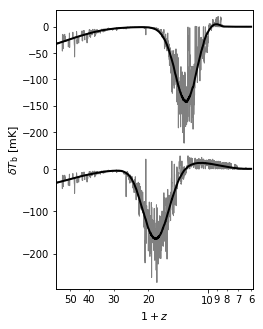

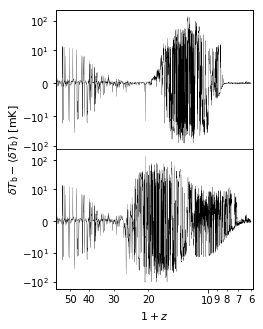

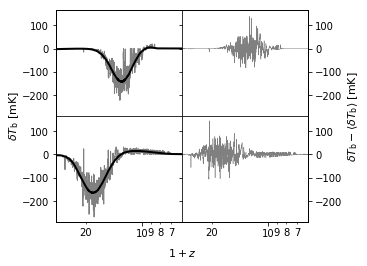

In [21]:
if ('3' in plots) or ('3a' in plots):

    fig, axs = PLT.subplots(nrows=2, ncols=1, sharex=True, figsize=(3.5,4.5))
    for modelind,model in enumerate(modelnames):
#         for pixi in range(10):
        for pixi in [5000]:
#             axs[modelind].plot(1+sampled_los_qtys[model]['redshifts'], sampled_los_qtys[model]['delta_T']['cube'][pixi,:].to('mK'), ls='-', lw=0.1, color='cyan')
            axs[modelind].plot(1+sampled_los_qtys[model]['redshifts'], sampled_los_qtys[model]['delta_T_prediction']['cube'][pixi,:].to('mK'), ls='-', lw=1.0, color='gray')
#         axs[modelind].plot(1+sampled_los_qtys[model]['redshifts'], sampled_los_qtys[model]['delta_T']['monopole'].to('mK'), ls='-', lw=2, color='cyan')
        axs[modelind].plot(1+sampled_los_qtys[model]['redshifts'], sampled_los_qtys[model]['delta_T_prediction']['monopole'].to('mK'), ls='-', lw=2, color='black')
    axs[modelind].set_xlim(59,5.9)
    axs[-1].set_xscale('log')
    axs[-1].set_xlabel(r'$1+z$', weight='medium', fontsize=11)
    tickformatter = ticker.FuncFormatter(lambda x, _: '{:.6g}'.format(x))
    axs[-1].xaxis.set_major_formatter(tickformatter)
    axs[-1].xaxis.set_minor_formatter(tickformatter)

    fig.subplots_adjust(hspace=0, wspace=0)
    fig.subplots_adjust(left=0.2, right=0.98, bottom=0.12, top=0.98)
    big_ax = fig.add_subplot(111)
    big_ax.set_facecolor('none') # matplotlib.__version__ >= 2.0.0
    # big_ax.set_axis_bgcolor('none') # matplotlib.__version__ < 2.0.0
    big_ax.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
    big_ax.set_xticks([])
    big_ax.set_yticks([])
    big_ax.set_ylabel(r'$\delta T_\mathrm{b}$ [mK]', fontsize=11, weight='medium', labelpad=35)
    
    PLT.savefig(figdir+'predicted_brightness_temperatures.pdf', bbox_inches=0)
    print(figdir+'predicted_brightness_temperatures.pdf')    
    
    fig, axs = PLT.subplots(nrows=2, ncols=1, sharex=True, figsize=(3.5,4.5))
    for modelind,model in enumerate(modelnames):
        axs[modelind].plot(1+sampled_los_qtys[model]['redshifts'], sampled_los_qtys[model]['delta_T_prediction']['cube'][5000,:].to('mK') - sampled_los_qtys[model]['delta_T_prediction']['monopole'].to('mK'), ls='-', lw=0.2, color='black')
        axs[modelind].set_yscale('symlog', linthreshy=10)
#         axs[modelind].plot(1+sampled_los_qtys[model]['redshifts'], sampled_los_qtys[model]['delta_T_prediction']['monopole'].to('mK'), ls='-', lw=2, color='black')
    axs[modelind].set_xlim(59,5.9)
    axs[-1].set_xscale('log')
    axs[-1].set_xlabel(r'$1+z$', weight='medium', fontsize=11)
    tickformatter = ticker.FuncFormatter(lambda x, _: '{:.6g}'.format(x))
    axs[-1].xaxis.set_major_formatter(tickformatter)
    axs[-1].xaxis.set_minor_formatter(tickformatter)

    fig.subplots_adjust(hspace=0, wspace=0)
    fig.subplots_adjust(left=0.2, right=0.98, bottom=0.12, top=0.98)
    big_ax = fig.add_subplot(111)
    big_ax.set_facecolor('none') # matplotlib.__version__ >= 2.0.0
    # big_ax.set_axis_bgcolor('none') # matplotlib.__version__ < 2.0.0
    big_ax.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
    big_ax.set_xticks([])
    big_ax.set_yticks([])
    big_ax.set_ylabel(r'$\delta T_\mathrm{b} - \langle \delta T_\mathrm{b}\rangle$ [mK]', fontsize=11, weight='medium', labelpad=35)
    
    PLT.savefig(figdir+'predicted_differential_brightness_temperatures.pdf', bbox_inches=0)
    print(figdir+'predicted_differential_brightness_temperatures.pdf')    
    
    fig, axs = PLT.subplots(nrows=len(modelnames), ncols=2, sharex=True, sharey=True, figsize=(2.5*len(modelnames),3.5))
    pixi = 5000
    for modelind,model in enumerate(modelnames):
        axs[modelind,0].plot(1+sampled_los_qtys[model]['redshifts'], sampled_los_qtys[model]['delta_T_prediction']['cube'][pixi,:].to('mK'), ls='-', lw=1, color='gray')
        axs[modelind,0].plot(1+sampled_los_qtys[model]['redshifts'], sampled_los_qtys[model]['delta_T_prediction']['monopole'].to('mK'), ls='-', lw=2, color='black')
        axs[modelind,1].plot(1+sampled_los_qtys[model]['redshifts'], sampled_los_qtys[model]['delta_T_prediction']['cube'][5000,:].to('mK') - sampled_los_qtys[model]['delta_T_prediction']['monopole'].to('mK'), ls='-', lw=0.5, color='gray')
    axs[-1,0].set_xlim(29,6.1)
    axs[-1,0].set_xscale('log')
    tickformatter = ticker.FuncFormatter(lambda x, _: '{:.6g}'.format(x))
    axs[-1,0].xaxis.set_major_formatter(tickformatter)
    axs[-1,0].xaxis.set_minor_formatter(tickformatter)
    axs[0,1].tick_params(axis='y', which='both', right=True, labelright=True)
    axs[-1,1].tick_params(axis='y', which='both', right=True, labelright=True)
#     axs[-1,0].tick_params(axis='x', which='both', labelrotation=90)
#     axs[-1,1].tick_params(axis='x', which='both', labelrotation=90)

    fig.subplots_adjust(hspace=0, wspace=0)
    fig.subplots_adjust(left=0.15, right=0.85, bottom=0.14, top=0.98)

    big_ax = fig.add_subplot(111)
    big_ax.set_facecolor('none') # matplotlib.__version__ >= 2.0.0
    # big_ax.set_axis_bgcolor('none') # matplotlib.__version__ < 2.0.0
    big_ax.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
    big_ax.set_xticks([])
    big_ax.set_yticks([])
    big_ax.set_ylabel(r'$\delta T_\mathrm{b}$ [mK]', fontsize=11, weight='medium', labelpad=35)
    big_ax.set_xlabel(r'$1+z$', weight='medium', fontsize=11, labelpad=25)
    big_axr = big_ax.twinx()
    big_axr.set_facecolor('none') # matplotlib.__version__ >= 2.0.0
    big_axr.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
    big_axr.set_xticks([])
    big_axr.set_yticks([])
    big_axr.set_ylabel(r'$\delta T_\mathrm{b} - \langle \delta T_\mathrm{b}\rangle$ [mK]', fontsize=11, weight='medium', labelpad=38)

    PLT.savefig(figdir+'predicted_dTb.pdf', bbox_inches=0)
    print(figdir+'predicted_dTb.pdf')    


### 3a) Plot neutral fraction evolution with redshift

/lustre/aoc/users/nthyagar/projects/21cmforest/figures/neutral_fraction.pdf


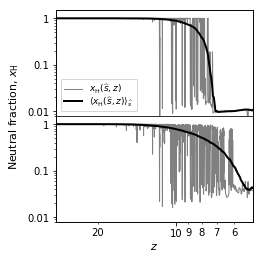

In [24]:
if ('3' in plots) or ('3a' in plots):

    fig, axs = PLT.subplots(nrows=len(modelnames), sharex=True, sharey=True, figsize=(3.5,3.5))
    pixi = 5000
    for modelind,model in enumerate(modelnames):
        axs[modelind].plot(sampled_los_qtys[model]['redshifts'], sampled_los_qtys[model]['x_H']['cube'][pixi,:].decompose(), ls='-', lw=1, color='gray', label=r'$x_\mathrm{H}(\widehat{s},z)$')
        axs[modelind].plot(sampled_los_qtys[model]['redshifts'], sampled_los_qtys[model]['x_H']['monopole'].decompose(), ls='-', lw=2, color='black', label=r'$\left\langle x_\mathrm{H}(\widehat{s},z)\right\rangle_\widehat{s}$')
    axs[0].legend(loc='lower left', shadow=False, fontsize=9, labelspacing=0)
    axs[-1].set_xlim(29,5.1)
    axs[-1].set_xscale('log')
    axs[-1].set_yscale('log')
    axs[-1].set_ylim(8e-3,1.5)
    
    tickformatter = ticker.FuncFormatter(lambda x, _: '{:.6g}'.format(x))
    axs[-1].xaxis.set_major_formatter(tickformatter)
    axs[-1].xaxis.set_minor_formatter(tickformatter)
    axs[-1].yaxis.set_major_formatter(tickformatter)
    fig.subplots_adjust(hspace=0, wspace=0)
    fig.subplots_adjust(left=0.2, right=0.98, bottom=0.14, top=0.98)

    big_ax = fig.add_subplot(111)
    big_ax.set_facecolor('none') # matplotlib.__version__ >= 2.0.0
    # big_ax.set_axis_bgcolor('none') # matplotlib.__version__ < 2.0.0
    big_ax.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
    big_ax.set_xticks([])
    big_ax.set_yticks([])
    big_ax.set_ylabel(r'Neutral Fraction, $x_\mathrm{H}$', fontsize=11, weight='medium', labelpad=35)
    big_ax.set_xlabel(r'$z$', weight='medium', fontsize=11, labelpad=20)

    PLT.savefig(figdir+'neutral_fraction.pdf', bbox_inches=0)
    print(figdir+'neutral_fraction.pdf')    


### 3a) Plot $T_\textrm{s}$ and $T_\textrm{cmb}$ evolution with redshift

/lustre/aoc/users/nthyagar/projects/21cmforest/figures/spin_temperature.pdf


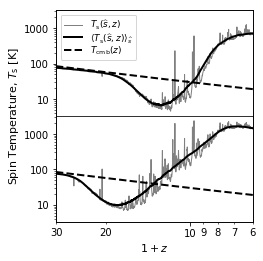

In [62]:
if ('3' in plots) or ('3a' in plots):

    fig, axs = PLT.subplots(nrows=len(modelnames), sharex=True, sharey=True, figsize=(3.5,3.5))
    pixi = 5000
    for modelind,model in enumerate(modelnames):
        axs[modelind].plot(1+sampled_los_qtys[model]['redshifts'], sampled_los_qtys[model]['T_s']['cube'][pixi,:].decompose(), ls='-', lw=1, color='gray', label=r'$T_\mathrm{s}(\widehat{s},z)$')
        axs[modelind].plot(1+sampled_los_qtys[model]['redshifts'], sampled_los_qtys[model]['T_s']['monopole'].decompose(), ls='-', lw=2, color='black', label=r'$\left\langle T_\mathrm{s}(\widehat{s},z)\right\rangle_\widehat{s}$')
        axs[modelind].plot(sampled_los_qtys[model]['redshifts'], sampled_los_qtys[model]['cosmo'].Tcmb0.to('K') * (1+sampled_los_qtys[model]['redshifts']), ls='--', lw=2, color='black', label=r'$T_\mathrm{cmb}(z)$')
    axs[0].legend(loc='upper left', shadow=False, fontsize=9, labelspacing=0)
    axs[-1].set_xlim(30,6)
    axs[-1].set_xscale('log')
    axs[-1].set_yscale('log')
    
    tickformatter = ticker.FuncFormatter(lambda x, _: '{:.6g}'.format(x))
    axs[-1].xaxis.set_major_formatter(tickformatter)
    axs[-1].xaxis.set_minor_formatter(tickformatter)
    axs[-1].yaxis.set_major_formatter(tickformatter)
    fig.subplots_adjust(hspace=0, wspace=0)
    fig.subplots_adjust(left=0.2, right=0.98, bottom=0.14, top=0.98)

    big_ax = fig.add_subplot(111)
    big_ax.set_facecolor('none') # matplotlib.__version__ >= 2.0.0
    # big_ax.set_axis_bgcolor('none') # matplotlib.__version__ < 2.0.0
    big_ax.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
    big_ax.set_xticks([])
    big_ax.set_yticks([])
    big_ax.set_ylabel(r'Spin Temperature, $T_\mathrm{s}$ [K]', fontsize=11, weight='medium', labelpad=35)
    big_ax.set_xlabel(r'$1+z$', weight='medium', fontsize=11, labelpad=20)

    PLT.savefig(figdir+'spin_temperature.pdf', bbox_inches=0)
    print(figdir+'spin_temperature.pdf')    


### 3b) Plot comparison of $T_\mathrm{s}$, $T_\mathrm{cmb}$, and $T_\mathrm{qso}$ both in temperature and flux density units

/lustre/aoc/users/nthyagar/projects/21cmforest/figures/comparison_of_temperatures_Bright_galaxies_fiducial_1024.pdf
/lustre/aoc/users/nthyagar/projects/21cmforest/figures/comparison_of_temperatures_Faint_galaxies_fiducial_1024.pdf
/lustre/aoc/users/nthyagar/projects/21cmforest/figures/comparison_of_fluxdensities_Bright_galaxies_fiducial_1024.pdf
/lustre/aoc/users/nthyagar/projects/21cmforest/figures/comparison_of_fluxdensities_Faint_galaxies_fiducial_1024.pdf
/lustre/aoc/users/nthyagar/projects/21cmforest/figures/comparison_of_fluxdensities.pdf


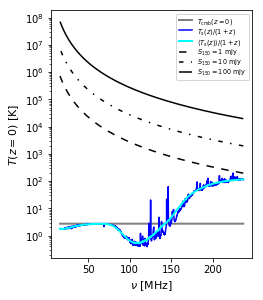

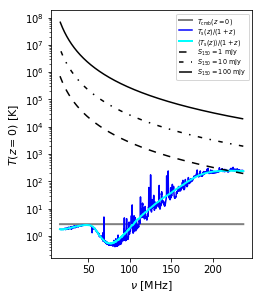

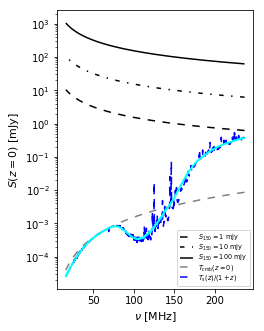

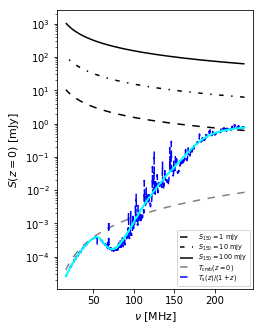

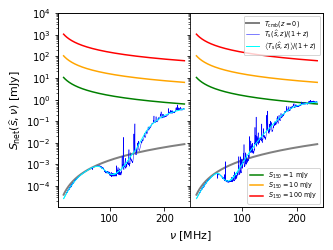

In [90]:
if ('3' in plots) or ('3a' in plots):
    uniq_beam_majax, uniq_beamind = NP.unique(beam_majax.to('arcsec').value, return_index=True)
    uniq_flux, uniq_flux_ind = NP.unique(flux_density_obs.to('uJy').value, return_index=True)
    lstyles = [(0, (5, 5)), (0, (3, 5, 1, 5)), (0, ()), (0, (1, 1))]
    colrs = ['green', 'orange', 'red']

    for modelind,model in enumerate(modelnames):
        fig, ax = PLT.subplots(nrows=1, ncols=1, sharex=True, sharey=True, figsize=(3.5,4))
        ax.plot(freq_redshift.to('MHz'), sampled_los_qtys[model]['cosmo'].Tcmb0.to('K') * NP.ones(freq_redshift.size), ls='-', lw=2, color='gray', label=r'$T_\mathrm{cmb}(z=0)$')
        ax.plot(freq_redshift.to('MHz'), sampled_los_qtys[model]['T_s']['cube'][5000,:].to('K')/(1+sampled_los_qtys[model]['redshifts']), color='blue', ls='-', label=r'$T_\mathrm{s}(z)/(1+z)$')
        ax.plot(freq_redshift.to('MHz'), sampled_los_qtys[model]['T_s']['monopole'].to('K')/(1+sampled_los_qtys[model]['redshifts']), color='cyan', ls='-', lw=2, label=r'$\langle T_\mathrm{s}(z)\rangle/(1+z)$')
        for beamind in range(beam_sa_0.size):        
            ax.plot(freq_redshift.to('MHz'), obsframe_temp_qso_spectrum[beamind,:].to('K'), ls=lstyles[beamind], color='black', label=r'$S_{150}=$'+'{0:.0f} mJy'.format(flux_density_obs[beamind].to('mJy').value))
        ax.set_yscale('log')
        ax.legend(loc='upper right', shadow=False, fontsize=6.5, labelspacing=0)
        ax.set_xlabel(r'$\nu$ [MHz]', weight='medium', fontsize=11)
        ax.set_ylabel(r'$T(z=0)$ [K]', weight='medium', fontsize=11)
        fig.subplots_adjust(left=0.18, right=0.98, bottom=0.12, top=0.98)
        
        PLT.savefig(figdir+'comparison_of_temperatures_{0}.pdf'.format(model), bbox_inches=0)
        print(figdir+'comparison_of_temperatures_{0}.pdf'.format(model))            

    for modelind,model in enumerate(modelnames):
        fig, ax = PLT.subplots(nrows=1, ncols=1, sharex=True, sharey=True, figsize=(3.5,4.5))
        for fluxind in range(flux_obs.size):
            if fluxind in uniq_flux_ind:
                ax.plot(freq_redshift.to('MHz'), obsframe_fluxdensity_qso_spectrum[fluxind,:].to('mJy'), ls=lstyles[fluxind], color='black', label=r'$S_{150}=$'+'{0:.0f} mJy'.format(flux_density_obs[fluxind].to('mJy').value))
        for beamind in range(beam_sa_0.size):            
            if beamind in uniq_beamind:            
                ax.plot(freq_redshift.to('MHz'), sampled_los_qtys[model]['fluxdensity_Tcmb']['monopole'][beamind,:].to('mJy').value, ls=lstyles[beamind], color='gray', label=r'$T_\mathrm{cmb}(z=0)$')
                ax.plot(freq_redshift.to('MHz'), sampled_los_qtys[model]['fluxdensity_T_s']['cube'][beamind,5000,:].to('mJy').value, color='blue', ls=lstyles[beamind], label=r'$T_\mathrm{s}(z)/(1+z)$')
                ax.plot(freq_redshift.to('MHz'), sampled_los_qtys[model]['fluxdensity_T_s']['monopole'][beamind,:].to('mJy').value, color='cyan', ls='-', lw=2)
#                 ax.plot(freq_redshift.to('MHz'), sampled_los_qtys[model]['fluxdensity_T_s']['monopole'][beamind,:].to('mJy').value, color='cyan', ls='-', lw=2, label=r'$\langle T_\mathrm{s}(z)\rangle/(1+z),\,\theta=$'+'{0:.1f}'.format(beam_majax[beamind].to('arcsec').value)+r'$^{\prime\,\prime}$')
        ax.set_yscale('log')
        ax.legend(loc='lower right', shadow=False, fontsize=6.5, labelspacing=0)
        ax.set_xlabel(r'$\nu$ [MHz]', weight='medium', fontsize=11)
        ax.set_ylabel(r'$S(z=0)$ [mJy]', weight='medium', fontsize=11)
        fig.subplots_adjust(left=0.2, right=0.98, bottom=0.12, top=0.98)
        
        PLT.savefig(figdir+'comparison_of_fluxdensities_{0}.pdf'.format(model), bbox_inches=0)
        print(figdir+'comparison_of_fluxdensities_{0}.pdf'.format(model))  
        
    fig, axs = PLT.subplots(ncols=len(modelnames), sharex=True, sharey=True, figsize=(2.25*len(modelnames), 3.5))
    for modelind,model in enumerate(modelnames):
        lines1 = []
        lines2 = []
        for fluxind in range(flux_obs.size):
            if fluxind in uniq_flux_ind:
                lines1 += axs[modelind].plot(freq_redshift.to('MHz'), obsframe_fluxdensity_qso_spectrum[fluxind,:].to('mJy'), ls='-', color=colrs[fluxind], label=r'$S_{150}=$'+'{0:.0f} mJy'.format(flux_density_obs[fluxind].to('mJy').value))
        for beamind in range(beam_sa_0.size):            
            if beamind in uniq_beamind:            
                lines2 += axs[modelind].plot(freq_redshift.to('MHz'), sampled_los_qtys[model]['fluxdensity_Tcmb']['monopole'][beamind,:].to('mJy').value, ls='-', lw=2, color='gray', label=r'$T_\mathrm{cmb}(z=0)$')
                lines2 += axs[modelind].plot(freq_redshift.to('MHz'), sampled_los_qtys[model]['fluxdensity_T_s']['cube'][beamind,5000,:].to('mJy').value, color='blue', ls='-', lw=0.5, label=r'$T_\mathrm{s}(\widehat{s},z)/(1+z)$')
                lines2 += axs[modelind].plot(freq_redshift.to('MHz'), sampled_los_qtys[model]['fluxdensity_T_s']['monopole'][beamind,:].to('mJy').value, color='cyan', ls='-', lw=1, label=r'$\left\langle T_\mathrm{s}(\widehat{s},z)\right\rangle/(1+z)$')
#                 ax.plot(freq_redshift.to('MHz'), sampled_los_qtys[model]['fluxdensity_T_s']['monopole'][beamind,:].to('mJy').value, color='cyan', ls='-', lw=2, label=r'$\langle T_\mathrm{s}(z)\rangle/(1+z),\,\theta=$'+'{0:.1f}'.format(beam_majax[beamind].to('arcsec').value)+r'$^{\prime\,\prime}$')
    axs[0].set_yscale('log')
    axs[0].set_ylim(ymax=1e4)
    leg1 = axs[1].legend(handles=lines1, loc='lower right', shadow=False, fontsize=6.5, labelspacing=0)
    leg2 = axs[1].legend(handles=lines2, loc='upper right', shadow=False, fontsize=6.5, labelspacing=0)
    axs[1].add_artist(leg1)

    fig.subplots_adjust(hspace=0, wspace=0)
    fig.subplots_adjust(left=0.16, right=0.98, bottom=0.18, top=0.95)
    
    big_ax = fig.add_subplot(111)
    big_ax.set_facecolor('none') # matplotlib.__version__ >= 2.0.0
    # big_ax.set_axis_bgcolor('none') # matplotlib.__version__ < 2.0.0
    big_ax.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
    big_ax.set_xticks([])
    big_ax.set_yticks([])
    big_ax.set_xlabel(r'$\nu$ [MHz]', weight='medium', fontsize=11, labelpad=22)
    big_ax.set_ylabel(r'$S_\mathrm{net}(\widehat{s},\nu)$ [mJy]', weight='medium', fontsize=11, labelpad=35)

    PLT.savefig(figdir+'comparison_of_fluxdensities.pdf', bbox_inches=0)
    print(figdir+'comparison_of_fluxdensities.pdf')  

### 3b) Plot LOS and sky-averaged optical depth as a function of redshift 

/lustre/aoc/users/nthyagar/projects/21cmforest/figures/optical_depth_Bright_galaxies_fiducial_1024.pdf
/lustre/aoc/users/nthyagar/projects/21cmforest/figures/optical_depth_Faint_galaxies_fiducial_1024.pdf
/lustre/aoc/users/nthyagar/projects/21cmforest/figures/optical_depth.pdf


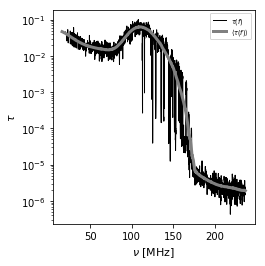

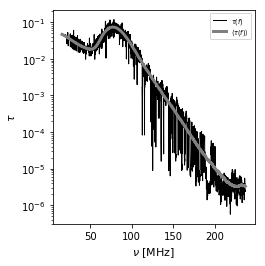

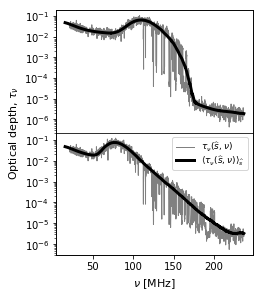

In [175]:
if ('3' in plots) or ('3a' in plots):

    for modelind,model in enumerate(modelnames):
        fig, ax = PLT.subplots(nrows=1, ncols=1, sharex=True, sharey=True, figsize=(3.5,3.5))
        ax.plot(freq_redshift.to('MHz'), sampled_los_qtys[model]['optical_depth']['cube'][5000,:], color='black', ls='-', lw=1, label=r'$\tau(f)$')
        ax.plot(freq_redshift.to('MHz'), sampled_los_qtys[model]['optical_depth']['monopole'], color='gray', ls='-', lw=3, label=r'$\langle\tau(f)\rangle$')
        ax.set_yscale('log')
        ax.legend(loc='upper right', shadow=False, fontsize=6.5, labelspacing=0)
        ax.set_xlabel(r'$\nu$ [MHz]', weight='medium', fontsize=11)
        ax.set_ylabel(r'$\tau$', weight='medium', fontsize=11)
        fig.subplots_adjust(left=0.18, right=0.98, bottom=0.13, top=0.98)
        
        PLT.savefig(figdir+'optical_depth_{0}.pdf'.format(model), bbox_inches=0)
        print(figdir+'optical_depth_{0}.pdf'.format(model))            
        
    fig, axs = PLT.subplots(nrows=len(modelnames), ncols=1, sharex=True, figsize=(3.5,2*len(modelnames)))
    for modelind,model in enumerate(modelnames):
        axs[modelind].plot(freq_redshift.to('MHz'), sampled_los_qtys[model]['optical_depth']['cube'][5000,:], color='gray', ls='-', lw=1, label=r'$\tau_\nu(\widehat{s},\nu)$')
        axs[modelind].plot(freq_redshift.to('MHz'), sampled_los_qtys[model]['optical_depth']['monopole'], color='black', ls='-', lw=3, label=r'$\left\langle\tau_\nu(\widehat{s},\nu)\right\rangle_\widehat{s}$')
        axs[modelind].set_yscale('log')
    axs[modelind].legend(loc='upper right', shadow=False, fontsize=9, labelspacing=0)

    fig.subplots_adjust(hspace=0, wspace=0)
    fig.subplots_adjust(left=0.2, right=0.98, bottom=0.13, top=0.98)

    big_ax = fig.add_subplot(111)
    big_ax.set_facecolor('none') # matplotlib.__version__ >= 2.0.0
    # big_ax.set_axis_bgcolor('none') # matplotlib.__version__ < 2.0.0
    big_ax.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
    big_ax.set_xticks([])
    big_ax.set_yticks([])
    big_ax.set_ylabel(r'Optical depth, $\tau_\nu$', fontsize=11, weight='medium', labelpad=35)
    big_ax.set_xlabel(r'$\nu$ [MHz]', weight='medium', fontsize=11, labelpad=22)

    PLT.savefig(figdir+'optical_depth.pdf', bbox_inches=0)
    print(figdir+'optical_depth.pdf')            

### 3b) Plot a specific LOS observed spectrum in flux density and temperature units containing a QSO or CMB-only background

/lustre/aoc/users/nthyagar/projects/21cmforest/figures/observable_fluxdensity_Bright_galaxies_fiducial_1024.pdf
/lustre/aoc/users/nthyagar/projects/21cmforest/figures/observable_fluxdensity_Faint_galaxies_fiducial_1024.pdf
/lustre/aoc/users/nthyagar/projects/21cmforest/figures/observable_brightness_temperature_Bright_galaxies_fiducial_1024.pdf
/lustre/aoc/users/nthyagar/projects/21cmforest/figures/observable_brightness_temperature_Faint_galaxies_fiducial_1024.pdf


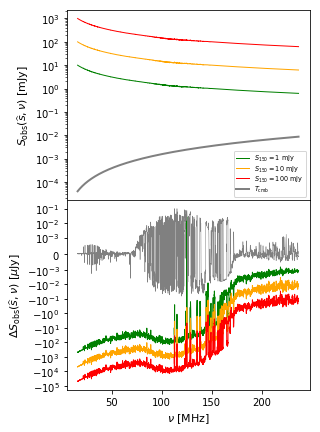

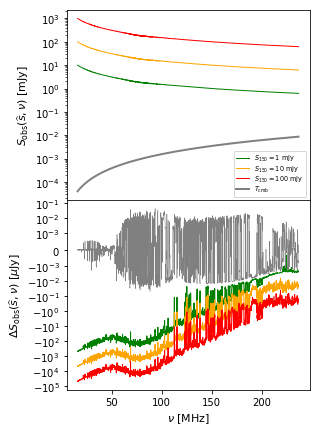

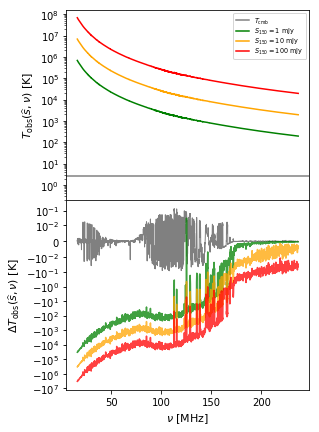

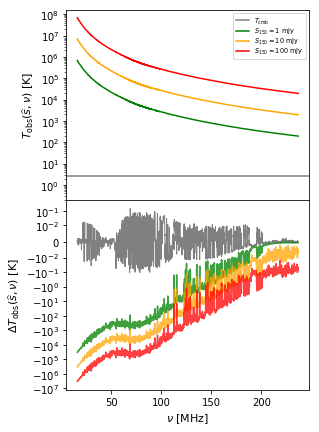

In [60]:
if ('3' in plots) or ('3a' in plots):
    uniq_beam_majax, uniq_beamind = NP.unique(beam_majax.to('arcsec').value, return_index=True)
    uniq_flux, uniq_flux_ind = NP.unique(flux_density_obs.to('uJy').value, return_index=True)
    colrs = ['green', 'orange', 'red']
    
    for modelind,model in enumerate(modelnames):
        fig, axs = PLT.subplots(nrows=2, ncols=1, sharex=True, figsize=(4.5,6))
        for fluxind in range(flux_obs.size):
#             if fluxind in uniq_flux_ind:
            axs[0].plot(freq_redshift.to('MHz'), sampled_los_qtys[model]['fluxdensity_Tb_bg_net']['nomonopole'][fluxind,5000,:].to('mJy'), lw=1, color=colrs[fluxind], label=r'$S_\mathrm{150}=$'+'{0:.0f} mJy'.format(flux_density_obs[fluxind].to('mJy').value))
            axs[1].plot(freq_redshift.to('MHz'), sampled_los_qtys[model]['fluxdensity_Tb_bg_net']['nomonopole'][fluxind,5000,:].to('uJy') - obsframe_fluxdensity_qso_spectrum[fluxind,:].to('uJy'), lw=1, color=colrs[fluxind])
        for beamind in range(beam_majax.size):
            if beamind in uniq_beamind:
                axs[0].plot(freq_redshift.to('MHz'), sampled_los_qtys[model]['fluxdensity_Tcmb']['monopole'][beamind,:].to('mJy'), lw=2, color='gray', label=r'$T_\mathrm{cmb}$')
                axs[1].plot(freq_redshift.to('MHz'), sampled_los_qtys[model]['fluxdensity_delta_T_prediction']['nomonopole'][fluxind,5000,:].to('uJy'), lw=0.5, color='gray')
        axs[0].set_yscale('log')
#         axs[1].set_xscale('log')
        axs[1].set_yscale('symlog', linthreshy=0.001)
#         axs[1].set_xlim(50,200)
#         axs[1].set_ylim(ymin=-1e6)
        axs[1].set_xlabel(r'$\nu$ [MHz]', weight='medium', fontsize=11)
        axs[0].set_ylabel(r'$S_\mathrm{obs}(\widehat{s},\nu)$ [mJy]', weight='medium', fontsize=11)
        axs[1].set_ylabel(r'$\Delta S_\mathrm{obs}(\widehat{s},\nu)$ [$\mu$Jy]', weight='medium', fontsize=11)
        axs[0].legend(loc='lower right', shadow=False, fontsize=6.5, labelspacing=0)
        fig.subplots_adjust(hspace=0, wspace=0)
        fig.subplots_adjust(left=0.2, right=0.95, bottom=0.1, top=0.98)

        PLT.savefig(figdir+'observable_fluxdensity_{0}.pdf'.format(model), bbox_inches=0)
        print(figdir+'observable_fluxdensity_{0}.pdf'.format(model))            
        
    for modelind,model in enumerate(modelnames):
        fig, axs = PLT.subplots(nrows=2, ncols=1, sharex=True, figsize=(4.5,6))
        axs[0].axhline(y=sampled_los_qtys[model]['cosmo'].Tcmb0.to('K').value, color='gray', label=r'$T_\mathrm{cmb}$')
        axs[1].plot(freq_redshift.to('MHz'), sampled_los_qtys[model]['delta_T_prediction']['cube'][5000,:].to('K') - sampled_los_qtys[model]['delta_T_prediction']['monopole'].to('K').reshape(-1), ls='-', lw=1, color='gray')
        for fluxind in range(flux_obs.size):
            axs[0].plot(freq_redshift.to('MHz'), sampled_los_qtys[model]['obsframe_Tb_bg_net']['nomonopole'][fluxind,5000,:].to('K'), color=colrs[fluxind], label=r'$S_\mathrm{150}=$'+'{0:.0f} mJy'.format(flux_density_obs[fluxind].to('mJy').value))
            axs[1].plot(freq_redshift.to('MHz'), sampled_los_qtys[model]['obsframe_Tb_bg_net']['nomonopole'][fluxind,5000,:].to('K') - obsframe_temp_qso_spectrum[fluxind,:].to('K'), color=colrs[fluxind], alpha=0.75)
        axs[0].set_yscale('log')
        axs[0].set_ylim(ymin=0.2)
#         axs[1].set_xscale('log')
        axs[1].set_yscale('symlog', linthreshy=0.01)
#         axs[1].set_xlim(50,200)
#         axs[1].set_ylim(ymin=-1e6)
        axs[1].set_xlabel(r'$\nu$ [MHz]', weight='medium', fontsize=11)
        axs[0].set_ylabel(r'$T_\mathrm{obs}(\widehat{s},\nu)$ [K]', weight='medium', fontsize=11)
        axs[1].set_ylabel(r'$\Delta T_\mathrm{obs}(\widehat{s},\nu)$ [K]', weight='medium', fontsize=11)
        axs[0].legend(loc='upper right', shadow=False, fontsize=6.5, labelspacing=0)
        fig.subplots_adjust(hspace=0, wspace=0)
        fig.subplots_adjust(left=0.2, right=0.95, bottom=0.1, top=0.98)

        PLT.savefig(figdir+'observable_brightness_temperature_{0}.pdf'.format(model), bbox_inches=0)
        print(figdir+'observable_brightness_temperature_{0}.pdf'.format(model))            

### 3c) Plot a specific LOS observed spectrum relative to the background in flux density and temperature units containing a QSO or CMB-only background and the corresponding histogram of pixel values at different redshifts

/lustre/aoc/users/nthyagar/projects/21cmforest/figures/observable_differential_fluxdensity_z_8.0_Bright_galaxies_fiducial_1024.pdf
/lustre/aoc/users/nthyagar/projects/21cmforest/figures/observable_differential_fluxdensity_z_9.5_Bright_galaxies_fiducial_1024.pdf
/lustre/aoc/users/nthyagar/projects/21cmforest/figures/observable_differential_fluxdensity_z_11.0_Bright_galaxies_fiducial_1024.pdf
/lustre/aoc/users/nthyagar/projects/21cmforest/figures/observable_differential_fluxdensity_z_8.0_Faint_galaxies_fiducial_1024.pdf
/lustre/aoc/users/nthyagar/projects/21cmforest/figures/observable_differential_fluxdensity_z_9.5_Faint_galaxies_fiducial_1024.pdf
/lustre/aoc/users/nthyagar/projects/21cmforest/figures/observable_differential_fluxdensity_z_11.0_Faint_galaxies_fiducial_1024.pdf
/lustre/aoc/users/nthyagar/projects/21cmforest/figures/observable_differential_Tb_z_8.0_Bright_galaxies_fiducial_1024.pdf
/lustre/aoc/users/nthyagar/projects/21cmforest/figures/observable_differential_Tb_z_9.5_Brigh

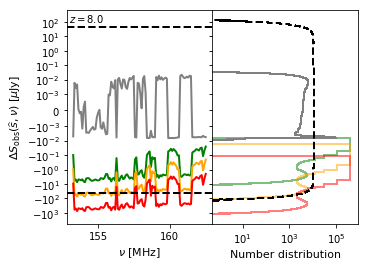

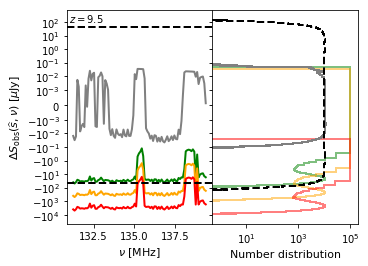

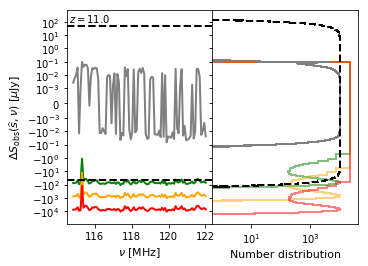

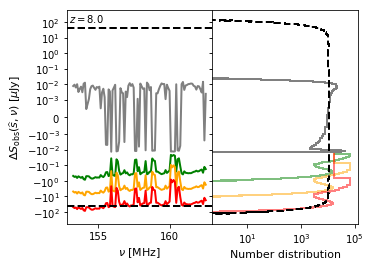

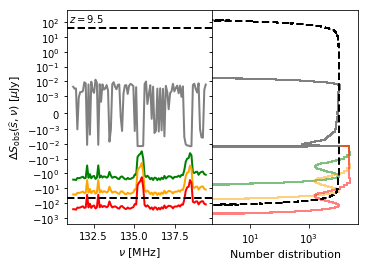

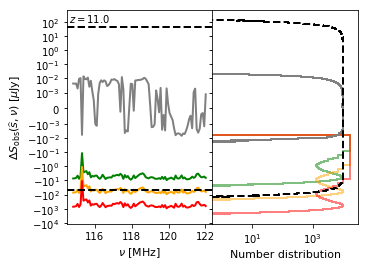

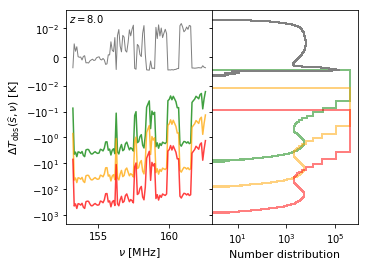

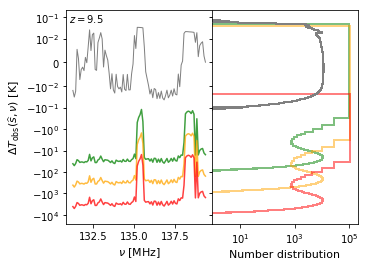

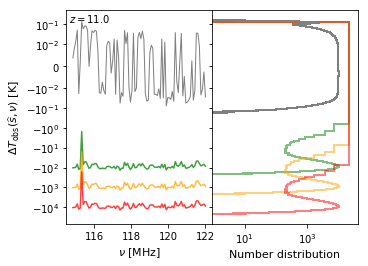

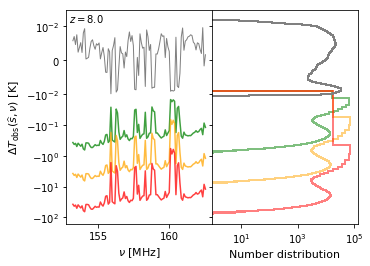

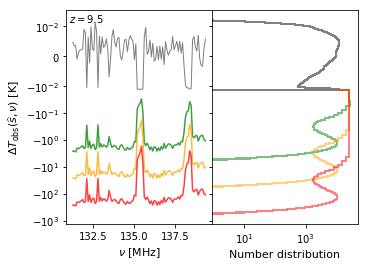

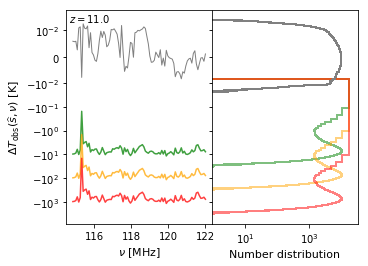

In [85]:
if ('3' in plots) or ('3a' in plots):
    delta_S_range = NP.asarray([[-1e2, 0.01], 
                                [-4e2, 0.0], 
                                [-1e3, -1e-2], 
                                [-2e4, -1e-1]])
    delta_T_range = [-1e7, 0.1]
    uniq_beam_majax, uniq_beamind = NP.unique(beam_majax.to('arcsec').value, return_index=True)
    uniq_flux, uniq_flux_ind = NP.unique(flux_density_obs.to('uJy').value, return_index=True)
    colrs = ['green', 'orange', 'red']
    
    for modelind,model in enumerate(modelnames):
        for zpsi, zps in enumerate(z_pspec):
            los_ind = NP.where(NP.abs(sampled_los_qtys[model]['d_los_comov'] - sampled_los_qtys[model]['cosmo'].comoving_distance(zps)) <= 0.5 * sampled_los_qtys[model]['d_los_comov_width'][zpsi])[0]
            rstate = NP.random.RandomState(randseed)
#             randpix = rstate.randint(nrand, size=1000)
            randpix = NP.arange(nrand)

            fig, axs = PLT.subplots(nrows=1, ncols=2, sharey=True, figsize=(5,3.5))
            for fluxind in range(flux_obs.size):
                mltdim_idx = NP.ix_([fluxind], randpix, los_ind)
                axs[0].plot(freq_redshift[los_ind].to('MHz'), sampled_los_qtys[model]['fluxdensity_Tb_bg_net']['nomonopole'][fluxind,5000,los_ind].to('uJy') - obsframe_fluxdensity_qso_spectrum[fluxind,los_ind].to('uJy'), lw=2, color=colrs[fluxind])
                dnsty, be, patches = axs[1].hist((sampled_los_qtys[model]['fluxdensity_Tb_bg_net']['nomonopole'][mltdim_idx][0].to('uJy') - obsframe_fluxdensity_qso_spectrum[fluxind,los_ind].to('uJy').reshape(1,-1)).reshape(-1), bins='auto', density=False, cumulative=False, log=True, orientation='horizontal', histtype='step', lw=2, color=colrs[fluxind], alpha=0.5)                
            for beamind in range(beam_majax.size):
                if beamind in uniq_beamind:
                    mltdim_idx = NP.ix_([beamind], randpix, los_ind)
                    axs[0].plot(freq_redshift[los_ind].to('MHz'), sampled_los_qtys[model]['fluxdensity_delta_T_prediction']['nomonopole'][fluxind,5000,los_ind].to('uJy'), lw=2, color='gray')
                    dnsty, be, patches = axs[1].hist(sampled_los_qtys[model]['fluxdensity_delta_T_prediction']['nomonopole'][mltdim_idx][0].to('uJy').reshape(-1), bins='auto', density=False, cumulative=False, log=True, orientation='horizontal', histtype='step', lw=2, color='gray')

            axs[0].axhline(1/NP.sqrt(2.0)*NP.mean(imgpixel_rms_fluxdensity_thalf_spectrum[los_ind].to('uJy').value), ls='--', lw=2, color='black')
            axs[0].axhline(-1/NP.sqrt(2.0)*NP.mean(imgpixel_rms_fluxdensity_thalf_spectrum[los_ind].to('uJy').value), ls='--', lw=2, color='black')
#             noise_mltdim_idx = NP.ix_([0,1], randpix, los_ind)
#             noise_dnsty, noise_be, patches = axs[1].hist(NP.sqrt(2.0)**2 * imgpixel_noise_fluxdensity_thalf_spectrum[noise_mltdim_idx].real.to('uJy').reshape(-1), bins='auto', density=False, cumulative=False, log=True, orientation='horizontal', histtype='step', lw=2, ls='--', color='black')
            noise_mltdim_idx = NP.ix_([0,1], randpix, los_ind)
            noise_dnsty, noise_be, patches = axs[1].hist(1/NP.sqrt(2.0)*NP.mean(imgpixel_noise_fluxdensity_thalf_spectrum[noise_mltdim_idx].to('uJy').value, axis=0).reshape(-1), bins='auto', density=False, cumulative=False, log=True, orientation='horizontal', histtype='step', lw=2, ls='--', color='black')
            axs[0].text(0.02, 0.99, r'$z=$'+'{0:.1f}'.format(zps), transform=axs[0].transAxes, ha='left', va='top')
            axs[1].set_yscale('symlog', linthreshy=0.001)
            axs[1].set_xlim(xmin=0.5)
            axs[0].set_xlabel(r'$\nu$ [MHz]', weight='medium', fontsize=11)
            axs[1].set_xlabel('Number distribution', weight='medium', fontsize=11)
            axs[0].set_ylabel(r'$\Delta S_\mathrm{obs}(\widehat{s},\nu)$ [$\mu$Jy]', weight='medium', fontsize=11)
            fig.subplots_adjust(hspace=0, wspace=0)
            fig.subplots_adjust(left=0.17, right=0.98, top=0.98, bottom=0.13)
            
            PLT.savefig(figdir+'observable_differential_fluxdensity_z_{0:.1f}_{1}.pdf'.format(zps, model), bbox_inches=0)
            print(figdir+'observable_differential_fluxdensity_z_{0:.1f}_{1}.pdf'.format(zps, model))
            
    for modelind,model in enumerate(modelnames):
        for zpsi, zps in enumerate(z_pspec):
            los_ind = NP.where(NP.abs(sampled_los_qtys[model]['d_los_comov'] - sampled_los_qtys[model]['cosmo'].comoving_distance(zps)) <= 0.5 * sampled_los_qtys[model]['d_los_comov_width'][zpsi])[0]
            rstate = NP.random.RandomState(randseed)
#             randpix = rstate.randint(nrand, size=1000)
            randpix = NP.arange(nrand)

            fig, axs = PLT.subplots(nrows=1, ncols=2, sharey=True, figsize=(5,3.5))
            for fluxind in range(flux_obs.size):
                mltdim_idx = NP.ix_([fluxind], randpix, los_ind)
                axs[0].plot(freq_redshift[los_ind].to('MHz'), sampled_los_qtys[model]['obsframe_Tb_bg_net']['nomonopole'][fluxind,5000,los_ind].to('K') - obsframe_temp_qso_spectrum[fluxind,los_ind].to('K'), color=colrs[fluxind], alpha=0.75)
                dnsty, be, patches = axs[1].hist((sampled_los_qtys[model]['obsframe_Tb_bg_net']['nomonopole'][mltdim_idx][0].to('K') - obsframe_temp_qso_spectrum[fluxind,los_ind].to('K').reshape(1,-1)).reshape(-1), bins='auto', density=False, cumulative=False, log=True, orientation='horizontal', histtype='step', lw=2, color=colrs[fluxind], alpha=0.5)                
            mltdim_idx = NP.ix_(randpix, los_ind)
            axs[0].plot(freq_redshift[los_ind].to('MHz'), sampled_los_qtys[model]['delta_T_prediction']['cube'][5000,los_ind].to('K') - sampled_los_qtys[model]['delta_T_prediction']['monopole'][los_ind].to('K').reshape(-1), ls='-', lw=1, color='gray')
            dnsty, be, patches = axs[1].hist((sampled_los_qtys[model]['delta_T_prediction']['cube'][mltdim_idx].to('K') - sampled_los_qtys[model]['delta_T_prediction']['monopole'][los_ind].to('K').reshape(1,-1)).value.reshape(-1), bins='auto', density=False, cumulative=False, log=True, orientation='horizontal', histtype='step', lw=2, color='gray')

#             axs[0].axhline(NP.sqrt(2.0)*NP.mean(imgpixel_rms_temperature_thalf_spectrum[los_ind].to('K').value), ls='--', lw=2, color='black')
#             axs[0].axhline(-NP.sqrt(2.0)*NP.mean(imgpixel_rms_temperature_thalf_spectrum[los_ind].to('K').value), ls='--', lw=2, color='black')
#             noise_mltdim_idx = NP.ix_([0], randpix, los_ind)
#             noise_dnsty, noise_be, patches = axs[1].hist(NP.sqrt(2.0)**2 * imgpixel_noise_temperature_thalf_spectrum[noise_mltdim_idx].real.to('K').reshape(-1), bins='auto', density=False, cumulative=False, log=True, orientation='horizontal', histtype='step', lw=2, ls='--', color='black')

            axs[0].text(0.02, 0.99, r'$z=$'+'{0:.1f}'.format(zps), transform=axs[0].transAxes, ha='left', va='top')
            axs[1].set_yscale('symlog', linthreshy=0.01)
            axs[1].set_xlim(xmin=0.9)
            axs[0].set_xlabel(r'$\nu$ [MHz]', weight='medium', fontsize=11)
            axs[1].set_xlabel('Number distribution', weight='medium', fontsize=11)
            axs[0].set_ylabel(r'$\Delta T_\mathrm{obs}(\widehat{s},\nu)$ [K]', weight='medium', fontsize=11)
            fig.subplots_adjust(hspace=0, wspace=0)
            fig.subplots_adjust(left=0.17, right=0.98, top=0.98, bottom=0.13)
            
            PLT.savefig(figdir+'observable_differential_Tb_z_{0:.1f}_{1}.pdf'.format(zps, model), bbox_inches=0)
            print(figdir+'observable_differential_Tb_z_{0:.1f}_{1}.pdf'.format(zps, model))

42.14608165620795
43.81338613922002
45.31055940611947
42.14608165620795
43.81338613922002
45.31055940611947
/lustre/aoc/users/nthyagar/projects/21cmforest/figures/observable_differential_fluxdensity_histogram.pdf


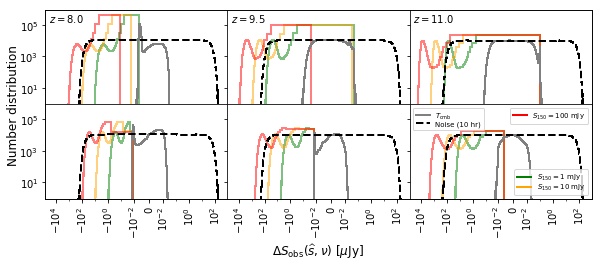

In [86]:
if ('3' in plots) or ('3a' in plots):
    uniq_beam_majax, uniq_beamind = NP.unique(beam_majax.to('arcsec').value, return_index=True)
    uniq_flux, uniq_flux_ind = NP.unique(flux_density_obs.to('uJy').value, return_index=True)
    colrs = ['green', 'orange', 'red']
    
    fig, axs = PLT.subplots(nrows=len(modelnames), ncols=z_pspec.size, sharex=True, sharey=True, figsize=(2.75*z_pspec.size,1.75*len(modelnames)))
    for modelind,model in enumerate(modelnames):
        for zpsi, zps in enumerate(z_pspec):
            los_ind = NP.where(NP.abs(sampled_los_qtys[model]['d_los_comov'] - sampled_los_qtys[model]['cosmo'].comoving_distance(zps)) <= 0.5 * sampled_los_qtys[model]['d_los_comov_width'][zpsi])[0]
            rstate = NP.random.RandomState(randseed)
            randpix = NP.arange(nrand)

            lines1 = []
            lines2 = []
            for fluxind in range(flux_obs.size):
                mltdim_idx = NP.ix_([fluxind], randpix, los_ind)
                dnsty, be, patches = axs[modelind,zpsi].hist((sampled_los_qtys[model]['fluxdensity_Tb_bg_net']['nomonopole'][mltdim_idx][0].to('uJy') - obsframe_fluxdensity_qso_spectrum[fluxind,los_ind].to('uJy').reshape(1,-1)).reshape(-1), bins='auto', density=False, cumulative=False, log=True, orientation='vertical', histtype='step', lw=2, color=colrs[fluxind], alpha=0.5, label=r'$S_{150}^\mathrm{qso}=$'+'{0} mJy'.format(flux_density_obs[fluxind].to('mJy').value))                
                lines1 += [Line2D([], [], ls='-', lw=2, color=colrs[fluxind], label=r'$S_{150}=$'+'{0:.0f} mJy'.format(flux_density_obs[fluxind].to('mJy').value))]
            for beamind in range(beam_majax.size):
                if beamind in uniq_beamind:
                    mltdim_idx = NP.ix_([beamind], randpix, los_ind)
                    dnsty, be, patches = axs[modelind,zpsi].hist(sampled_los_qtys[model]['fluxdensity_delta_T_prediction']['nomonopole'][mltdim_idx][0].to('uJy').reshape(-1), bins='auto', density=False, cumulative=False, log=True, orientation='vertical', histtype='step', lw=2, color='gray', label=r'$T_\mathrm{cmb}$')
                    lines2 += [Line2D([], [], ls='-', lw=2, color='gray', label=r'$T_\mathrm{cmb}$')] 

#             noise_mltdim_idx = NP.ix_([0], randpix, los_ind)
#             noise_dnsty, noise_be, patches = axs[modelind,zpsi].hist(NP.sqrt(2.0)**2 * imgpixel_noise_fluxdensity_thalf_spectrum[noise_mltdim_idx].real.to('uJy').reshape(-1), bins='auto', density=False, cumulative=False, log=True, orientation='vertical', histtype='step', lw=2, ls='--', color='black', label='Noise')
            noise_mltdim_idx = NP.ix_([0,1], randpix, los_ind)
            noise_dnsty, noise_be, patches = axs[modelind,zpsi].hist(NP.mean(imgpixel_noise_fluxdensity_thalf_spectrum[noise_mltdim_idx].to('uJy').value, axis=0).reshape(-1), bins='auto', density=False, cumulative=False, log=True, orientation='vertical', histtype='step', lw=2, ls='--', color='black', label='Noise ({0} hr)'.format(t_int.to('hr').value))
            lines2 += [Line2D([], [], ls='--', lw=2, color='black', label='Noise ({0:.0f} hr)'.format(t_int.to('hr').value))]
            print(NP.std(NP.mean(imgpixel_noise_fluxdensity_thalf_spectrum[noise_mltdim_idx].to('uJy').value, axis=0).reshape(-1)))
            if (modelind == 1) and (zpsi == 2):
                leg3 = axs[modelind,zpsi].legend(handles=lines2, loc='upper left', shadow=False, fontsize=7, labelspacing=0)
                leg2 = axs[modelind,zpsi].legend(handles=lines1[2:], loc='upper right', shadow=False, fontsize=7, labelspacing=0)
                leg1 = axs[modelind,zpsi].legend(handles=lines1[:2], loc='lower right', shadow=False, fontsize=7, labelspacing=0)
                axs[modelind,zpsi].add_artist(leg2)
                axs[modelind,zpsi].add_artist(leg3)
            if modelind == 0:
                axs[modelind,zpsi].text(0.02, 0.98, r'$z=$'+'{0:.1f}'.format(zps), transform=axs[modelind,zpsi].transAxes, ha='left', va='top')
            axs[modelind,zpsi].set_xscale('symlog', linthreshx=0.01)
            axs[modelind,zpsi].set_ylim(ymin=0.9)
            xticloc = ticker.SymmetricalLogLocator(linthresh=0.01, base=100.0)
            axs[modelind,zpsi].xaxis.set_major_locator(xticloc)
            axs[modelind,zpsi].tick_params(axis='x', labelrotation=90)

    fig.subplots_adjust(hspace=0, wspace=0)
    fig.subplots_adjust(left=0.07, right=0.99, top=0.98, bottom=0.23)

    big_ax = fig.add_subplot(111)
    big_ax.set_facecolor('none') # matplotlib.__version__ >= 2.0.0
    # big_ax.set_axis_bgcolor('none') # matplotlib.__version__ < 2.0.0
    big_ax.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
    big_ax.set_xticks([])
    big_ax.set_yticks([])
    big_ax.set_xlabel(r'$\Delta S_\mathrm{obs}(\widehat{s},\nu)$ [$\mu$Jy]', fontsize=12, weight='medium', labelpad=42)
    big_ax.set_ylabel('Number distribution', fontsize=12, weight='medium', labelpad=25)

    PLT.savefig(figdir+'observable_differential_fluxdensity_histogram.pdf', bbox_inches=0)
    print(figdir+'observable_differential_fluxdensity_histogram.pdf')


In [34]:
if ('3' in plots) or ('3a' in plots):

    pspec_kprll_onesided = {}
    pspec_kprll_onesided_differential = {}
    pspec_kprll_onesided_orig = {}
    noise_power_std_kprll_onesided = {}
    nmodes_onesided = {}
    nmodes_total_onesided = {}
    wlinv_kernel = {}
    kprll_onesided = {}
    nsamples_onesided = {}
    nsamples_required = {}
    nsamples_required_differential = {}
    nsamples_required_orig = {}
    nsamples_total_onesided = {}
    basic_sampstd_kprll_onesided = {}
    basic_uncertainty_kprll_onesided = {}        
    basic_sampstd_kprll_onesided_differential = {}
    basic_uncertainty_kprll_onesided_differential = {}        
    basic_sampstd_kprll_onesided_orig = {}
    basic_uncertainty_kprll_onesided_orig = {} 
    fg_wedge_boundary = {}
    for model in modelnames:
        tau_wedge_boundary = blmax_zpspec * fov_hwhm_dircos / FC.c # FD wedge boundary in delay units, (nbeams, n_zpspec)
        d_los_comov_wts = NP.empty((z_pspec.size, sampled_los_qtys[model]['d_los_comov'].size), dtype=NP.float_) # nz x nlos
        frac_width = DSP.window_N2width(n_window=None, shape=winshape, fftpow=fftpow, area_normalize=False, power_normalize=True)
        window_loss_factor = 1 / frac_width
        n_window = NP.round(window_loss_factor * (sampled_los_qtys[model]['d_los_comov_width']/sampled_los_qtys[model]['boxres']).decompose().value).astype(NP.int)
        d_los_comov_center_ind, ind_los_pixels, d_los_comov_offset = LKP.find_1NN(sampled_los_qtys[model]['d_los_comov'].to('Mpc').value.reshape(-1,1), sampled_los_qtys[model]['d_los_comov_center'].to('Mpc').value.reshape(-1,1), distance_ULIM=0.51*sampled_los_qtys[model]['boxres'].to('Mpc').value, remove_oob=True)
        sortind = NP.argsort(ind_los_pixels)
        d_los_comov_center_ind = d_los_comov_center_ind[sortind]
        ind_los_pixels = ind_los_pixels[sortind]
        d_los_comov_offset = d_los_comov_offset[sortind]
        n_window = n_window[sortind]

        for i,ind_los_pix in enumerate(ind_los_pixels):
            window = NP.sqrt(frac_width * n_window[i]) * DSP.window_fftpow(n_window[i], shape=winshape, fftpow=fftpow, centering=True, peak=None, area_normalize=False, power_normalize=True)
            window_lospix = sampled_los_qtys[model]['d_los_comov'].to('Mpc').value[ind_los_pix] + sampled_los_qtys[model]['boxres'].to('Mpc').value * (NP.arange(n_window[i]) - int(n_window[i]/2))
            ind_window_lospix, inds_lospix, dlos = LKP.find_1NN(sampled_los_qtys[model]['d_los_comov'].to('Mpc').value.reshape(-1,1), window_lospix.reshape(-1,1), distance_ULIM=0.51*sampled_los_qtys[model]['boxres'].to('Mpc').value, remove_oob=True)
            sind = NP.argsort(ind_window_lospix)
            ind_window_lospix = ind_window_lospix[sind]
            inds_lospix = inds_lospix[sind]
            dlos = dlos[sind]
            window = window[ind_window_lospix]
            window = NP.pad(window, ((inds_lospix.min(), sampled_los_qtys[model]['d_los_comov'].to('Mpc').value.size-1-inds_lospix.max())), mode='constant', constant_values=((0.0,0.0)))
            d_los_comov_wts[i,:] = window # nz x nlos
        npad = int(sampled_los_qtys[model]['d_los_comov'].size * pad)
        kprll_twosided = 2 * NP.pi * DSP.spectral_axis(sampled_los_qtys[model]['d_los_comov'].size + npad, delx=sampled_los_qtys[model]['boxres'].to('Mpc').value, use_real=False, shift=True) / U.Mpc 
        ndim_padtuple = [(0,0), (0,0), (0,0), (0,npad)] 
        ndim_padtuple_noise = [(0,0), (0,0), (0,0), (0,0), (0,npad)] 
        wlinv_krnl = DSP.FT1D(NP.pad(d_los_comov_wts, [(0,0), (0,npad)], mode='constant'), ax=-1, inverse=False, use_real=False, shift=True) * sampled_los_qtys[model]['boxres']

        fg_wedge_boundary[model] = []
        for zpsi, zps in enumerate(z_pspec):
            dkprll_dev_dtau_jacobian = DS.dkprll_deta(zps, cosmo=sampled_los_qtys[model]['cosmo']) * (1 / U.Mpc) / U.s # in Mpc^-1 s^-1
            fg_wedge_boundary[model] += [(tau_wedge_boundary * dkprll_dev_dtau_jacobian).to('Mpc-1')]
        fg_wedge_boundary[model] = NP.asarray(fg_wedge_boundary[model]) * (1 / U.Mpc)

        power_kprll_twosided = DSP.FT1D(NP.pad(d_los_comov_wts[NP.newaxis,:,NP.newaxis,:] * sampled_los_qtys[model]['fluxdensity_Tb_bg_net']['nomonopole'].to('Jy').value[:,NP.newaxis,:,:], ndim_padtuple, mode='constant'), ax=-1, inverse=False, use_real=False, shift=True) * U.Jy * sampled_los_qtys[model]['boxres'] * (wl_zpspec.reshape(1,-1,1,1)**2 / (2*FC.k_B*beam_sa_0.to('', equivalencies=U.dimensionless_angles()).reshape(-1,1,1,1))) # nbeam x nz_qso x npix x nlos
        power_kprll_twosided = NP.abs(power_kprll_twosided.to('mK Mpc')) ** 2 / sampled_los_qtys[model]['d_los_comov_width'].reshape(1,-1,1,1)

        power_kprll_twosided_differential = DSP.FT1D(NP.pad(d_los_comov_wts[NP.newaxis,:,NP.newaxis,:] * (sampled_los_qtys[model]['fluxdensity_Tb_bg_net']['nomonopole'][:,NP.newaxis,:,:] - obsframe_fluxdensity_qso_spectrum[:,NP.newaxis,NP.newaxis,:]).to('Jy').value, ndim_padtuple, mode='constant'), ax=-1, inverse=False, use_real=False, shift=True) * sampled_los_qtys[model]['boxres'] * U.Jy * (wl_zpspec.reshape(1,-1,1,1)**2 / (2*FC.k_B*beam_sa_0.to('', equivalencies=U.dimensionless_angles()).reshape(-1,1,1,1))) # nbeam x nz_qso x npix x nlos
        power_kprll_twosided_differential = NP.abs(power_kprll_twosided_differential.to('mK Mpc')) ** 2 / sampled_los_qtys[model]['d_los_comov_width'].reshape(1,-1,1,1)            

        power_kprll_twosided_orig = DSP.FT1D(NP.pad(d_los_comov_wts[NP.newaxis,:,NP.newaxis,:] * sampled_los_qtys[model]['fluxdensity_delta_T_prediction']['nomonopole'].to('Jy').value[:,NP.newaxis,:,:], ndim_padtuple, mode='constant'), ax=-1, inverse=False, use_real=False, shift=True) * U.Jy * sampled_los_qtys[model]['boxres'] * (wl_zpspec.reshape(1,-1,1,1)**2 / (2*FC.k_B*beam_sa_0.to('', equivalencies=U.dimensionless_angles()).reshape(-1,1,1,1))) # nbeam x nz_qso x npix x nlos
        power_kprll_twosided_orig = NP.abs(power_kprll_twosided_orig.to('mK Mpc')) ** 2 / sampled_los_qtys[model]['d_los_comov_width'].reshape(1,-1,1,1)

        downsample_factor = NP.min((sampled_los_qtys[model]['d_los_comov'].size + npad) * sampled_los_qtys[model]['boxres'] / sampled_los_qtys[model]['d_los_comov_width']).decompose().value

        # kprll_twosided = DSP.downsampler(kprll_twosided.value, downsample_factor, axis=-1, method='FFT') * kprll_twosided.unit
        # wlinv_kernel[model] = DSP.downsampler(wlinv_krnl.value, downsample_factor, axis=-1, method='FFT') * wlinv_krnl.unit
        # power_kprll_twosided = DSP.downsampler(power_kprll_twosided.value, downsample_factor, axis=-1, method='FFT') * power_kprll_twosided.unit

        negind = NP.arange(kprll_twosided.size//2 + 1)
        posind = kprll_twosided.size//2 + NP.arange((kprll_twosided.size+1)//2)
        nsamples_onesided[model] = NP.ones(kprll_twosided.size//2 + 1, dtype=NP.float)
        nsamples_onesided[model][1:(kprll_twosided.size + 1)//2] = 2.0

        kprll_onesided[model] = NP.abs(kprll_twosided[:kprll_twosided.size//2 + 1][::-1])
        kprll_onesided[model] = DSP.downsampler(kprll_onesided[model].value, downsample_factor, axis=-1, method='interp', kind='linear') * kprll_onesided[model].unit
        nsamples_onesided[model] = DSP.downsampler(nsamples_onesided[model], downsample_factor, axis=-1, method='interp', kind='linear')

        power_folded = OPS.reverse(power_kprll_twosided[:,:,:,negind].value, axis=3) * power_kprll_twosided.unit
        power_folded[:,:,:,:(kprll_twosided.size+1)//2] = power_folded[:,:,:,:(kprll_twosided.size+1)//2] + power_kprll_twosided[:,:,:,posind]
        pspec_kprll_onesided[model] = 0.5 * NP.median(power_folded, axis=-2)
        pspec_kprll_onesided[model] = DSP.downsampler(pspec_kprll_onesided[model].value, downsample_factor, axis=-1, method='interp', kind='cubic') * pspec_kprll_onesided[model].unit

        power_folded_differential = OPS.reverse(power_kprll_twosided_differential[:,:,:,negind].value, axis=3) * power_kprll_twosided_differential.unit
        power_folded_differential[:,:,:,:(kprll_twosided.size+1)//2] = power_folded_differential[:,:,:,:(kprll_twosided.size+1)//2] + power_kprll_twosided_differential[:,:,:,posind]
        pspec_kprll_onesided_differential[model] = 0.5 * NP.median(power_folded_differential, axis=-2)
        pspec_kprll_onesided_differential[model] = DSP.downsampler(pspec_kprll_onesided_differential[model].value, downsample_factor, axis=-1, method='interp', kind='cubic') * pspec_kprll_onesided_differential[model].unit

        power_folded_orig = OPS.reverse(power_kprll_twosided_orig[:,:,:,negind].value, axis=3) * power_kprll_twosided_orig.unit
        power_folded_orig[:,:,:,:(kprll_twosided.size+1)//2] = power_folded_orig[:,:,:,:(kprll_twosided.size+1)//2] + power_kprll_twosided_orig[:,:,:,posind]
        pspec_kprll_onesided_orig[model] = 0.5 * NP.median(power_folded_orig, axis=-2)
        pspec_kprll_onesided_orig[model] = DSP.downsampler(pspec_kprll_onesided_orig[model].value, downsample_factor, axis=-1, method='interp', kind='cubic') * pspec_kprll_onesided_orig[model].unit

        nmodes_onesided[model] = sampled_los_qtys[model]['d_los_comov_width'].reshape(-1,1) * kprll_onesided[model].reshape(1,-1) / (2 * NP.pi)
        nsamples_total_onesided[model] = nsamples_onesided[model].reshape(1,-1) * nmodes_onesided[model]
#         freq_resolution = sampled_los_qtys[model]['boxres'] * (sampled_los_qtys[model]['cosmo'].H0 * rest_freq * sampled_los_qtys[model]['cosmo'].efunc(z_pspec) ) / (FC.c * (1+z_pspec)**2)
#         bw = sampled_los_qtys[model]['d_los_comov_width'] * (sampled_los_qtys[model]['cosmo'].H0 * rest_freq * sampled_los_qtys[model]['cosmo'].efunc(z_pspec) ) / (FC.c * (1+z_pspec)**2)

#         noise_power_std_kprll_onesided[model] = ((Tsys / NP.sqrt(2 * n_ant * (n_ant-1) * freq_resolution.reshape(1,-1,1) * t_half) * efficiency_factor) * NP.sqrt((bw/freq_resolution).decompose().value.reshape(1,-1,1)) * freq_resolution.reshape(1,-1,1))**2 * sampled_los_qtys[model]['d_los_comov_width'].reshape(1,-1,1) / bw.reshape(1,-1,1)**2 / NP.sqrt(nsamples_onesided[model].reshape(1,1,-1)) # Factor 2 is for dual-pol, See SIRA II Eq.(9-23), sampled_los_qtys[model]['d_los_comov_width']/sampled_los_qtys[model]['boxres'] or bw/freq_resolution is for number of cells going into the Fourier transform, Factor of sampled_los_qtys[model]['d_los_comov_width'] comes due to the integral of the window function along LOS, NP.sqrt(nsamples_onesided[model]) is the reduction in noise in power spectrum units

#         # The expression below is equivalent to the above but done in comoving space whereas the one above is in frequency space
#         # noise_power_std_kprll_onesided[model] = ((Tsys / NP.sqrt(2 * n_ant * (n_ant-1) * freq_resolution.reshape(1,-1,1) * t_half)) * NP.sqrt((bw/freq_resolution).decompose().value.reshape(1,-1,1)) * sampled_los_qtys[model]['boxres'])**2 / sampled_los_qtys[model]['d_los_comov_width'].reshape(1,-1,1) / NP.sqrt(nsamples_onesided[model].reshape(1,1,-1)) # Factor 2 is for dual-pol, See SIRA II Eq.(9-23), sampled_los_qtys[model]['d_los_comov_width']/sampled_los_qtys[model]['boxres'] or bw/freq_resolution is for number of cells going into the Fourier transform, Factor of sampled_los_qtys[model]['d_los_comov_width'] comes due to the integral of the window function along LOS, NP.sqrt(nsamples_onesided[model]) is the reduction in noise in power spectrum units

#         basic_sampstd_kprll_onesided[model] = pspec_kprll_onesided[model] / NP.sqrt(nsamples_onesided[model].reshape(1,1,-1))
#         basic_uncertainty_kprll_onesided[model] = NP.sqrt(basic_sampstd_kprll_onesided[model]**2 + noise_power_std_kprll_onesided[model]**2)
#         nsamples_required[model] = (detection_threshold / (pspec_kprll_onesided[model] / basic_uncertainty_kprll_onesided[model]))**2        

#         basic_sampstd_kprll_onesided_differential[model] = pspec_kprll_onesided_differential[model] / NP.sqrt(nsamples_onesided[model].reshape(1,1,-1))
#         basic_uncertainty_kprll_onesided_differential[model] = NP.sqrt(basic_sampstd_kprll_onesided_differential[model]**2 + noise_power_std_kprll_onesided[model]**2)
#         nsamples_required_differential[model] = (detection_threshold / (pspec_kprll_onesided_differential[model] / basic_uncertainty_kprll_onesided_differential[model]))**2        

#         basic_sampstd_kprll_onesided_orig[model] = pspec_kprll_onesided_orig[model] / NP.sqrt(nsamples_onesided[model].reshape(1,1,-1))
#         basic_uncertainty_kprll_onesided_orig[model] = NP.sqrt(basic_sampstd_kprll_onesided_orig[model]**2 + noise_power_std_kprll_onesided[model]**2)
#         nsamples_required_orig[model] = (detection_threshold / (pspec_kprll_onesided_orig[model] / basic_uncertainty_kprll_onesided_orig[model]))**2  
        
    noise_power_kprll_twosided = DSP.FT1D(NP.pad(d_los_comov_wts[NP.newaxis,:,NP.newaxis,:] * imgpixel_noise_fluxdensity_thalf_spectrum.to('Jy').value[:,NP.newaxis,NP.newaxis,:,:], ndim_padtuple_noise, mode='constant'), ax=-1, inverse=False, use_real=False, shift=True) * U.Jy * sampled_los_qtys[model]['boxres'] * (wl_zpspec.reshape(1,1,-1,1,1)**2 / (2*FC.k_B*beam_sa_0.to('', equivalencies=U.dimensionless_angles()).reshape(1,-1,1,1,1))) # 2 x nbeam x nz_qso x npix x nlos
    noise_power_kprll_twosided = (noise_power_kprll_twosided[0] * noise_power_kprll_twosided[1].conj()).to('K2 Mpc2') / sampled_los_qtys[model]['d_los_comov_width'].reshape(1,-1,1,1) # (nbeam, nz_pspec, npix, nlos)

    noise_power_folded = OPS.reverse(noise_power_kprll_twosided[:,:,:,negind].value, axis=3) * noise_power_kprll_twosided.unit
    noise_power_folded[:,:,:,:(kprll_twosided.size+1)//2] = noise_power_folded[:,:,:,:(kprll_twosided.size+1)//2] + noise_power_kprll_twosided[:,:,:,posind]
    noise_pspec_kprll_onesided = 0.5 * NP.std(noise_power_folded, axis=-2)
    noise_pspec_kprll_onesided = DSP.downsampler(noise_pspec_kprll_onesided.value, downsample_factor, axis=-1, method='interp', kind='cubic') * noise_pspec_kprll_onesided.unit
    
    noise_pspec_kprll_twosided_theory = sampled_los_qtys[model]['boxres'] * (fluxdensity_to_temperature(imgpixel_rms_fluxdensity_thalf_spectrum, beamSA=beam_sa_0.ravel(), frequency=freq_redshift, ref_freq=None, spindex=None))**2 # (nbeam, nlos)


	Renormalized the shaping window to unit power.
	Renormalized the shaping window to unit power.
	Renormalized the shaping window to unit power.
Determining the interpolating function for downsampling.
Returning the downsampled data.
Determining the interpolating function for downsampling.
Returning the downsampled data.
Determining the interpolating function for downsampling.
Returning the downsampled data.
Determining the interpolating function for downsampling.
Returning the downsampled data.
Determining the interpolating function for downsampling.
Returning the downsampled data.
	Renormalized the shaping window to unit power.
	Renormalized the shaping window to unit power.
	Renormalized the shaping window to unit power.
Determining the interpolating function for downsampling.
Returning the downsampled data.
Determining the interpolating function for downsampling.
Returning the downsampled data.
Determining the interpolating function for downsampling.
Returning the downsampled data.


In [35]:
print(NP.amax(d_los_comov_wts, axis=-1))
print(NP.sin(NP.radians(2.5)) * blmax_zpspec / FC.c)
print(fov_hwhm_dircos)
print(tau_wedge_boundary)
print(dkprll_dev_dtau_jacobian)
print(fg_wedge_boundary)

[1.41031082 1.40693687 1.40715059]
[[6.95495962e-06 8.11411955e-06 9.27327949e-06]
 [6.95495962e-06 8.11411955e-06 9.27327949e-06]
 [6.95495962e-06 8.11411955e-06 9.27327949e-06]] s
0.0436193873653
[[6.95495962e-06 8.11411955e-06 9.27327949e-06]
 [6.95495962e-06 8.11411955e-06 9.27327949e-06]
 [6.95495962e-06 8.11411955e-06 9.27327949e-06]] s
477627.073658 1 / (Mpc s)
{'Faint_galaxies_fiducial_1024': <Quantity [[[3.83839372, 4.47812601, 5.1178583 ],
            [3.83839372, 4.47812601, 5.1178583 ],
            [3.83839372, 4.47812601, 5.1178583 ]],

           [[3.55200672, 4.14400784, 4.73600896],
            [3.55200672, 4.14400784, 4.73600896],
            [3.55200672, 4.14400784, 4.73600896]],

           [[3.32187701, 3.87552318, 4.42916935],
            [3.32187701, 3.87552318, 4.42916935],
            [3.32187701, 3.87552318, 4.42916935]]] 1 / Mpc>, 'Bright_galaxies_fiducial_1024': <Quantity [[[3.83839372, 4.47812601, 5.1178583 ],
            [3.83839372, 4.47812601, 5.1178583 ]

### Verify the theoretical vs. simulated expectation for noise power spectrum

(3, 3, 51)
(3, 1, 3072)
/lustre/aoc/users/nthyagar/projects/21cmforest/figures/noise_power_spectrum_verification.pdf


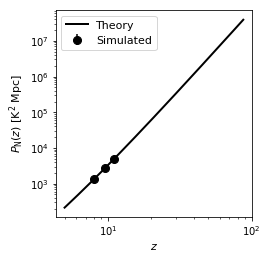

In [36]:
    print(noise_pspec_kprll_onesided.shape)
    print(noise_pspec_kprll_twosided_theory.shape)
    fig, ax = PLT.subplots(nrows=1, ncols=1, figsize=(3.5,3.5))
    ax.plot(sampled_los_qtys[model]['redshifts'], noise_pspec_kprll_twosided_theory[0,0,:].to('K2 Mpc')/NP.sqrt(2.0), ls='-', lw=2, color='black', label='Theory')
    for zpsi, zps in enumerate(z_pspec):
        if zpsi == 0:
            ax.errorbar(zps, NP.mean(noise_pspec_kprll_onesided[0,zpsi,:]).to('K2 Mpc').value, yerr=NP.std(noise_pspec_kprll_onesided[0,zpsi,:]).to('K2 Mpc').value, ls='none', marker='o', ms=8, mec='black', mfc='black', ecolor='black', label='Simulated')
        else:
            ax.errorbar(zps, NP.mean(noise_pspec_kprll_onesided[0,zpsi,:]).to('K2 Mpc').value, yerr=NP.std(noise_pspec_kprll_onesided[0,zpsi,:]).to('K2 Mpc').value, ls='none', marker='o', ms=8, mec='black', mfc='black', ecolor='black')
    ax.set_yscale('log')
    ax.set_xscale('log')
    ax.legend(loc='upper left', shadow=False, fontsize=11)
    ax.set_xlabel(r'$z$', weight='medium', fontsize=11)
    ax.set_ylabel(r'$P_\mathrm{N}(z)$ [K$^2$ Mpc]', weight='medium', fontsize=11)
    
    fig.subplots_adjust(top=0.96, right=0.96, left=0.18, bottom=0.14)
    
    PLT.savefig(figdir+'noise_power_spectrum_verification.pdf', bbox_inches=0)
    print(figdir+'noise_power_spectrum_verification.pdf')

(8.0, <Quantity 157.82286131 MHz>)
(9.5, <Quantity 135.27673826 MHz>)
(11.0, <Quantity 118.36714598 MHz>)


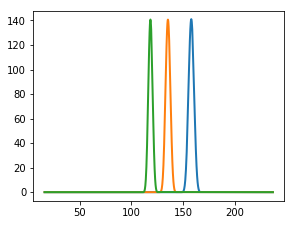

In [37]:
    fig, ax = PLT.subplots(nrows=1, ncols=1, figsize=(4.5,3.5))
    for zpsi, zps in enumerate(z_pspec):
        print(zps, rest_freq.to('MHz')/(1+zps))
        ax.plot(freq_redshift.to('MHz'), 100*d_los_comov_wts[zpsi,:], ls='-', lw=2)                


42.1773557545 uJy
43.8437330553 uJy
45.3373976678 uJy
/lustre/aoc/users/nthyagar/projects/21cmforest/figures/observable_differential_fluxdensity_Bright_galaxies_fiducial_1024.pdf
42.1773557545 uJy
43.8437330553 uJy
45.3373976678 uJy
/lustre/aoc/users/nthyagar/projects/21cmforest/figures/observable_differential_fluxdensity_Faint_galaxies_fiducial_1024.pdf
/lustre/aoc/users/nthyagar/projects/21cmforest/figures/observable_differential_brightness_temperature_Bright_galaxies_fiducial_1024.pdf
/lustre/aoc/users/nthyagar/projects/21cmforest/figures/observable_differential_brightness_temperature_Faint_galaxies_fiducial_1024.pdf
/lustre/aoc/users/nthyagar/projects/21cmforest/figures/Pspec_pre_post_modification_Bright_galaxies_fiducial_1024.pdf
/lustre/aoc/users/nthyagar/projects/21cmforest/figures/Pspec_pre_post_modification_Faint_galaxies_fiducial_1024.pdf


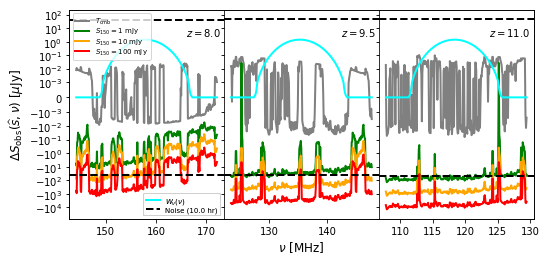

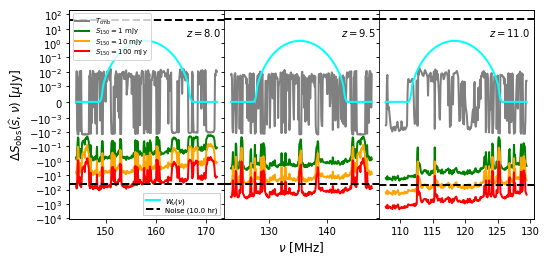

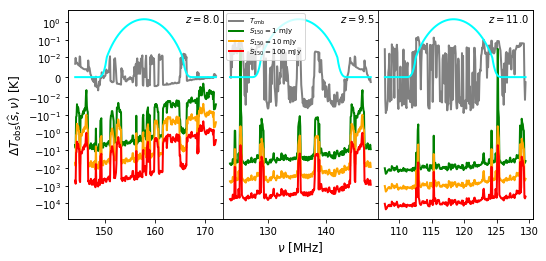

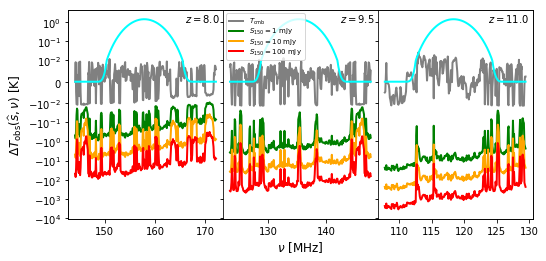

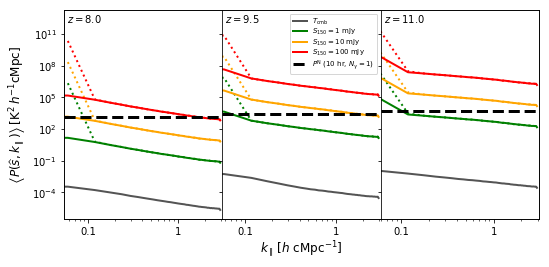

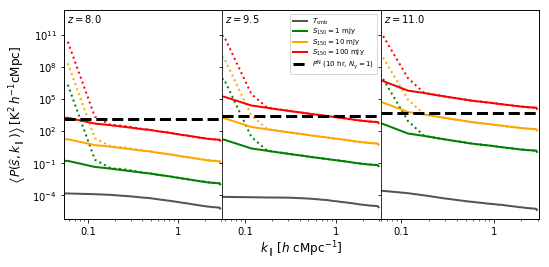

In [87]:
if ('3' in plots) or ('3a' in plots):
    uniq_beam_majax, uniq_beamind = NP.unique(beam_majax.to('arcsec').value, return_index=True)
    uniq_flux, uniq_flux_ind = NP.unique(flux_density_obs.to('uJy').value, return_index=True)
    delta_T_range = [-8e3, 5e2]
    colrs = ['green', 'orange', 'red']
    samvar_colrs = ['lightgreen', 'peachpuff', 'lightsalmon']
    bgrad_colrs = ['darkturquoise']
    bgrad_colrs += map(str, NP.linspace(0.6, 0.3, beam_majax.size).tolist())
    bgrad_samvar_colrs = ['cyan']
    bgrad_samvar_colrs += map(str, NP.linspace(0.8, 0.65, beam_majax.size).tolist())
    for modelind, model in enumerate(modelnames):
        fig, axs = PLT.subplots(ncols=z_pspec.size, sharey=True, figsize=(z_pspec.size*2.5, 3.5), squeeze=False)
        if axs.size == 1:
            axs = axs.reshape(-1)
        for zpsi, zps in enumerate(z_pspec):
            los_ind = NP.where(NP.abs(sampled_los_qtys[model]['d_los_comov'] - sampled_los_qtys[model]['cosmo'].comoving_distance(zps)) <= 1.5 * sampled_los_qtys[model]['d_los_comov_width'][zpsi])[0]
            print(1/NP.sqrt(2.0)*NP.mean(imgpixel_rms_fluxdensity_thalf_spectrum[los_ind].to('uJy')))
            lines1 = []
            lines2 = []
            for beamind, beamsize in enumerate(beam_majax):
                if beamind in uniq_beamind:
                    lines1 += axs[0,zpsi].plot(freq_redshift[los_ind].to('MHz'), sampled_los_qtys[model]['fluxdensity_delta_T_prediction']['nomonopole'][beamind,5000,los_ind].to('uJy'), ls='-', lw=2, color='gray', label=r'$T_\mathrm{cmb}$')
            for fluxind, fluxdensity in enumerate(flux_density_obs.ravel()):
                if fluxind in uniq_flux_ind:
                    lines1 += axs[0,zpsi].plot(freq_redshift[los_ind].to('MHz'), (sampled_los_qtys[model]['fluxdensity_Tb_bg_net']['nomonopole'][fluxind,5000,los_ind] - obsframe_fluxdensity_qso_spectrum[fluxind,los_ind]).to('uJy'), ls='-', lw=2, color=colrs[fluxind], label=r'$S_{150}=$'+'{0:.0f} mJy'.format(flux_density_obs[fluxind].to('mJy').value))
            lines2 += axs[0,zpsi].plot(freq_redshift[los_ind].to('MHz'), d_los_comov_wts[zpsi,los_ind], ls='-', lw=2, color='cyan', label=r'$W_\nu(\nu)$')                
            lines2 += [axs[0,zpsi].axhline(1/NP.sqrt(2.0)*NP.mean(imgpixel_rms_fluxdensity_thalf_spectrum[los_ind].to('uJy').value), ls='--', lw=2, color='black', label='Noise ({0} hr)'.format(t_int.to('hr').value))]
            axs[0,zpsi].axhline(-1/NP.sqrt(2.0)*NP.mean(imgpixel_rms_fluxdensity_thalf_spectrum[los_ind].to('uJy').value), ls='--', lw=2, color='black')
            axs[0,zpsi].text(0.98, 0.92, r'$z=$'+'{0}'.format(zps), transform=axs[0,zpsi].transAxes, ha='right', va='top')
            axs[0,zpsi].set_yscale('symlog', linthreshy=1e-3)
#             axs[0,zpsi].set_xlabel(r'$\nu$ [MHz]', fontsize=12, weight='medium')
            axs[0,0].set_ylabel(r'$\Delta S_\mathrm{obs}(\widehat{s},\nu)$ [$\mu$Jy]', fontsize=12, weight='medium')
#             axs[0,1].legend(loc='upper left', shadow=False, fontsize=7, labelspacing=0)
            leg2 = axs[0,0].legend(handles=lines2, loc='lower right', shadow=False, fontsize=7, labelspacing=0)
            leg1 = axs[0,0].legend(handles=lines1, loc='upper left', shadow=False, fontsize=7, labelspacing=0)
            axs[0,0].add_artist(leg2)

        fig.subplots_adjust(hspace=0, wspace=0)
        fig.subplots_adjust(bottom=0.15, top=0.98, left=0.12, right=0.98)

        big_ax = fig.add_subplot(111)
        big_ax.set_facecolor('none') # matplotlib.__version__ >= 2.0.0
        # big_ax.set_axis_bgcolor('none') # matplotlib.__version__ < 2.0.0
        big_ax.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
        big_ax.set_xticks([])
        big_ax.set_yticks([])
        big_ax.set_xlabel(r'$\nu$ [MHz]', fontsize=12, weight='medium', labelpad=20)

        PLT.savefig(figdir+'observable_differential_fluxdensity_{0}.pdf'.format(model), bbox_inches=0)
        print(figdir+'observable_differential_fluxdensity_{0}.pdf'.format(model))

    for modelind, model in enumerate(modelnames):
        fig, axs = PLT.subplots(ncols=z_pspec.size, sharey=True, figsize=(z_pspec.size*2.5, 3.5), squeeze=False)
        if axs.size == 1:
            axs = axs.reshape(-1)
        for zpsi, zps in enumerate(z_pspec):
            los_ind = NP.where(NP.abs(sampled_los_qtys[model]['d_los_comov'] - sampled_los_qtys[model]['cosmo'].comoving_distance(zps)) <= 1.5 * sampled_los_qtys[model]['d_los_comov_width'][zpsi])[0]
#             axs[0].plot(freq_redshift[los_ind].to('MHz'), sampled_los_qtys[model]['delta_T_prediction']['cube'][5000,los_ind].to('K') - sampled_los_qtys[model]['delta_T_prediction']['monopole'][los_ind].to('K').reshape(-1), ls='-', lw=1, color='gray')

            axs[0,zpsi].plot(freq_redshift[los_ind].to('MHz'), (sampled_los_qtys[model]['delta_T_prediction']['cube'][5000,los_ind] - sampled_los_qtys[model]['delta_T_prediction']['monopole'][los_ind].reshape(-1)).to('K'), ls='-', lw=2, color='gray', label=r'$T_\mathrm{cmb}$')
            for fluxind, fluxdensity in enumerate(flux_density_obs.ravel()):
                axs[0,zpsi].plot(freq_redshift[los_ind].to('MHz'), (sampled_los_qtys[model]['obsframe_Tb_bg_net']['nomonopole'][fluxind,5000,los_ind] - obsframe_temp_qso_spectrum[fluxind,los_ind]).to('K'), ls='-', lw=2, color=colrs[fluxind], label=r'$S_{150}=$'+'{0:.0f} mJy'.format(flux_density_obs[fluxind].to('mJy').value))
            axs[0,zpsi].plot(freq_redshift[los_ind].to('MHz'), d_los_comov_wts[zpsi,los_ind], ls='-', lw=2, color='cyan')                
            axs[0,zpsi].text(0.98, 0.99, r'$z=$'+'{0}'.format(zps), transform=axs[0,zpsi].transAxes, ha='right', va='top')
            axs[0,zpsi].set_yscale('symlog', linthreshy=1e-2)
#             axs[0,zpsi].set_xlabel(r'$\nu$ [MHz]', fontsize=12, weight='medium')
            axs[0,0].set_ylabel(r'$\Delta T_\mathrm{obs}(\widehat{s},\nu)$ [K]', fontsize=12, weight='medium')
            axs[0,1].legend(loc='upper left', shadow=False, fontsize=7, labelspacing=0)

        fig.subplots_adjust(hspace=0, wspace=0)
        fig.subplots_adjust(bottom=0.15, top=0.98, left=0.12, right=0.98)

        big_ax = fig.add_subplot(111)
        big_ax.set_facecolor('none') # matplotlib.__version__ >= 2.0.0
        # big_ax.set_axis_bgcolor('none') # matplotlib.__version__ < 2.0.0
        big_ax.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
        big_ax.set_xticks([])
        big_ax.set_yticks([])
        big_ax.set_xlabel(r'$\nu$ [MHz]', fontsize=12, weight='medium', labelpad=20)

        PLT.savefig(figdir+'observable_differential_brightness_temperature_{0}.pdf'.format(model), bbox_inches=0)
        print(figdir+'observable_differential_brightness_temperature_{0}.pdf'.format(model))

    for modelind, model in enumerate(modelnames):
        fig, axs = PLT.subplots(ncols=z_pspec.size, sharey=True, figsize=(z_pspec.size*2.5, 3.5), squeeze=False)
        if axs.size == 1:
            axs = axs.reshape(-1)
        for zpsi, zps in enumerate(z_pspec):
            kprll_min = 2*NP.pi / sampled_los_qtys[model]['d_los_comov_width'][zpsi]
#             axs[0,zpsi].fill_between(kprll_onesided[model], pspec_kprll_onesided_orig[model][0,zpsi,:].to('K2 Mpc').value*(1-1./NP.sqrt(nsamples_total_onesided[model][zpsi])), pspec_kprll_onesided_orig[model][0,zpsi,:].to('K2 Mpc').value*(1+1./NP.sqrt(nsamples_total_onesided[model][zpsi])), color='0.67', alpha=0.5)
            axs[0,zpsi].plot(kprll_onesided[model], pspec_kprll_onesided_orig[model][0,zpsi,:].to('K2 Mpc').value, ls='-', lw=2, color='0.33', label=r'$T_\mathrm{cmb}$')
#             for fluxind, fluxdensity in enumerate(flux_density_obs.ravel()):
#                 axs[0,zpsi].fill_between(kprll_onesided[model], pspec_kprll_onesided[model][fluxind,zpsi,:].to('K2 Mpc').value*(1-1./NP.sqrt(nsamples_total_onesided[model][zpsi])), pspec_kprll_onesided[model][fluxind,zpsi,:].to('K2 Mpc').value*(1+1./NP.sqrt(nsamples_total_onesided[model][zpsi])), color=samvar_colrs[fluxind], alpha=0.5)
            for fluxind, fluxdensity in enumerate(flux_density_obs.ravel()):
                axs[0,zpsi].plot(kprll_onesided[model], pspec_kprll_onesided[model][fluxind,zpsi,:].to('K2 Mpc').value, ls=':', lw=2, color=colrs[fluxind])
                axs[0,zpsi].plot(kprll_onesided[model], pspec_kprll_onesided_differential[model][fluxind,zpsi,:].to('K2 Mpc').value, ls='-', lw=2, color=colrs[fluxind], label=r'$S_{150}=$'+'{0:.0f} mJy'.format(fluxdensity.to('mJy').value))
            for beamind, beamsize in enumerate(beam_majax):
                if beamind in uniq_beamind:            
                    axs[0,zpsi].axhline(NP.mean(noise_pspec_kprll_onesided[beamind,zpsi,:].to('K2 Mpc').value, axis=-1), ls='--', lw=3, color='black', label=r'$P^\mathrm{N}$ '+'({0:.0f} hr, '.format(t_int.to('hr').value)+r'$N_\gamma=1$)')
#                     axs[0,zpsi].plot(kprll_onesided[model], NP.abs(noise_pspec_kprll_onesided[beamind,zpsi,:].to('K2 Mpc').value, ls='--', lw=2, color='black')
            axs[0,zpsi].set_xlim(xmin=0.9*kprll_min.to('Mpc-1').value)
#             axs[0,zpsi].set_ylim(0.2, 3e7)
            axs[0,zpsi].set_xscale('log')
            axs[0,zpsi].set_yscale('log')
            tickformatter = ticker.FuncFormatter(lambda y, _: '{:.16g}'.format(y))
            axs[0,zpsi].xaxis.set_major_formatter(tickformatter)
            axs[0,zpsi].text(0.02, 0.99, r'$z=$'+'{0:.1f}'.format(zps), transform=axs[0,zpsi].transAxes, ha='left', va='top')
#             axs[0,zpsi].set_xlabel(r'$k_\parallel\,[h\,\mathrm{Mpc}^{-1}]$', fontsize=12, weight='medium')
            axs[0,0].set_ylabel(r'$\left\langle P(\widehat{s},k_\parallel)\right\rangle\,[\mathrm{K}^2\,h^{-1}\mathrm{cMpc}]$', fontsize=12, weight='medium')
            axs[0,1].legend(loc='upper right', shadow=False, fontsize=7, labelspacing=0)

        fig.subplots_adjust(hspace=0, wspace=0)
        fig.subplots_adjust(bottom=0.15, top=0.98, left=0.1, right=0.98)

        big_ax = fig.add_subplot(111)
        big_ax.set_facecolor('none') # matplotlib.__version__ >= 2.0.0
        # big_ax.set_axis_bgcolor('none') # matplotlib.__version__ < 2.0.0
        big_ax.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
        big_ax.set_xticks([])
        big_ax.set_yticks([])
        big_ax.set_xlabel(r'$k_\parallel\,[h\,\,\mathrm{cMpc}^{-1}]$', fontsize=12, weight='medium', labelpad=20)

        PLT.savefig(figdir+'Pspec_pre_post_modification_{0}.pdf'.format(model), bbox_inches=0)
        print(figdir+'Pspec_pre_post_modification_{0}.pdf'.format(model))

/lustre/aoc/users/nthyagar/projects/21cmforest/figures/Nqso_required_Bright_galaxies_fiducial_1024.pdf
/lustre/aoc/users/nthyagar/projects/21cmforest/figures/Nqso_required_Faint_galaxies_fiducial_1024.pdf
/lustre/aoc/users/nthyagar/projects/21cmforest/figures/A_over_T_required_Bright_galaxies_fiducial_1024.pdf
/lustre/aoc/users/nthyagar/projects/21cmforest/figures/A_over_T_required_Faint_galaxies_fiducial_1024.pdf


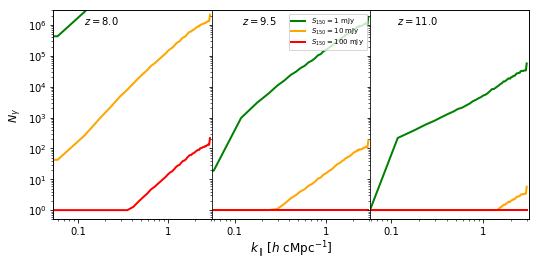

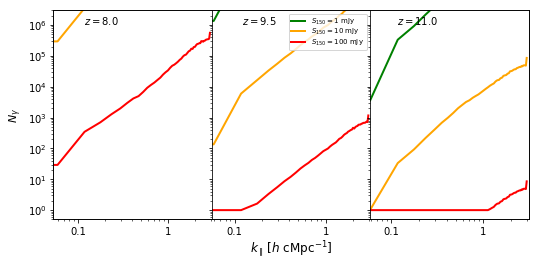

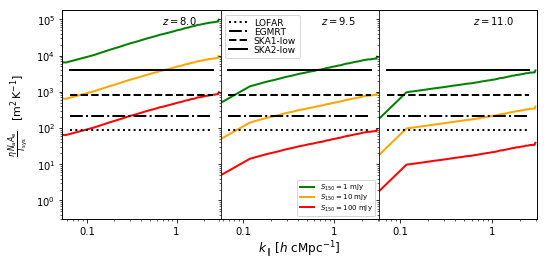

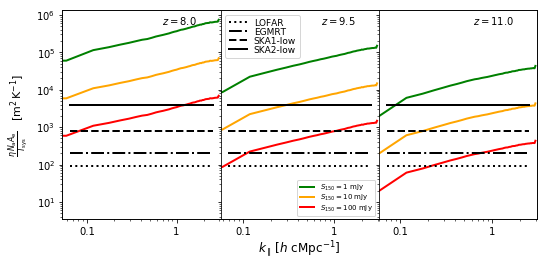

In [39]:
if ('3' in plots) or ('3a' in plots):

    nqso_reqd_differential = {}
    effA_over_Tsys_reqd_differential = {}
    for model in modelnames:
        nqso_reqd_differential[model] = detection_threshold**2 / (2*t_half)**2 / (efficiency_factor * input_array_sensitivity)**4 * ((wl_zpspec.reshape(1,-1,1)**2 / beam_sa_0.to('', equivalencies=U.dimensionless_angles()).reshape(-1,1,1))**2 * sampled_los_qtys[model]['d_los_comov_width'].reshape(1,-1,1) / bw.reshape(1,-1,1) / pspec_kprll_onesided_differential[model])**2 # (nbeam, nz_pspec, nkprll)        
        nqso_reqd_differential[model] = NP.clip(nqso_reqd_differential[model].decompose().value, a_min=1.0, a_max=None)
        
        effA_over_Tsys_reqd_differential[model] = 1 / (input_nqso)**0.25 * NP.sqrt(detection_threshold/(2*t_half)) * (wl_zpspec.reshape(1,-1,1)**2 / beam_sa_0.to('', equivalencies=U.dimensionless_angles()).reshape(-1,1,1)) * NP.sqrt(sampled_los_qtys[model]['d_los_comov_width'].reshape(1,-1,1) / bw.reshape(1,-1,1) / pspec_kprll_onesided_differential[model]) # (nbeam, nz_pspec, nkprll)
        effA_over_Tsys_reqd_differential[model] = effA_over_Tsys_reqd_differential[model].to('m2 K-1')
        
    uniq_beam_majax, uniq_beamind = NP.unique(beam_majax.to('arcsec').value, return_index=True)
    uniq_flux, uniq_flux_ind = NP.unique(flux_density_obs.to('uJy').value, return_index=True)
    fluxdensity_colrs = ['green', 'orange', 'red']
    telescope_ls = {'uGMRT': '-.', 'EGMRT': '-.', 'LOFAR': ':', 'SKA1-low': '--', 'SKA2-low': '-'}
    
    for model in modelnames:
        fig, axs = PLT.subplots(ncols=z_pspec.size, sharey=True, figsize=(z_pspec.size*2.5, 3.5), squeeze=False)
        if axs.size == 1:
            axs = axs.reshape(-1)
        for zpsi, zps in enumerate(z_pspec):
            kprll_min = 2*NP.pi / sampled_los_qtys[model]['d_los_comov_width'][zpsi]
            for fluxind, fluxdensity in enumerate(flux_density_obs.ravel()):
                axs[0,zpsi].plot(kprll_onesided[model], nqso_reqd_differential[model][fluxind,zpsi,:], ls='-', lw=2, color=fluxdensity_colrs[fluxind], label=r'$S_{150}=$'+'{0:.0f} mJy'.format(fluxdensity.to('mJy').value))
            axs[0,zpsi].set_xlim(xmin=0.9*kprll_min.to('Mpc-1').value)
            axs[0,zpsi].set_ylim(ymin=0.5, ymax=3e6)
            axs[0,zpsi].set_xscale('log')
            axs[0,zpsi].set_yscale('log')                
            tickformatter = ticker.FuncFormatter(lambda y, _: '{:.16g}'.format(y))
            axs[0,zpsi].xaxis.set_major_formatter(tickformatter)
            axs[0,zpsi].text(0.3, 0.98, r'$z=$'+'{0:.1f}'.format(zps), transform=axs[0,zpsi].transAxes, ha='center', va='top')
#             axs[0,0].set_ylabel(r'$N_\gamma\, \left(\frac{5}{\mathrm{SNR}}\right)^2 \left(\frac{\delta t}{10\,\mathrm{hr}}\right)^2 \left(\frac{\eta\,N_\mathrm{a}A_\mathrm{e}/T_\mathrm{sys}}{800\,\mathrm{m}^2/\mathrm{K}}\right)^4$', fontsize=11, weight='medium')
            axs[0,0].set_ylabel(r'$N_\gamma$', fontsize=11, weight='medium')
            axs[0,1].legend(loc='upper right', shadow=False, fontsize=7, labelspacing=0)

        fig.subplots_adjust(hspace=0, wspace=0)
        fig.subplots_adjust(bottom=0.15, top=0.98, left=0.1, right=0.98)
                
        big_ax = fig.add_subplot(111)
        big_ax.set_facecolor('none') # matplotlib.__version__ >= 2.0.0
        # big_ax.set_axis_bgcolor('none') # matplotlib.__version__ < 2.0.0
        big_ax.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
        big_ax.set_xticks([])
        big_ax.set_yticks([])
        big_ax.set_xlabel(r'$k_\parallel\,[h\,\,\mathrm{cMpc}^{-1}]$', fontsize=12, weight='medium', labelpad=20)

        PLT.savefig(figdir+'Nqso_required_{0}.pdf'.format(model), bbox_inches=0)
        print(figdir+'Nqso_required_{0}.pdf'.format(model))                
                
    for model in modelnames:
        fig, axs = PLT.subplots(ncols=z_pspec.size, sharey=True, figsize=(z_pspec.size*2.5, 3.5), squeeze=False)
        if axs.size == 1:
            axs = axs.reshape(-1)
        for zpsi, zps in enumerate(z_pspec):
            kprll_min = 2*NP.pi / sampled_los_qtys[model]['d_los_comov_width'][zpsi]
            lines1 = []
            lines2 = []
            for fluxind, fluxdensity in enumerate(flux_density_obs.ravel()):
                lines1 += axs[0,zpsi].plot(kprll_onesided[model], effA_over_Tsys_reqd_differential[model][fluxind,zpsi,:], ls='-', lw=2, color=fluxdensity_colrs[fluxind], label=r'$S_{150}=$'+'{0:.0f} mJy'.format(fluxdensity.to('mJy').value))
            lines2 += [axs[0,zpsi].axhline(lofar_array_sensitivity.to('m2 K-1').value, xmin=0.05, xmax=0.95, ls=telescope_ls['LOFAR'], lw=2, color='black', label='LOFAR')]
            lines2 += [axs[0,zpsi].axhline(eGMRT_array_sensitivity.to('m2 K-1').value, xmin=0.05, xmax=0.95, ls=telescope_ls['EGMRT'], lw=2, color='black', label='EGMRT')]
            lines2 += [axs[0,zpsi].axhline(ska1_array_sensitivity.to('m2 K-1').value, xmin=0.05, xmax=0.95, ls=telescope_ls['SKA1-low'], lw=2, color='black', label='SKA1-low')]
            lines2 += [axs[0,zpsi].axhline(ska2_array_sensitivity.to('m2 K-1').value, xmin=0.05, xmax=0.95, ls=telescope_ls['SKA2-low'], lw=2, color='black', label='SKA2-low')]
            axs[0,zpsi].set_xlim(xmin=0.9*kprll_min.to('Mpc-1').value)
            axs[0,zpsi].set_xscale('log')
            axs[0,zpsi].set_yscale('log')                
            tickformatter = ticker.FuncFormatter(lambda y, _: '{:.16g}'.format(y))
            axs[0,zpsi].xaxis.set_major_formatter(tickformatter)
            axs[0,zpsi].text(0.85, 0.98, r'$z=$'+'{0:.1f}'.format(zps), transform=axs[0,zpsi].transAxes, ha='right', va='top')
#             axs[0,0].set_ylabel(r'$\frac{\eta\,N_\mathrm{a}A_\mathrm{e}}{T_\mathrm{sys}}\,\left(\frac{N_\gamma}{100}\right)^{1/4}\, \left(\frac{\delta t}{10\,\mathrm{hr}}\right)^{1/2} \left(\frac{5}{\mathrm{SNR}}\right)^{1/2}\,[\mathrm{m}^2\,\mathrm{K}^{-1}]$', fontsize=11, weight='medium')
            axs[0,0].set_ylabel(r'$\frac{\eta\,N_\mathrm{a}A_\mathrm{e}}{T_\mathrm{sys}}\quad[\mathrm{m}^2\,\mathrm{K}^{-1}]$', fontsize=11, weight='medium')
            if zpsi == 1:
                leg1 = axs[0,zpsi].legend(handles=lines1, loc='lower right', shadow=False, fontsize=7, labelspacing=0)
                leg2 = axs[0,zpsi].legend(handles=lines2, loc='upper left', shadow=False, fontsize=9, labelspacing=0)
                axs[0,zpsi].add_artist(leg1)
        fig.subplots_adjust(hspace=0, wspace=0)
        fig.subplots_adjust(bottom=0.15, top=0.98, left=0.1, right=0.98)
                
        big_ax = fig.add_subplot(111)
        big_ax.set_facecolor('none') # matplotlib.__version__ >= 2.0.0
        # big_ax.set_axis_bgcolor('none') # matplotlib.__version__ < 2.0.0
        big_ax.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
        big_ax.set_xticks([])
        big_ax.set_yticks([])
        big_ax.set_xlabel(r'$k_\parallel\,[h\,\,\mathrm{cMpc}^{-1}]$', fontsize=12, weight='medium', labelpad=20)

        PLT.savefig(figdir+'A_over_T_required_{0}.pdf'.format(model), bbox_inches=0)
        print(figdir+'A_over_T_required_{0}.pdf'.format(model))                
                

/lustre/aoc/users/nthyagar/projects/21cmforest/figures/Brms_required_Bright_galaxies_fiducial_1024.pdf
/lustre/aoc/users/nthyagar/projects/21cmforest/figures/Brms_required_Faint_galaxies_fiducial_1024.pdf


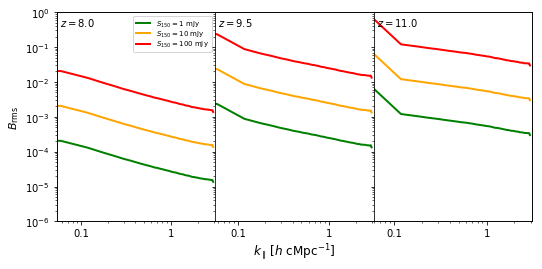

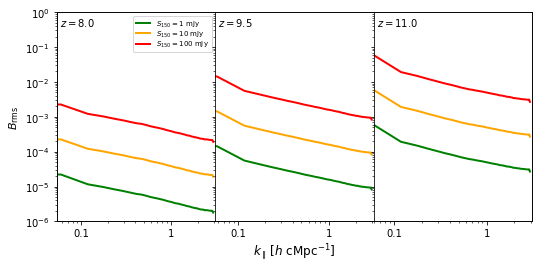

In [156]:
if ('3' in plots) or ('3a' in plots):

    brms_reqd_differential = {}
    for model in modelnames:
        confusion_power = rms_confusion[:,:,NP.newaxis]**2 * sampled_los_qtys[model]['boxres'] * ((wl_zpspec.reshape(1,-1,1)**2 / (2*FC.k_B*beam_sa_0.to('', equivalencies=U.dimensionless_angles()).reshape(-1,1,1)))**2)
        brms_reqd_differential[model] = NP.sqrt(NP.sqrt(input_nqso)*pspec_kprll_onesided_differential[model]/(detection_threshold*rms_confusion[:,:,NP.newaxis]**2 * sampled_los_qtys[model]['boxres'] * ((wl_zpspec.reshape(1,-1,1)**2 / (2*FC.k_B*beam_sa_0.to('', equivalencies=U.dimensionless_angles()).reshape(-1,1,1)))**2)) * beam_sa_0.reshape(-1,1,1) / pbeam_solang)
        brms_reqd_differential[model] = brms_reqd_differential[model].decompose()
#         print((pbeam_solang / beam_sa_0).decompose())
#         print(confusion_power.shape)
#         print(confusion_power.to('K2 Mpc'))
#         print(pspec_kprll_onesided_differential[model].to('K2 Mpc'))
#         print(pspec_kprll_onesided_differential[model].unit)
#         print((detection_threshold*rms_confusion[:,:,NP.newaxis]**2 * sampled_los_qtys[model]['boxres'] * ((wl_zpspec.reshape(1,-1,1)**2 / (2*FC.k_B*beam_sa_0.to('', equivalencies=U.dimensionless_angles()).reshape(-1,1,1)))**2)).to('K2 Mpc'))
#         print(brms_reqd_differential[model].decompose().unit)
#         print(brms_reqd_differential[model].decompose())

    uniq_beam_majax, uniq_beamind = NP.unique(beam_majax.to('arcsec').value, return_index=True)
    uniq_flux, uniq_flux_ind = NP.unique(flux_density_obs.to('uJy').value, return_index=True)
    fluxdensity_colrs = ['green', 'orange', 'red']

    for model in modelnames:
        fig, axs = PLT.subplots(ncols=z_pspec.size, sharey=True, figsize=(z_pspec.size*2.5, 3.5), squeeze=False)
        if axs.size == 1:
            axs = axs.reshape(-1)
        for zpsi, zps in enumerate(z_pspec):
            kprll_min = 2*NP.pi / sampled_los_qtys[model]['d_los_comov_width'][zpsi]
            for fluxind, fluxdensity in enumerate(flux_density_obs.ravel()):
                axs[0,zpsi].plot(kprll_onesided[model], brms_reqd_differential[model][fluxind,zpsi,:], ls='-', lw=2, color=fluxdensity_colrs[fluxind], label=r'$S_{150}=$'+'{0:.0f} mJy'.format(fluxdensity.to('mJy').value))
            axs[0,zpsi].set_xlim(xmin=0.9*kprll_min.to('Mpc-1').value)
            axs[0,zpsi].set_ylim(ymin=1e-6, ymax=1.0)
            axs[0,zpsi].set_xscale('log')
            axs[0,zpsi].set_yscale('log')                
            tickformatter = ticker.FuncFormatter(lambda y, _: '{:.16g}'.format(y))
            axs[0,zpsi].xaxis.set_major_formatter(tickformatter)
            axs[0,zpsi].text(0.02, 0.98, r'$z=$'+'{0:.1f}'.format(zps), transform=axs[0,zpsi].transAxes, ha='left', va='top')
#             axs[0,0].set_ylabel(r'$N_\gamma\, \left(\frac{5}{\mathrm{SNR}}\right)^2 \left(\frac{\delta t}{10\,\mathrm{hr}}\right)^2 \left(\frac{\eta\,N_\mathrm{a}A_\mathrm{e}/T_\mathrm{sys}}{800\,\mathrm{m}^2/\mathrm{K}}\right)^4$', fontsize=11, weight='medium')
            axs[0,0].set_ylabel(r'$B_\mathrm{rms}$', fontsize=11, weight='medium')
            axs[0,0].legend(loc='upper right', shadow=False, fontsize=7, labelspacing=0)

        fig.subplots_adjust(hspace=0, wspace=0)
        fig.subplots_adjust(bottom=0.15, top=0.98, left=0.1, right=0.98)
                
        big_ax = fig.add_subplot(111)
        big_ax.set_facecolor('none') # matplotlib.__version__ >= 2.0.0
        # big_ax.set_axis_bgcolor('none') # matplotlib.__version__ < 2.0.0
        big_ax.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
        big_ax.set_xticks([])
        big_ax.set_yticks([])
        big_ax.set_xlabel(r'$k_\parallel\,[h\,\,\mathrm{cMpc}^{-1}]$', fontsize=12, weight='medium', labelpad=20)

        PLT.savefig(figdir+'Brms_required_{0}.pdf'.format(model), bbox_inches=0)
        print(figdir+'Brms_required_{0}.pdf'.format(model))                


In [267]:
print(freq_redshift.to('MHz'))
print(NP.diff(freq_redshift.to('kHz')))
print(freq_resolution.to('kHz'))
print(bw.to('MHz'))
print(NP.pi * (0.5*35*U.m)**2)
aeff_over_T = 500 * U.m**2 / U.K
aeff_over_T_gmrt = 100 * U.m**2 / U.K
sysT = 384 * U.K
n_ant_SKA = 512
df = 80 * U.kHz
sefd_array = 2 * FC.k_B / aeff_over_T
print(sefd_array.to('Jy'))
print((500 * U.m**2 / U.K * 384 * U.K)/(NP.pi * (0.5*35*U.m)**2))
# sefd_gmrt_array = 1000 * U.Jy / NP.sqrt(30.*29)
sefd_gmrt_array = 2 * FC.k_B / aeff_over_T_gmrt
print(sefd_gmrt_array.to('Jy'))
print((sefd_array/NP.sqrt(2 * 100*U.kHz * 1*U.hr)).to('mJy'))
print((sefd_gmrt_array/NP.sqrt(2 * 100*U.kHz * 1*U.hr)).to('mJy'))
print(sampled_los_qtys[model]['d_los_comov_width'].to('Mpc'))
noise_power_std_kprll = ((sysT / NP.sqrt(2 * n_ant_SKA * (n_ant_SKA-1) * 1*U.hr) / efficiency_factor) * NP.sqrt(bw.reshape(1,-1,1)))**2 * sampled_los_qtys[model]['d_los_comov_width'].reshape(1,-1,1) / bw.reshape(1,-1,1)**2
print(noise_power_std_kprll.to('K2 Mpc'))

[236.73429187 236.61995033 236.5056371  ...  16.1243475   16.09450508
  16.06468998] MHz
[-114.34153628 -114.31322879 -114.28466853 ...  -29.86973938  -29.84242124
  -29.81510153] kHz
[91.7761814  78.89995324 63.99832677] kHz
[9.14002133 6.97703757 4.72688104] MHz
962.112750162 m2
5.52259408 Jy
199.560810277
27.6129704 Jy
0.205814929584 mJy
1.02907464792 mJy
[105.50351902  93.67938598  78.24485193] Mpc
[[[9.03563809e-10]
  [1.05102263e-09]
  [1.29574694e-09]]] K2 Mpc


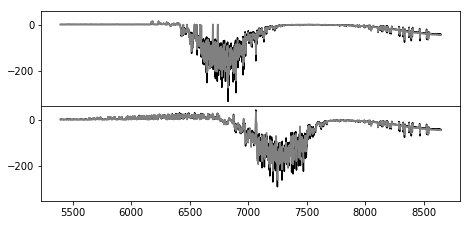

In [82]:
    #     sampled_los_qtys[mdl]['delta_T']['cube'].shape
    fig, axs = PLT.subplots(nrows=2, ncols=1, sharex=True, sharey=True, figsize=(7.5,3.5))
    for mdlind, mdl in enumerate(modelnames):
        axs[mdlind].plot(sampled_los_qtys[mdl]['d_los_comov'], sampled_los_qtys[mdl]['delta_T']['cube'][0,:].to('mK').value, ls='-', color='black')
        axs[mdlind].plot(sampled_los_qtys[mdl]['d_los_comov'], sampled_los_qtys[mdl]['delta_T_prediction']['cube'][0,:].to('mK').value, ls='-', color='gray')
        
    fig.subplots_adjust(hspace=0, wspace=0)

In [108]:
print(beam_sa_0.to('arcmin2'))
print(beam_sa_0.to('arcsec2'))
print(FC.c/freq_zpspec)
wl = 2.2 * U.m
print((wl**2 / beam_sa_0.to('', equivalencies=U.dimensionless_angles())).to('km2'))
coeff = (10*U.hr)**2 / (5**2) * (8*U.MHz)**2 / (100*U.Mpc)**2 / (2*U.m)**8 * (800*U.m**2/U.K)**4 * beam_sa_0[0].to('', equivalencies=U.dimensionless_angles())**4 * (20000*U.K**4 * U.Mpc**2)
coeff.decompose()
print(freq_zpspec.to('MHz'))

[0.02181662 0.02181662 0.02181662] arcmin2
[78.53981634 78.53981634 78.53981634] arcsec2
[1.89955026 2.21614198 2.53273369] m / (Hz s)
[2621.83735371 2621.83735371 2621.83735371] km2
[157.82286131 135.27673826 118.36714598] MHz


In [118]:
rms_confusion = classical_source_confusion(theta_FWHM=beam_majax.reshape(-1), frequency=freq_zpspec)
print(rms_confusion)
theta_p = 5 * U.deg
k_prll_modemix_max = 2*NP.pi * sampled_los_qtys[model]['cosmo'].H(z_pspec) / (FC.c * (1+z_pspec)) * NP.sin(0.5*theta_p) / (2*NP.sin(0.5*beam_majax[0]))
print(k_prll_modemix_max.to('Mpc-1'))

[19.92969002 22.20052765 24.37573161] uJy
[3.14622436 3.39672774 3.63046668] 1 / Mpc


In [115]:
print(sampled_los_qtys[model]['cosmo'].efunc(z_pspec[1]))

18.914121602889903


In [41]:
print((0.8)**-4)
print((1.2)**-4)

2.44140625
0.48225308642


In [53]:
print(cosmo100_Planck15)
print(cosmo_in)
print(cosmo)
boxres_ang = boxres / cosmo.comoving_distance([8.0,9.5,11.0])
3.6e3 * NP.degrees(boxres_ang.decompose().value)

FlatLambdaCDM(name="Modified Planck 2015 cosmology with h=1.0", H0=100 km / (Mpc s), Om0=0.307, Tcmb0=2.725 K, Neff=3.05, m_nu=[0.   0.   0.06] eV, Ob0=0.0486)
wCDM(H0=67.8 km / (Mpc s), Om0=0.308, Ode0=0.692, w0=-1, Tcmb0=2.725 K, Neff=3.04, m_nu=[0. 0. 0.] eV, Ob0=0.0484)
wCDM(H0=100 km / (Mpc s), Om0=0.308, Ode0=0.692, w0=-1, Tcmb0=2.725 K, Neff=3.04, m_nu=[0. 0. 0.] eV, Ob0=0.0484)


array([35.2356194 , 33.78308193, 32.69624624])